In [4]:
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging
import tensorflow as tf

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import random

random.seed(seed)

from tensorflow.keras import backend as K
import tf2onnx
import onnxruntime as rt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0-rc0


In [5]:
dataset = "cifar10"
if dataset == "fashion_mnist":
    (X_train, y_train), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()
elif dataset == "cifar10":
    (X_train, y_train), (X_test, y_test) = tfk.datasets.cifar10.load_data()
elif dataset == "mnist":
    (X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()

In [6]:
"""
- X: [X]
- y: [y] -> [y, None]
- conditioned: [True] -> [True, False]
- data_format: [image] -> [image, tablular]
- image_size: [32,64,128] -> [32,64,128]
- model_size: [medium] -> [small, medium, big]
- task: [classification] -> [classification, regression, None]
- subtask: [digit classification]
- data_description: [str]
- dataset_name: [str]
"""

X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print(X.shape, y.shape)
epochs = 100
batch_size = 256
image_size = 32
model_size = "small"
task = "classification"
sub_task = "Toy image classification"
data_description = "A toy balanced image dataset containing 10 different classes"
dataset_name = "CIFAR10"
verbose = 2

(60000, 32, 32, 3) (60000, 1)


In [121]:
# mob = tfk.applications.MobileNetV2()

In [122]:
# tfk.utils.plot_model(mob, show_shapes=True)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 40, 40, 3)        0         
 ng2D)                                                           
                                                                 
 random_crop_5 (RandomCrop)  (None, 32, 32, 3)         0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 conv0 (Conv2D)              (None, 16, 16, 64)        1792      
                                                                 
 bn0 (BatchNormalization)    (None, 16, 16, 64)        256       
                                                               

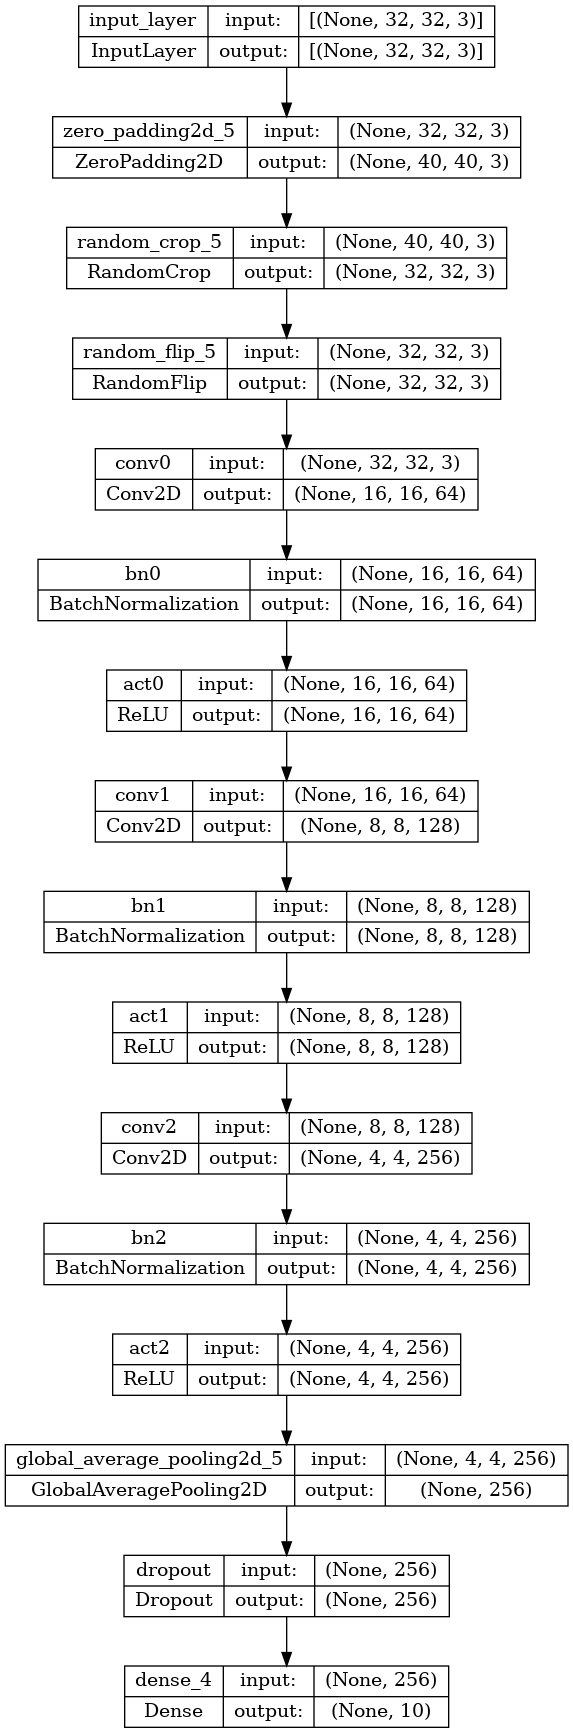

In [26]:
def scheduler(epoch, lr):
    if epoch == 60:
        return lr * 0.01
    if epoch == 80:
        return lr * 0.01
    else:
        return lr


# def mobile_block(
#     x,
#     in_filters,
#     out_filters,
#     expansion,
#     strides,
#     name=''
# ):
#     planes = expansion * in_filters

# def mobile_reduction_block(
#     x,
#     in_filters,
#     out_filters,
#     expansion,
#     strides,
#     name=''
# ):
#     s = tfkl.Conv2D()(x)
#     s = tfkl.DepthwiseConv2D()(s)
#     s = tfkl.Conv2D()(s)


# def res_block(
#     x,
#     filters,
#     weight_decay,
#     name='',
#     **kwargs,
# ):
#     x = tfkl.BatchNormalization(name=name+'bn0')(x)
#     x = tfkl.ReLU(name=name+'act0')(x)
#     x = tfkl.Conv2D(filters, 1, 2, padding='same', kernel_regularizer=tfk.regularizers.L2(weight_decay), name=name+'conv0')(x)
#     s = tfkl.BatchNormalization(name=name+'bn1', fused=True)(x)
#     s = tfkl.ReLU(name=name+'act1')(s)
#     s = tfkl.Conv2D(filters, 1, padding='same', kernel_regularizer=tfk.regularizers.L2(weight_decay), name=name+'conv1')(s)
#     s = tfkl.BatchNormalization(name=name+'bn2', fused=True)(x)
#     s = tfkl.ReLU(name=name+'act2')(s)
#     s = tfkl.Conv2D(filters, 3, padding='same', kernel_regularizer=tfk.regularizers.L2(weight_decay), name=name+'conv2')(s)
#     s = tfkl.BatchNormalization(name=name+'bn3', fused=True)(x)
#     s = tfkl.ReLU(name=name+'act3')(s)
#     s = tfkl.Conv2D(filters, 1, padding='same', kernel_regularizer=tfk.regularizers.L2(weight_decay), name=name+'conv3')(s)

#     return tfkl.Add(name=name+'add')([x,s])


def build_resnet18(
    input_shape,
    num_classes,
    filters=64,
    blocks=4,
    weight_decay=2e-4,
    **kwargs,
):
    input_layer = tfkl.Input(input_shape, name="input_layer")

    pad = input_shape[0] // 8
    padding = tfkl.ZeroPadding2D(padding=(pad, pad))(input_layer)
    crop = tfkl.RandomCrop(input_shape[0], input_shape[0])(padding)
    flip = tf.keras.layers.RandomFlip(mode="horizontal")(crop)

    x = tfkl.Conv2D(filters, 3, 2, padding="same", name="conv0")(flip)
    x = tfkl.BatchNormalization(name="bn0")(x)
    x = tfkl.ReLU(name="act0")(x)
    x = tfkl.Conv2D(filters * 2, 3, 2, padding="same", name="conv1")(x)
    x = tfkl.BatchNormalization(name="bn1")(x)
    x = tfkl.ReLU(name="act1")(x)
    x = tfkl.Conv2D(filters * 4, 3, 2, padding="same", name="conv2")(x)
    x = tfkl.BatchNormalization(name="bn2")(x)
    x = tfkl.ReLU(name="act2")(x)

    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.5)(x)
    x = tfkl.Dense(num_classes, activation="softmax")(x)

    model = tfk.Model(inputs=input_layer, outputs=x, name="CNN")

    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.experimental.SGD(
        learning_rate=0.1, momentum=0.9, nesterov=True, weight_decay=weight_decay
    )

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

    return model


resnet = build_resnet18((32, 32, 3), 10)
resnet.summary()
tfk.utils.plot_model(resnet, show_shapes=True, expand_nested=True)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z (InputLayer)              [(None, 64)]              0         
                                                                 
 initial (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 block1_bn (BatchNormalizati  (None, 4, 4, 256)        1024      
 on)                                                             
                                                                 
 block1_act (ReLU)           (None, 4, 4, 256)         0         
                                                                 
 block1_up (UpSampling2D)    (None, 8, 8, 256)         0         
                                                         

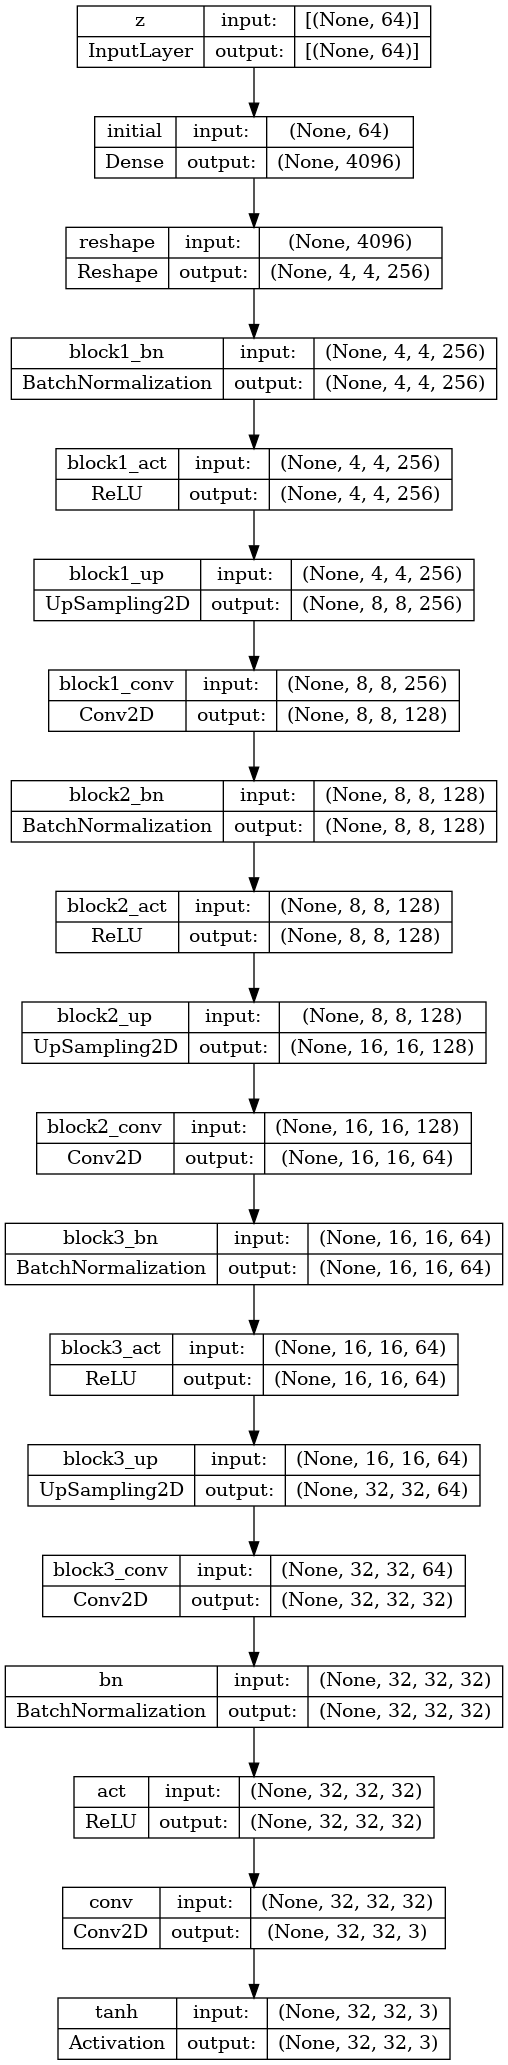

In [27]:
def generator_block(
    x,
    filters,
    name="",
    **kwargs,
):
    x = tfkl.BatchNormalization(name=name + "bn")(x)
    x = tfkl.ReLU(name=name + "act")(x)
    x = tfkl.UpSampling2D(interpolation="bilinear", name=name + "up")(x)
    x = tfkl.Conv2D(filters, 3, padding="same", name=name + "conv")(x)

    return x


def build_generator(
    output_shape,
    latent_dim,
    num_classes,
    filters,
    blocks,
    **kwargs,
):
    assert output_shape[0] % 2**blocks == 0
    assert output_shape[1] % 2**blocks == 0
    initial_h = output_shape[0] // 2**blocks
    initial_w = output_shape[1] // 2**blocks
    initial_c = filters * 2**blocks

    # Latent noise
    z = tfkl.Input(latent_dim, name="z")

    x = tfkl.Dense(initial_h * initial_w * initial_c, name="initial")(z)
    x = tfkl.Reshape((initial_h, initial_w, initial_c), name="reshape")(x)

    for b in range(blocks):
        x = generator_block(
            x, filters=filters * 2 ** (blocks - 1 - b), name="block" + str(b + 1) + "_"
        )

    x = tfkl.BatchNormalization(name="bn")(x)
    x = tfkl.ReLU(name="act")(x)
    x = tfkl.Conv2D(output_shape[-1], 3, padding="same", name="conv")(x)
    x = tfkl.Activation("tanh", name="tanh")(x)

    generator = tfk.Model(inputs=z, outputs=x, name="Generator")

    return generator


gen = build_generator((32, 32, 3), 64, 10, 32, 3)
gen.summary()
tfk.utils.plot_model(gen, show_shapes=True, expand_nested=True)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 32, 32, 11)]      0         
                                                                 
 conv0 (Conv2D)              (None, 32, 32, 32)        3200      
                                                                 
 block1_act2 (ReLU)          (None, 32, 32, 32)        0         
                                                                 
 block1_pool (AveragePooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 block1_conv2 (Conv2D)       (None, 16, 16, 64)        18496     
                                                                 
 block2_act2 (ReLU)          (None, 16, 16, 64)        0         
                                                     

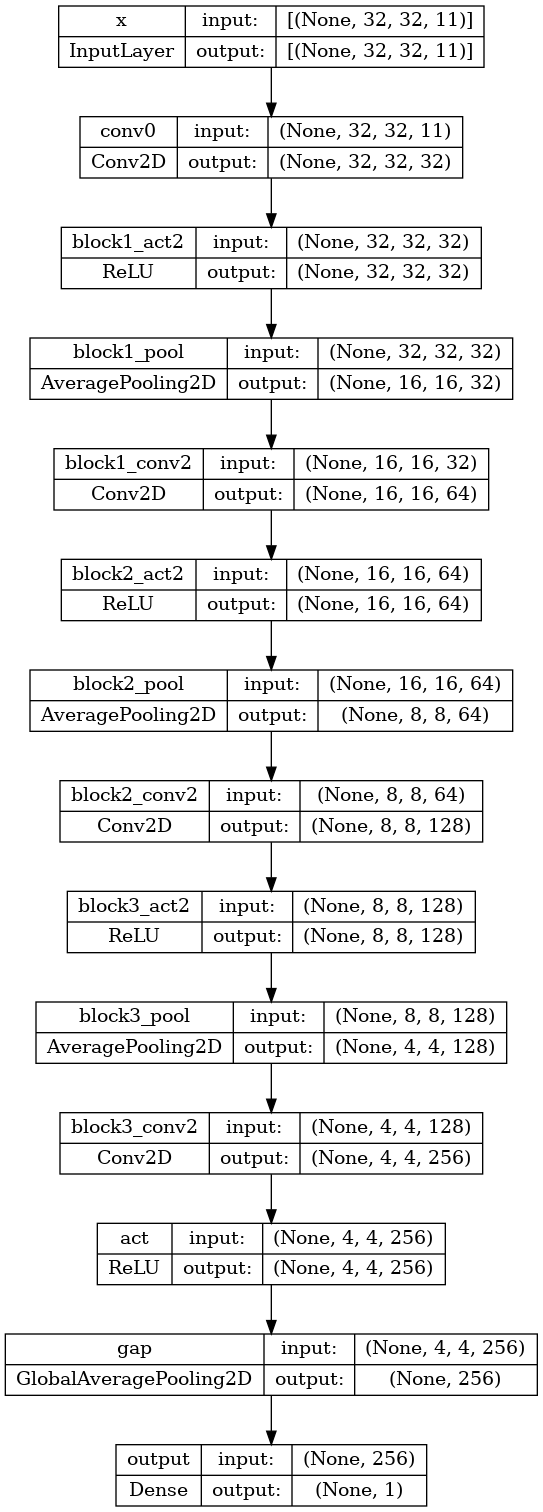

In [28]:
def discriminator_block(
    x,
    filters,
    name="",
    **kwargs,
):
    x = tfkl.ReLU(name=name + "act2")(x)
    x = tfkl.AveragePooling2D(name=name + "pool")(x)
    x = tfkl.Conv2D(filters, 3, padding="same", name=name + "conv2")(x)

    return x


def build_discriminator(input_shape, filters, blocks):
    input_layer = tfkl.Input(input_shape, name="x")
    x = tf.keras.layers.RandomFlip(mode="horizontal")(input_layer)
    x = tfkl.Conv2D(filters, 3, padding="same", name="conv0")(x)

    for b in range(blocks):
        x = discriminator_block(
            x, filters * 2 ** (b + 1), name="block" + str(b + 1) + "_"
        )

    x = tfkl.ReLU(name="act")(x)
    x = tfkl.GlobalAveragePooling2D(name="gap")(x)
    x = tfkl.Dense(1, name="output")(x)

    discriminator = tfk.Model(inputs=input_layer, outputs=x, name="Discriminator")
    return discriminator


disc = build_discriminator((32, 32, 11), 32, 3)
disc.summary()
tfk.utils.plot_model(disc, show_shapes=True, expand_nested=True)

In [44]:
class ConditionalHingeGAN(tfk.Model):
    def __init__(
        self, discriminator, generator, latent_dim, num_classes, discriminator_rounds=1
    ):
        super(ConditionalHingeGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.discriminator_rounds = discriminator_rounds
        self.num_classes = num_classes

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalHingeGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def loss_hinge_dis(self, dis_fake, dis_real):
        loss_real = tf.reduce_mean(tf.nn.relu(1.0 - dis_real))
        loss_fake = tf.reduce_mean(tf.nn.relu(1.0 + dis_fake))
        loss = loss_real + loss_fake
        return loss

    def loss_hinge_gen(self, dis_fake):
        loss = -tf.reduce_mean(dis_fake)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker, self.d_loss_tracker, self.g_loss_tracker]

    def call(self, inputs, training=False):
        return self.generator(inputs)

    @tf.function
    def train_step(self, data):
        real_samples, one_hot_labels = data
        batch_size = tf.shape(real_samples)[0]
        image_size = tf.shape(real_samples)[1]

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, self.num_classes)
        )

        for i in range(self.discriminator_rounds):
            z = tf.random.normal(shape=(batch_size, self.latent_dim))
            generator_input = tf.concat([z, one_hot_labels], axis=-1)
            generated_samples = self.generator(generator_input, training=True)

            double_labels = tf.concat(
                [image_one_hot_labels, image_one_hot_labels], axis=0
            )
            combined_samples = tf.concat([generated_samples, real_samples], axis=0)
            discriminator_input = tf.concat([combined_samples, double_labels], axis=-1)

            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(discriminator_input, training=True)
                D_fake, D_real = tf.split(predictions, [batch_size, batch_size], axis=0)
                d_loss = self.loss_hinge_dis(D_fake, D_real)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        generator_input = tf.concat([z, one_hot_labels], axis=-1)

        # Train the generator
        with tf.GradientTape() as tape:
            generated_samples = self.generator(generator_input, training=True)
            discriminator_input = tf.concat(
                [generated_samples, image_one_hot_labels], axis=-1
            )
            misleading_predictions = self.discriminator(
                discriminator_input, training=True
            )
            g_loss = self.loss_hinge_gen(misleading_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [45]:
class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img, num_classes, latent_dim, name="", gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray
        self.noise = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.labels = tfk.utils.to_categorical(
            tf.math.floormod(tf.range(0, self.num_img), num_classes)
        )

    def on_epoch_end(self, epoch, logs=None):
        generator_input = tf.concat([self.noise, self.labels], axis=-1)
        generated_images = self.model.generator.predict(generator_input, verbose=0)

        fig, axes = plt.subplots(1, self.num_img, figsize=(20, 2 * self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img((generated_images[i] + 1) / 2)
            ax = axes[i % self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap="gray")
            else:
                ax.imshow(np.squeeze(img))
        plt.tight_layout()
        plt.show()

Metadata extraction started...
Metadata extraction completed!
Data processing started...
	 Dataset reshaping started...
	 Dataset reshaping completed!
	 Dataset resizing started...
	 Dataset resizing completed!
	 Dataset normalization started...
	 Dataset normalization completed!
Data processing completed!
Classifier training on real data started...
Epoch 1/100
211/211 - 6s - loss: 1.7038 - accuracy: 0.3694 - val_loss: 1.7220 - val_accuracy: 0.3725 - lr: 0.1000 - 6s/epoch - 29ms/step
Epoch 2/100
211/211 - 4s - loss: 1.4387 - accuracy: 0.4731 - val_loss: 1.4731 - val_accuracy: 0.4633 - lr: 0.1000 - 4s/epoch - 17ms/step
Epoch 3/100
211/211 - 4s - loss: 1.3082 - accuracy: 0.5254 - val_loss: 1.4409 - val_accuracy: 0.4837 - lr: 0.1000 - 4s/epoch - 17ms/step
Epoch 4/100
211/211 - 3s - loss: 1.2216 - accuracy: 0.5653 - val_loss: 1.3133 - val_accuracy: 0.5375 - lr: 0.1000 - 3s/epoch - 14ms/step
Epoch 5/100
211/211 - 3s - loss: 1.1629 - accuracy: 0.5864 - val_loss: 1.2695 - val_accuracy: 0.5508

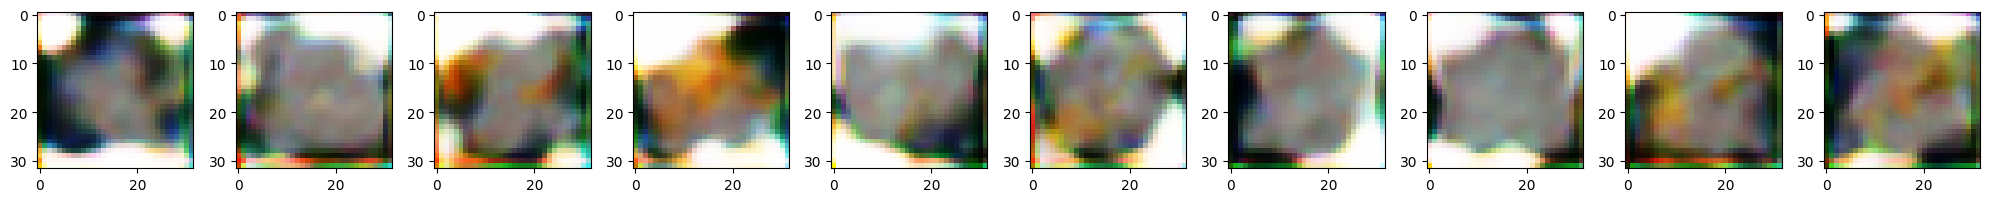

211/211 - 20s - loss: 1.7407 - d_loss: 0.4559 - g_loss: 1.2847 - 20s/epoch - 96ms/step
Epoch 2/100


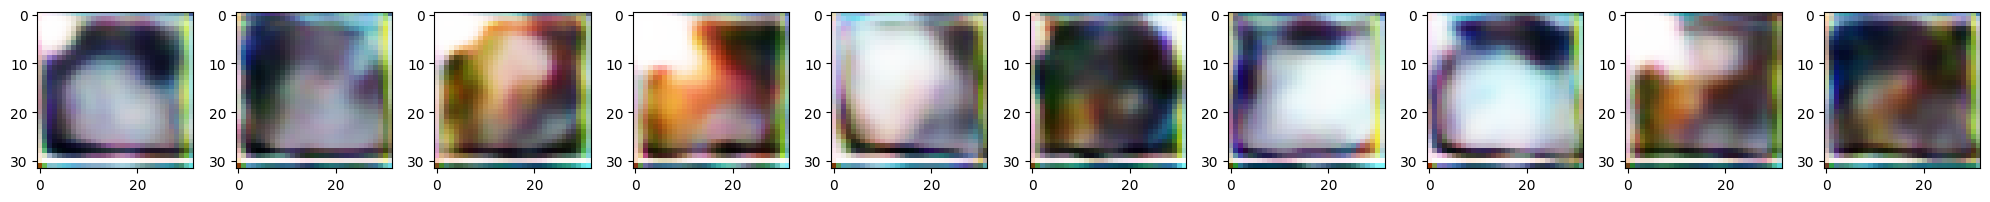

211/211 - 16s - loss: 1.7538 - d_loss: 1.0515 - g_loss: 0.7023 - 16s/epoch - 77ms/step
Epoch 3/100


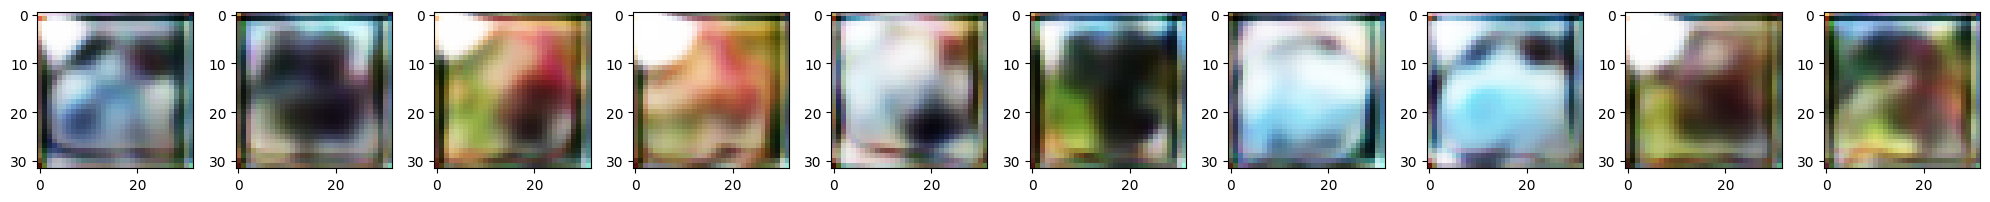

211/211 - 16s - loss: 1.8306 - d_loss: 1.1654 - g_loss: 0.6652 - 16s/epoch - 74ms/step
Epoch 4/100


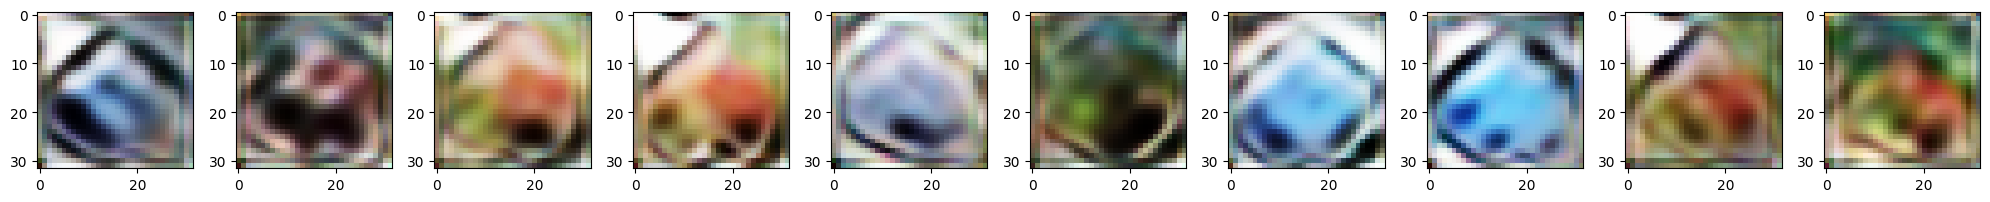

211/211 - 16s - loss: 1.7693 - d_loss: 1.1059 - g_loss: 0.6634 - 16s/epoch - 75ms/step
Epoch 5/100


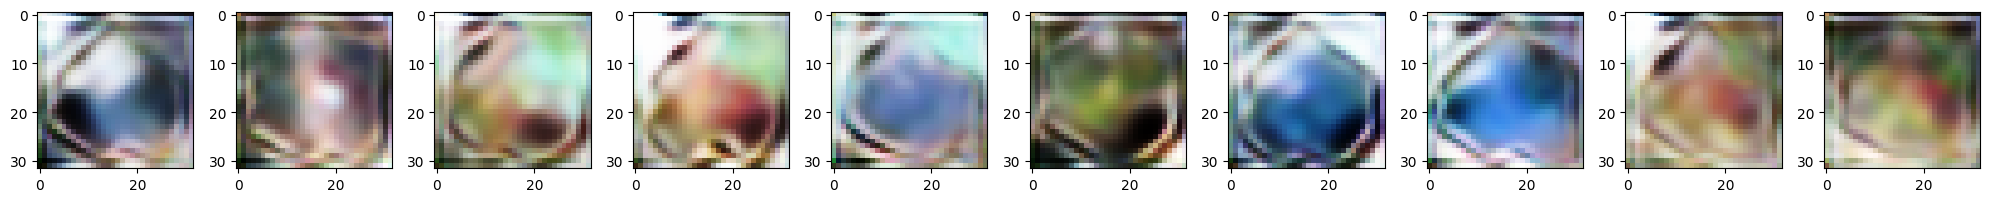

211/211 - 15s - loss: 1.7514 - d_loss: 1.0616 - g_loss: 0.6898 - 15s/epoch - 72ms/step
Epoch 6/100


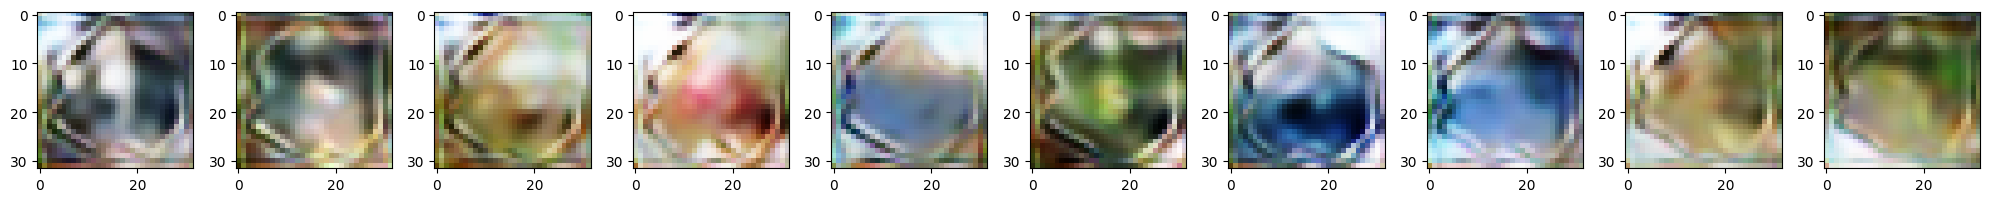

211/211 - 16s - loss: 1.9032 - d_loss: 1.2679 - g_loss: 0.6353 - 16s/epoch - 74ms/step
Epoch 7/100


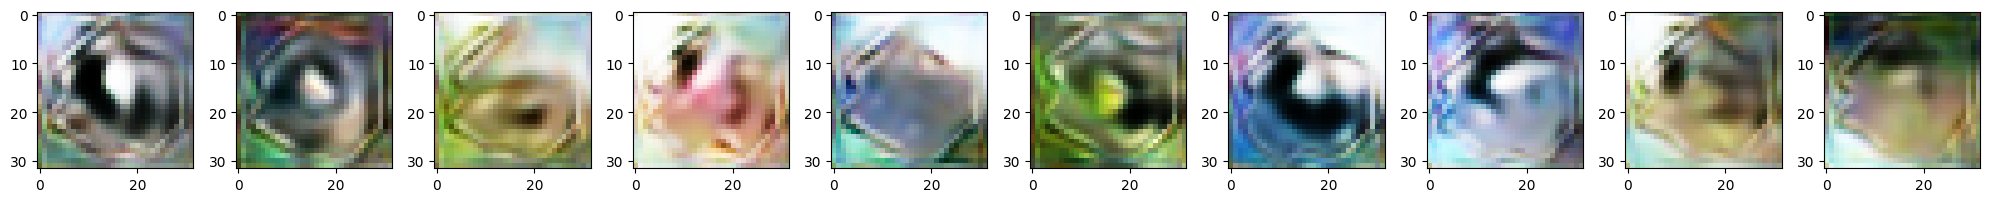

211/211 - 16s - loss: 1.9986 - d_loss: 1.4392 - g_loss: 0.5594 - 16s/epoch - 77ms/step
Epoch 8/100


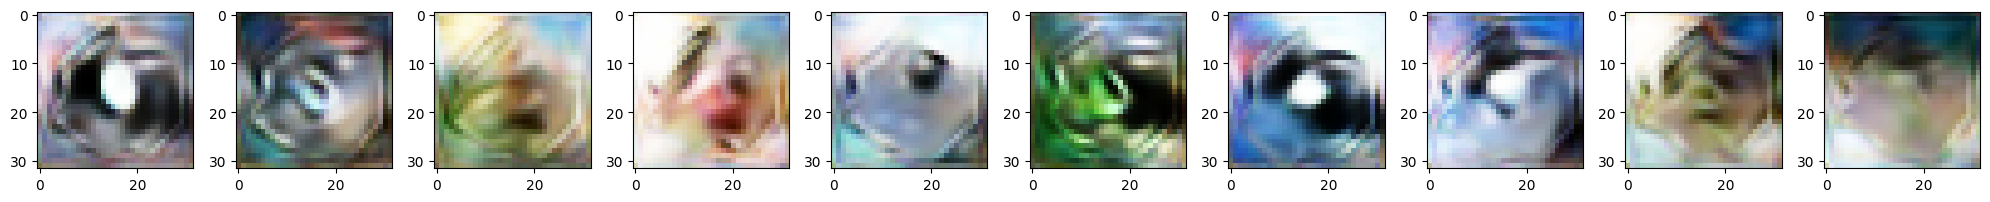

211/211 - 16s - loss: 2.0726 - d_loss: 1.6385 - g_loss: 0.4341 - 16s/epoch - 76ms/step
Epoch 9/100


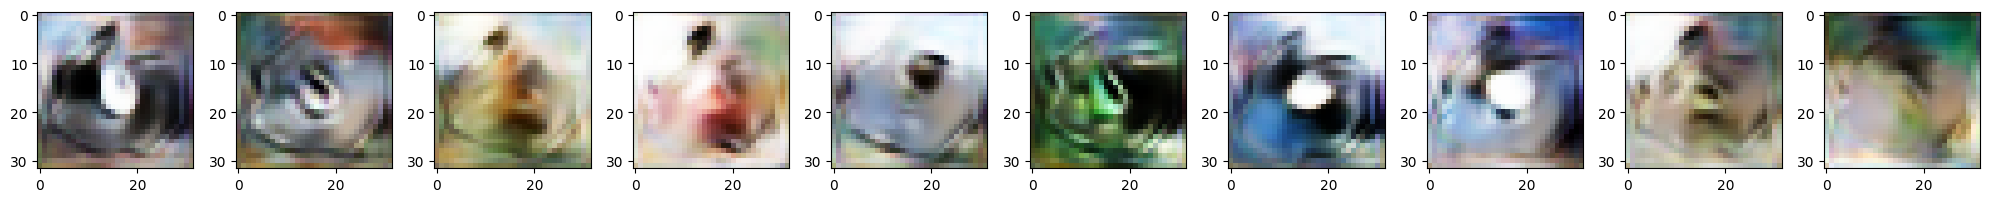

211/211 - 16s - loss: 2.0312 - d_loss: 1.6922 - g_loss: 0.3390 - 16s/epoch - 74ms/step
Epoch 10/100


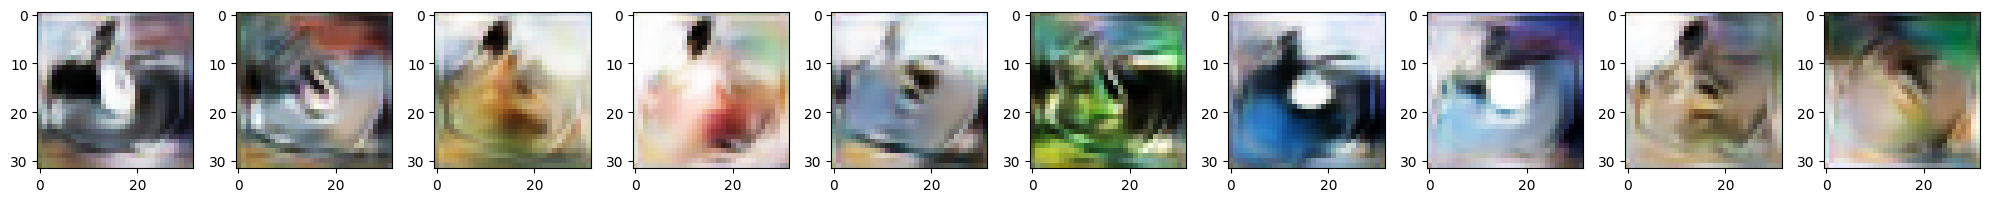

211/211 - 16s - loss: 2.0970 - d_loss: 1.7034 - g_loss: 0.3936 - 16s/epoch - 75ms/step
Epoch 11/100


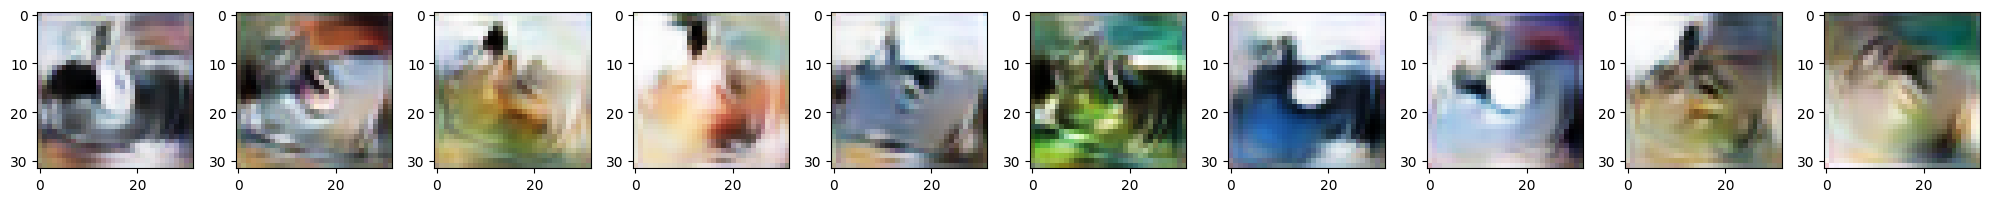

211/211 - 16s - loss: 2.1126 - d_loss: 1.7129 - g_loss: 0.3998 - 16s/epoch - 77ms/step
Epoch 12/100


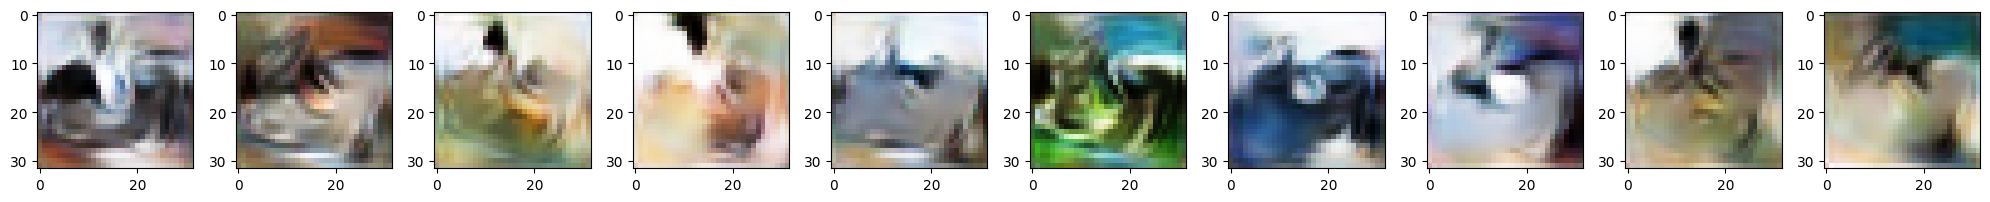

211/211 - 15s - loss: 2.1283 - d_loss: 1.6714 - g_loss: 0.4569 - 15s/epoch - 72ms/step
Epoch 13/100


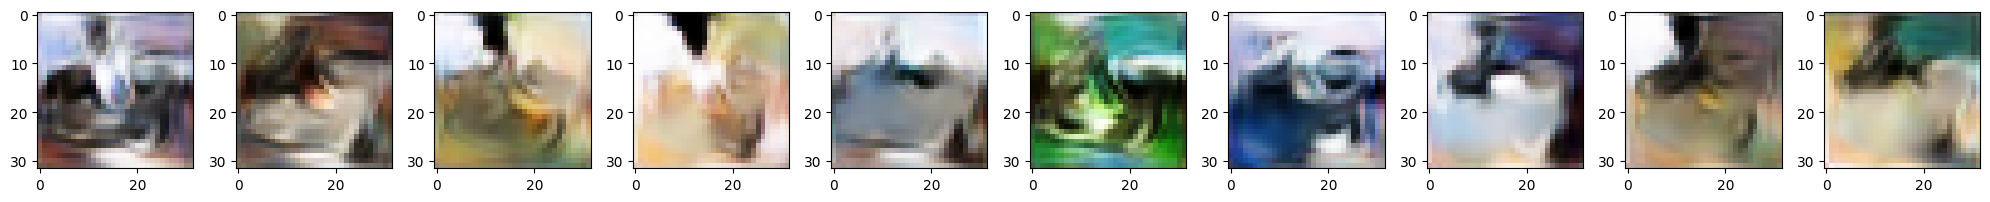

211/211 - 15s - loss: 2.0835 - d_loss: 1.6850 - g_loss: 0.3985 - 15s/epoch - 72ms/step
Epoch 14/100


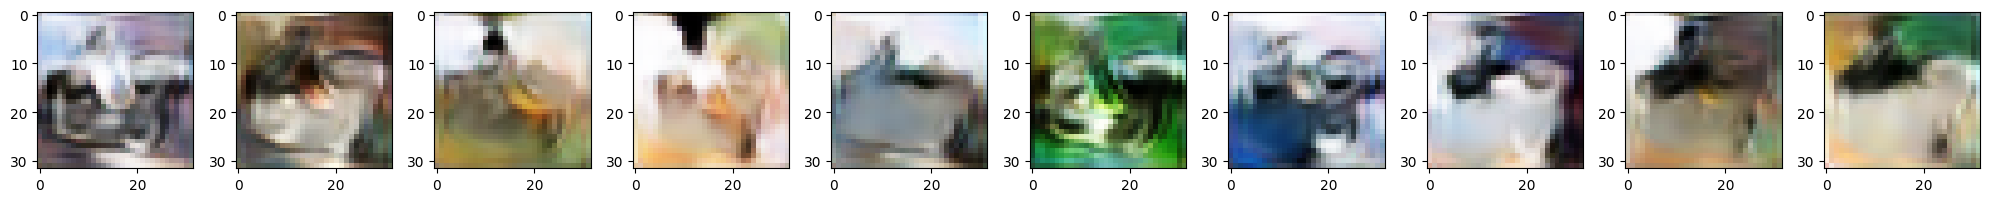

211/211 - 15s - loss: 2.0692 - d_loss: 1.6719 - g_loss: 0.3973 - 15s/epoch - 70ms/step
Epoch 15/100


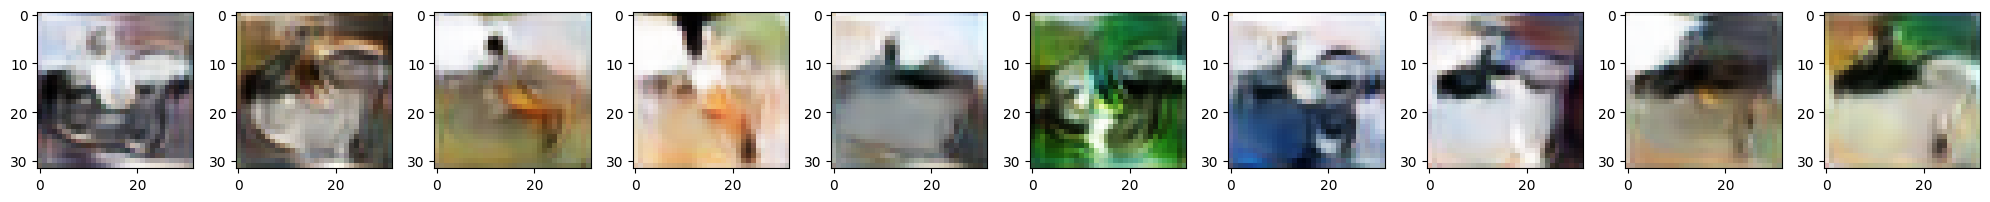

211/211 - 15s - loss: 2.1249 - d_loss: 1.6705 - g_loss: 0.4543 - 15s/epoch - 73ms/step
Epoch 16/100


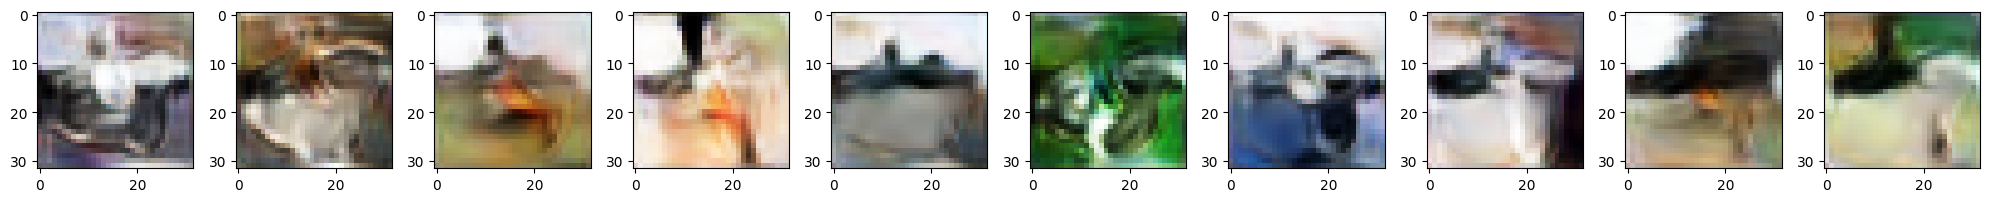

211/211 - 15s - loss: 2.0605 - d_loss: 1.6433 - g_loss: 0.4171 - 15s/epoch - 70ms/step
Epoch 17/100


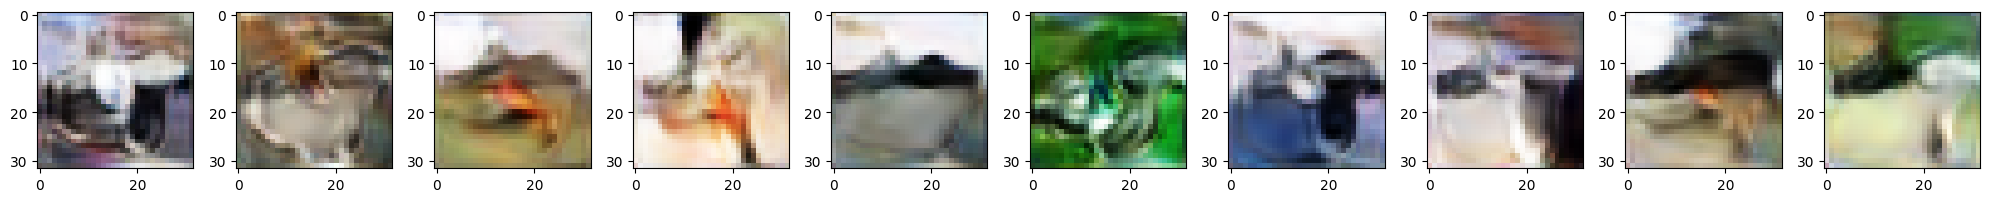

211/211 - 14s - loss: 2.0952 - d_loss: 1.6499 - g_loss: 0.4453 - 14s/epoch - 69ms/step
Epoch 18/100


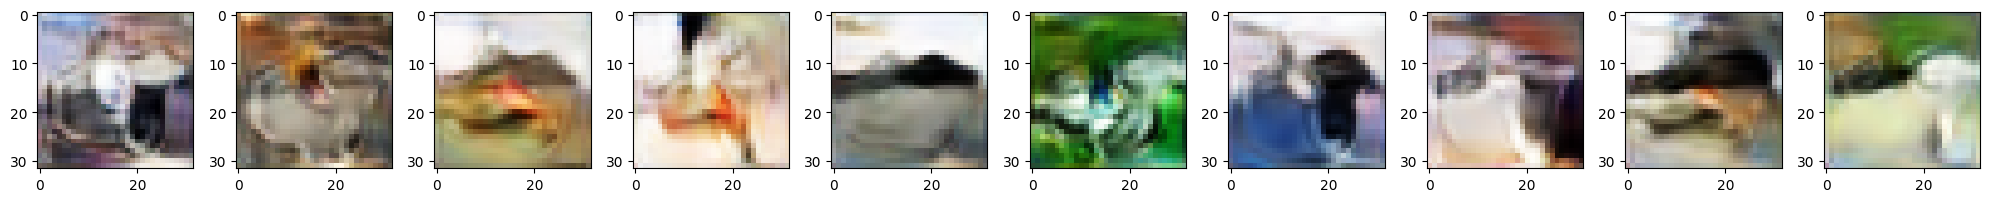

211/211 - 13s - loss: 2.1525 - d_loss: 1.6822 - g_loss: 0.4703 - 13s/epoch - 60ms/step
Epoch 19/100


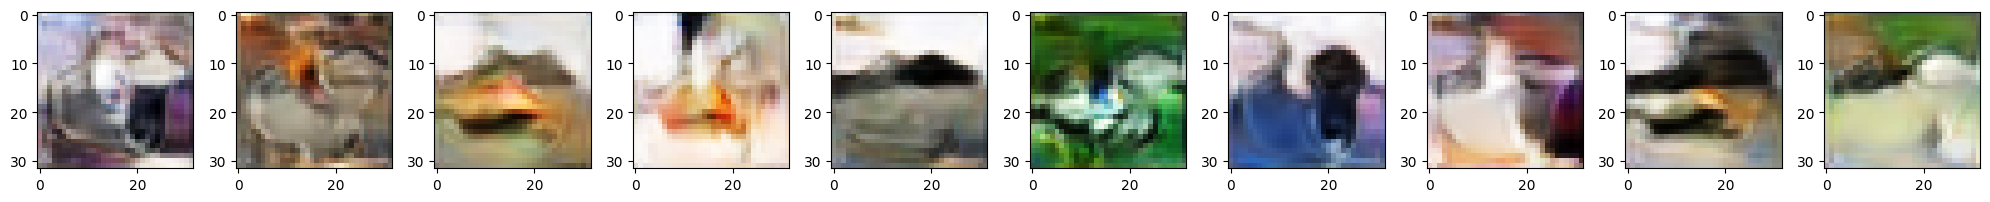

211/211 - 13s - loss: 2.1422 - d_loss: 1.6969 - g_loss: 0.4453 - 13s/epoch - 60ms/step
Epoch 20/100


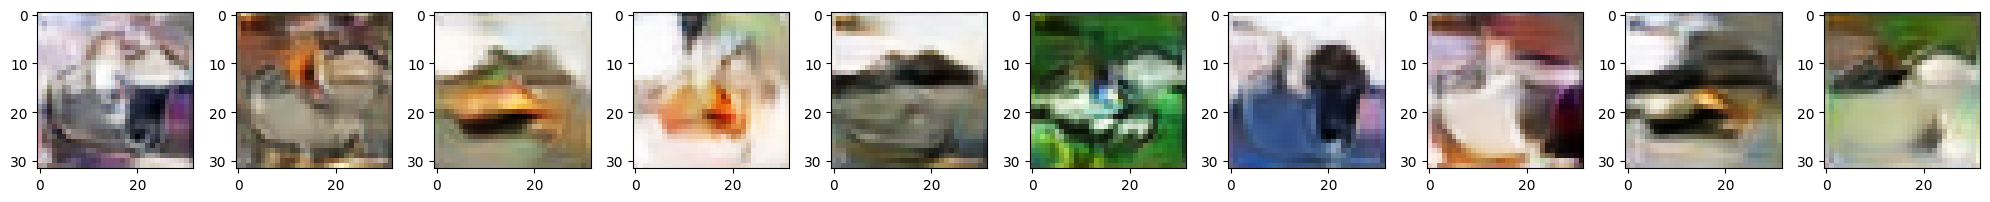

211/211 - 13s - loss: 2.1043 - d_loss: 1.6787 - g_loss: 0.4255 - 13s/epoch - 63ms/step
Epoch 21/100


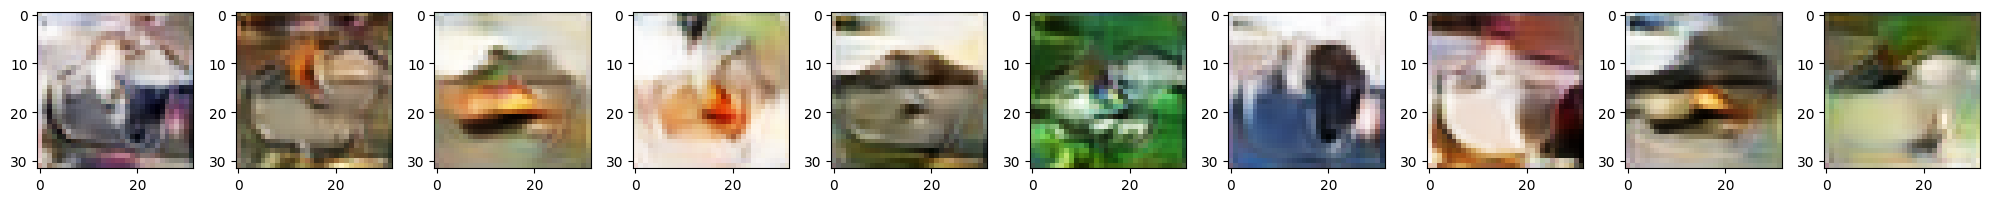

211/211 - 13s - loss: 2.0957 - d_loss: 1.6866 - g_loss: 0.4091 - 13s/epoch - 60ms/step
Epoch 22/100


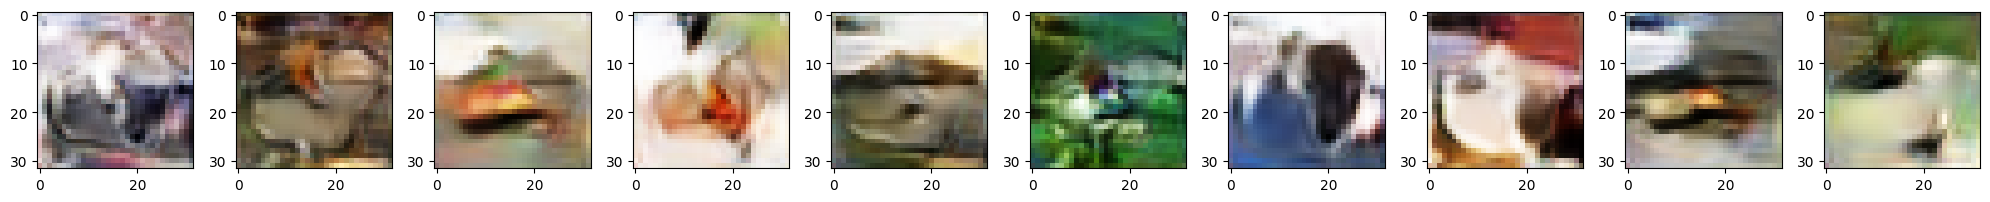

211/211 - 13s - loss: 2.1010 - d_loss: 1.7097 - g_loss: 0.3914 - 13s/epoch - 60ms/step
Epoch 23/100


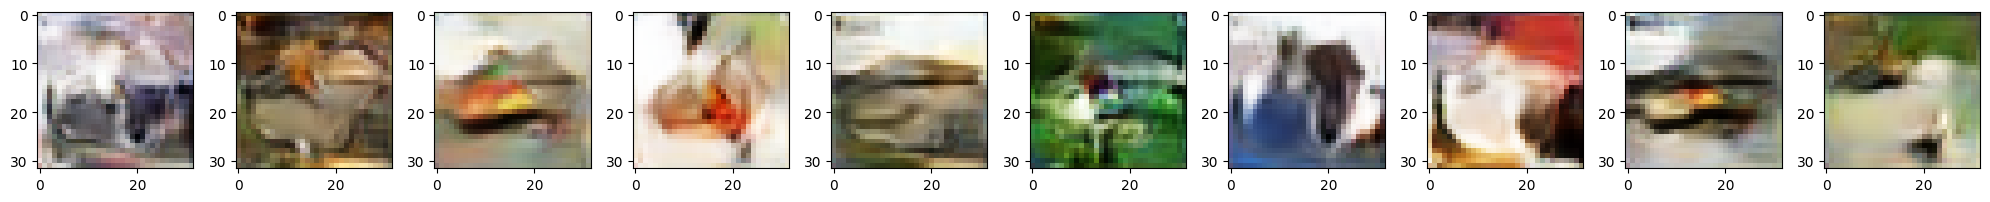

211/211 - 13s - loss: 2.1026 - d_loss: 1.7045 - g_loss: 0.3981 - 13s/epoch - 60ms/step
Epoch 24/100


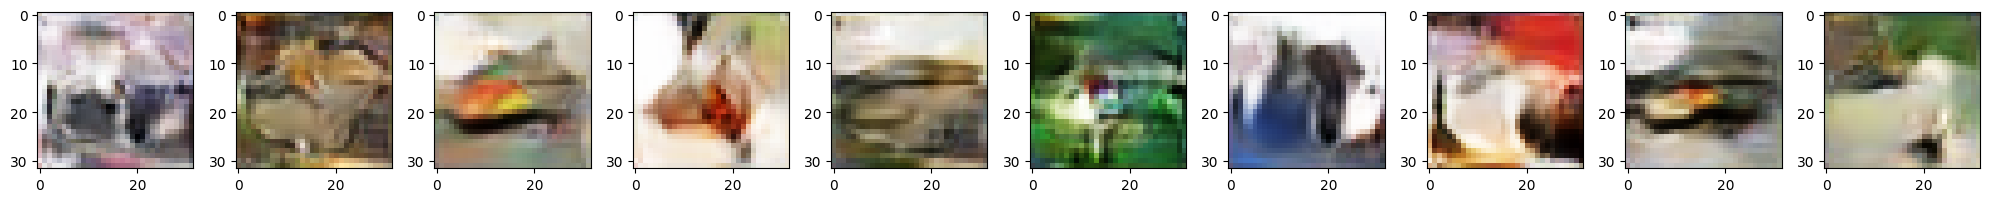

211/211 - 13s - loss: 2.1840 - d_loss: 1.7101 - g_loss: 0.4739 - 13s/epoch - 60ms/step
Epoch 25/100


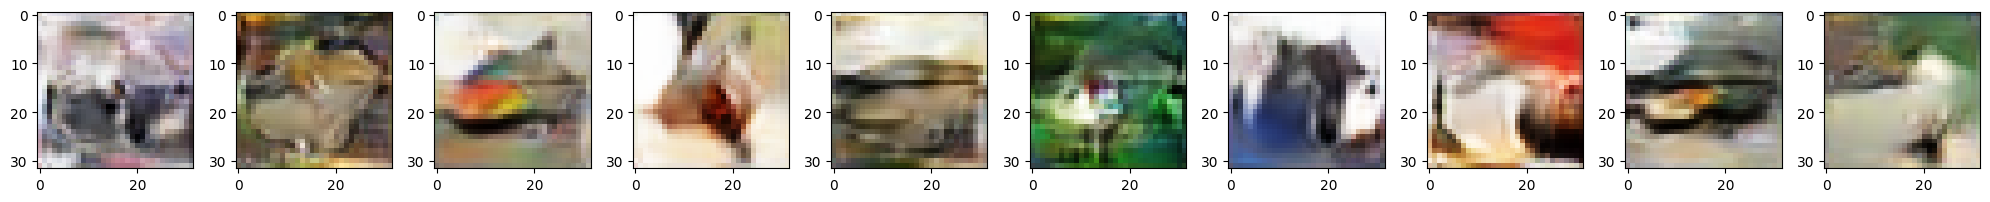

211/211 - 13s - loss: 2.1370 - d_loss: 1.7074 - g_loss: 0.4296 - 13s/epoch - 60ms/step
Epoch 26/100


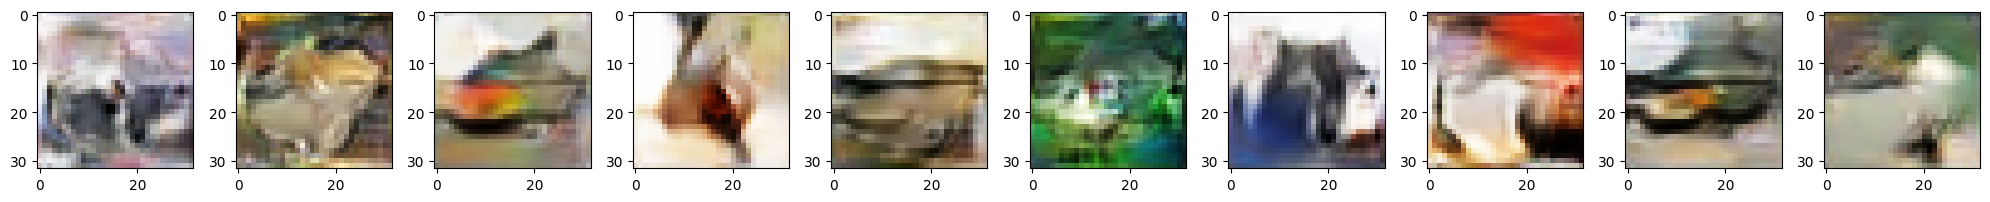

211/211 - 13s - loss: 2.1246 - d_loss: 1.7021 - g_loss: 0.4226 - 13s/epoch - 60ms/step
Epoch 27/100


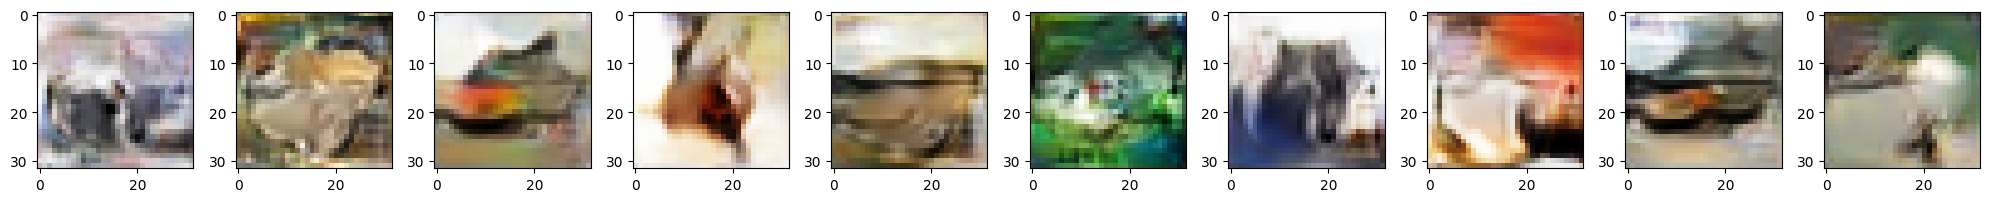

211/211 - 13s - loss: 2.1093 - d_loss: 1.6985 - g_loss: 0.4108 - 13s/epoch - 60ms/step
Epoch 28/100


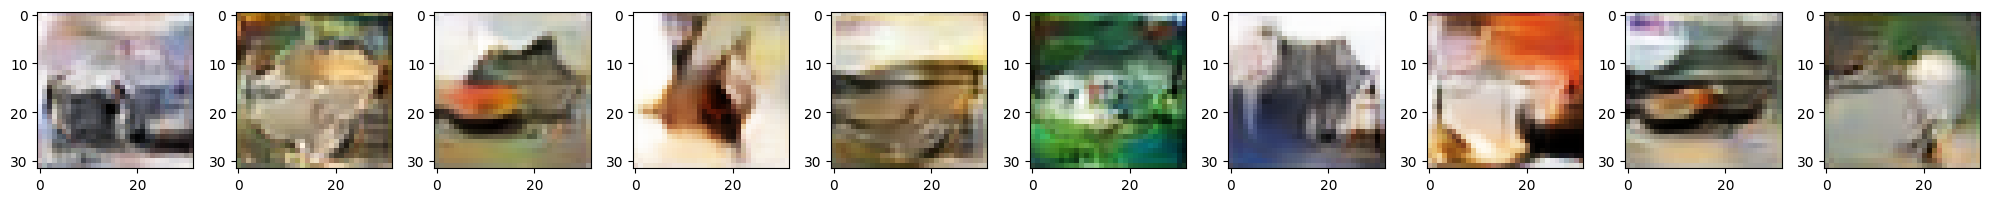

211/211 - 13s - loss: 2.1313 - d_loss: 1.7089 - g_loss: 0.4224 - 13s/epoch - 60ms/step
Epoch 29/100


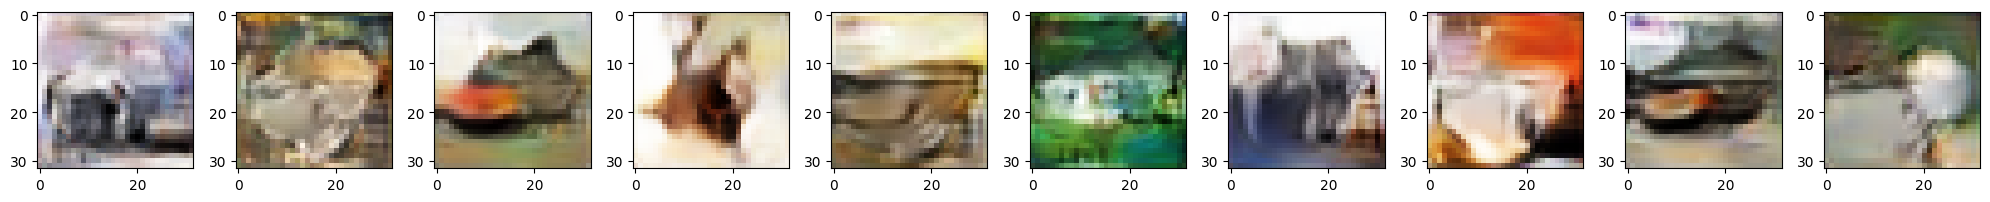

211/211 - 12s - loss: 2.1208 - d_loss: 1.6896 - g_loss: 0.4312 - 12s/epoch - 58ms/step
Epoch 30/100


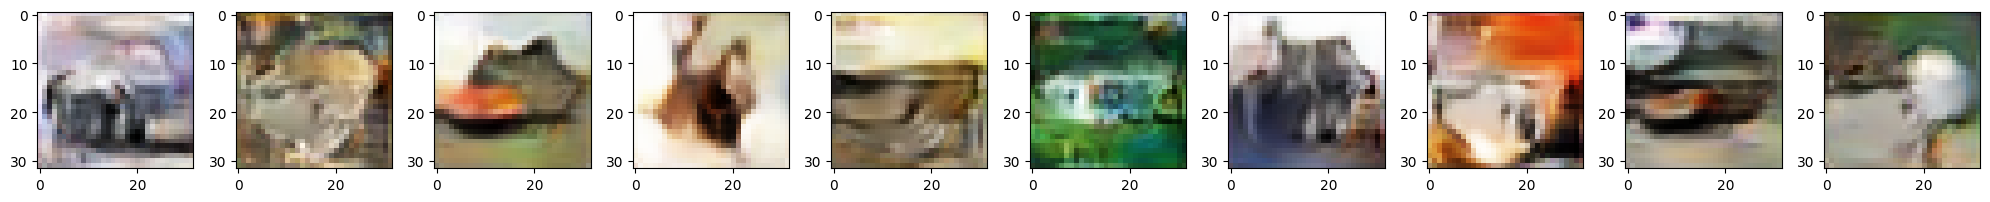

211/211 - 12s - loss: 2.1203 - d_loss: 1.6982 - g_loss: 0.4220 - 12s/epoch - 56ms/step
Epoch 31/100


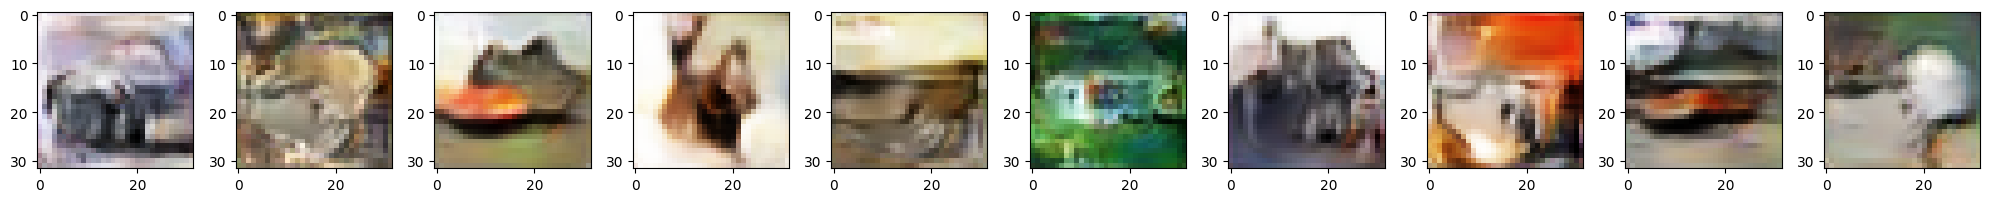

211/211 - 12s - loss: 2.0957 - d_loss: 1.6822 - g_loss: 0.4135 - 12s/epoch - 59ms/step
Epoch 32/100


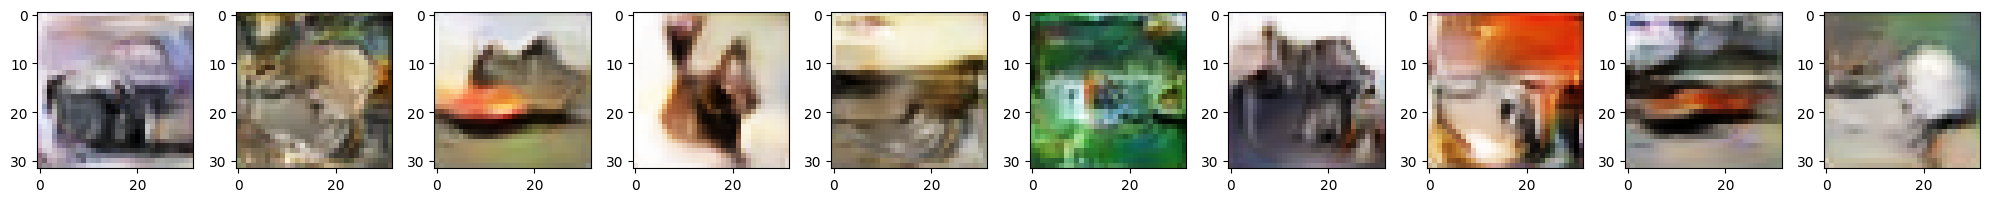

211/211 - 15s - loss: 2.0887 - d_loss: 1.6792 - g_loss: 0.4095 - 15s/epoch - 72ms/step
Epoch 33/100


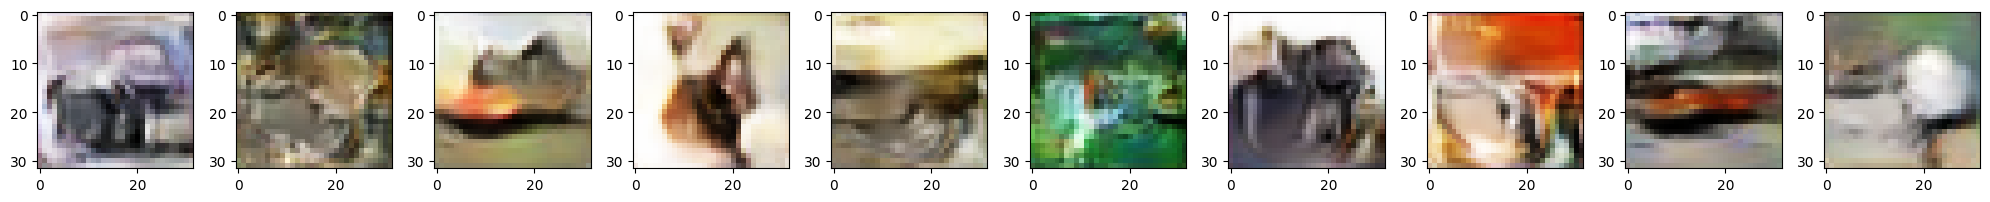

211/211 - 15s - loss: 2.0661 - d_loss: 1.6817 - g_loss: 0.3843 - 15s/epoch - 73ms/step
Epoch 34/100


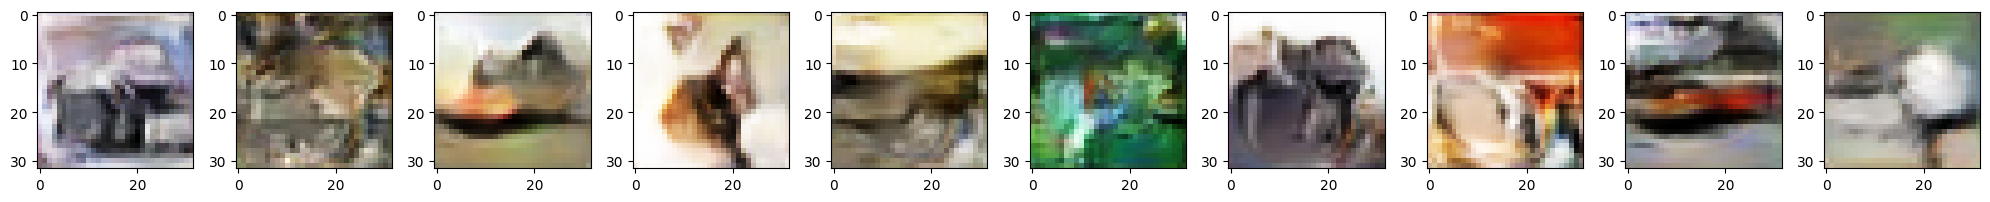

211/211 - 14s - loss: 2.1103 - d_loss: 1.6966 - g_loss: 0.4137 - 14s/epoch - 68ms/step
Epoch 35/100


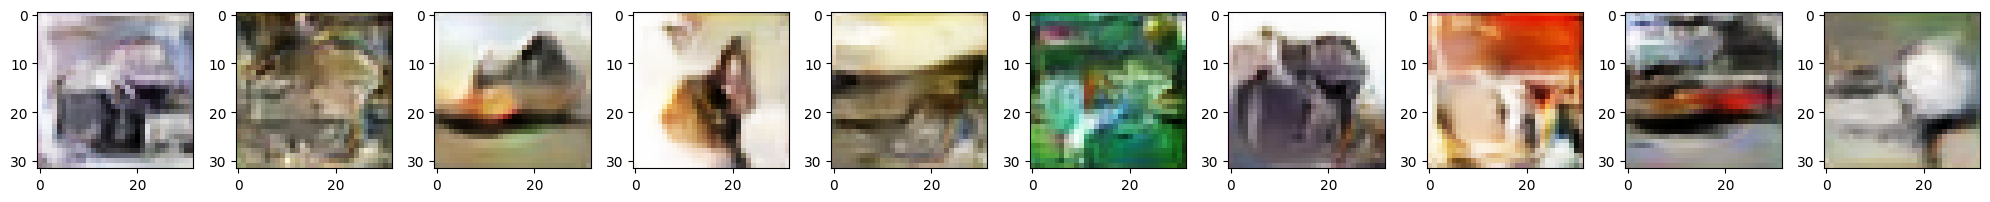

211/211 - 15s - loss: 2.1573 - d_loss: 1.6997 - g_loss: 0.4576 - 15s/epoch - 72ms/step
Epoch 36/100


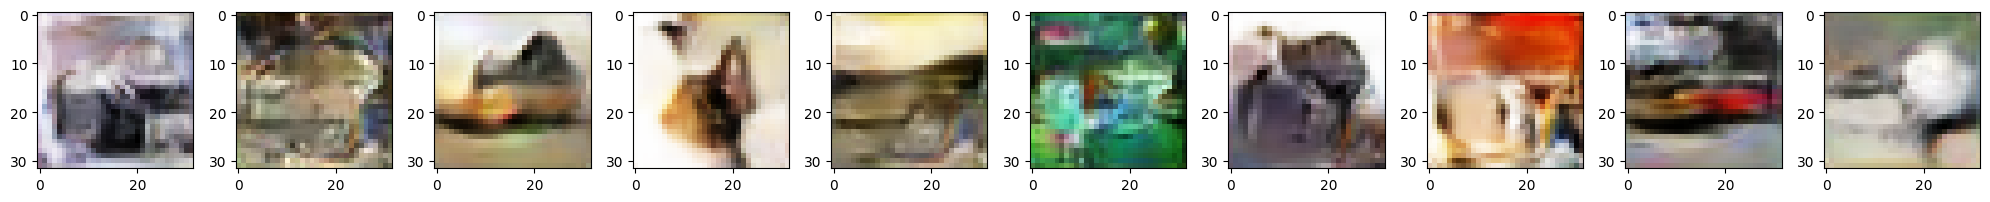

211/211 - 12s - loss: 2.0924 - d_loss: 1.6908 - g_loss: 0.4016 - 12s/epoch - 56ms/step
Epoch 37/100


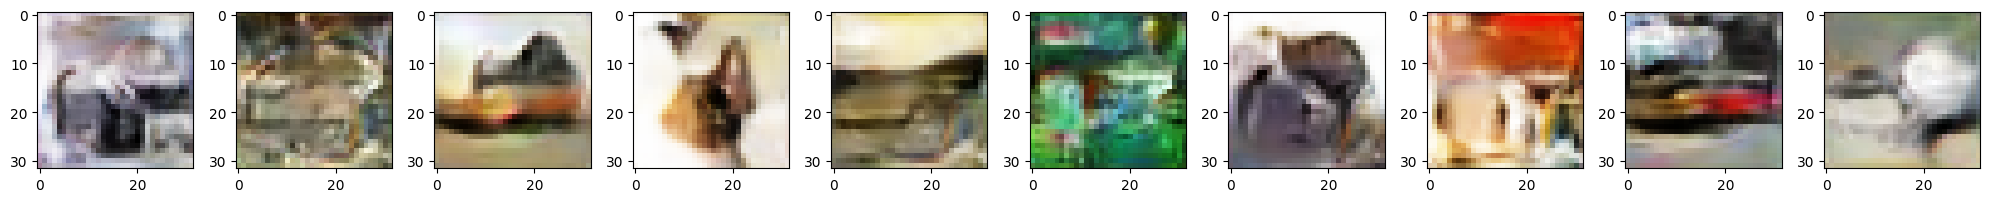

211/211 - 12s - loss: 2.1532 - d_loss: 1.7023 - g_loss: 0.4509 - 12s/epoch - 55ms/step
Epoch 38/100


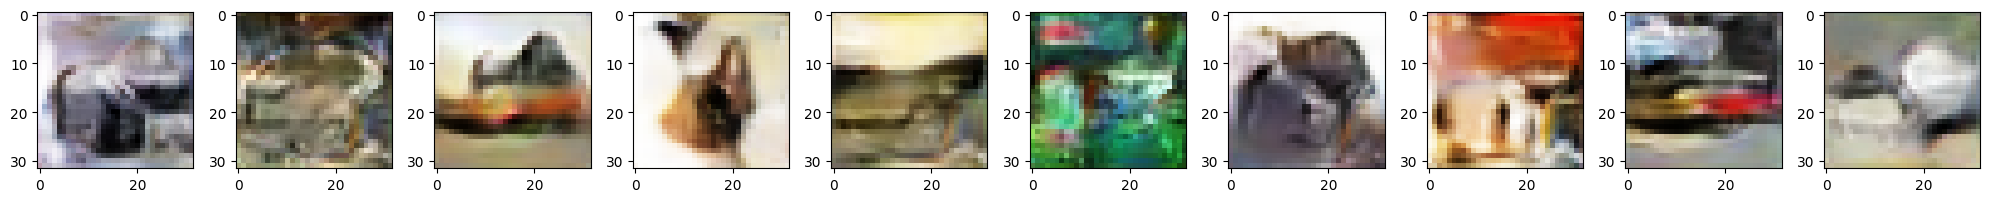

211/211 - 13s - loss: 2.1872 - d_loss: 1.7044 - g_loss: 0.4828 - 13s/epoch - 60ms/step
Epoch 39/100


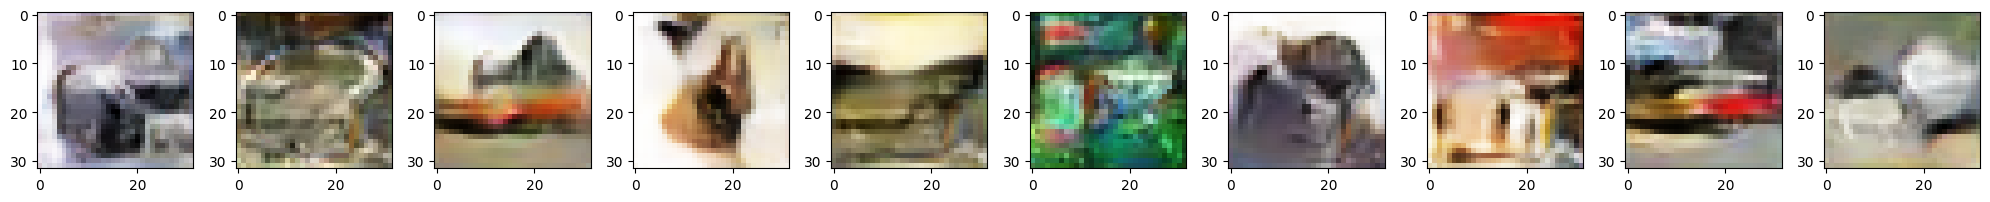

211/211 - 23s - loss: 2.1079 - d_loss: 1.6990 - g_loss: 0.4089 - 23s/epoch - 108ms/step
Epoch 40/100


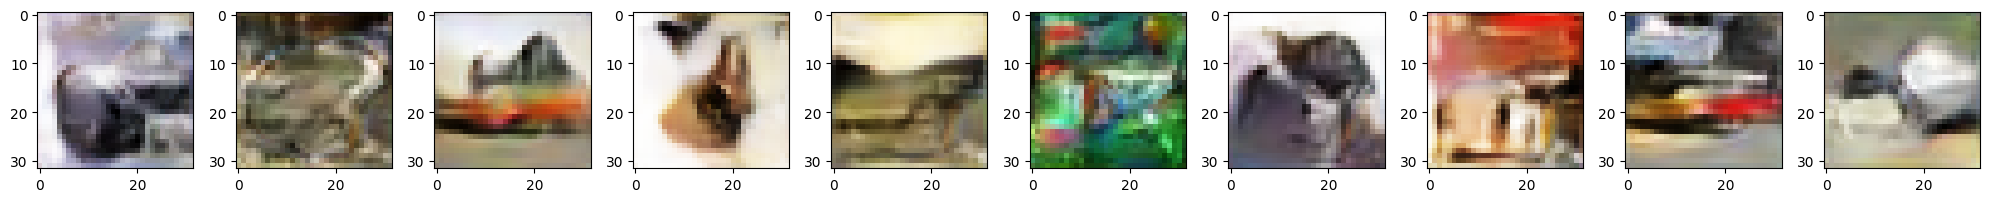

211/211 - 23s - loss: 2.0869 - d_loss: 1.6988 - g_loss: 0.3881 - 23s/epoch - 109ms/step
Epoch 41/100


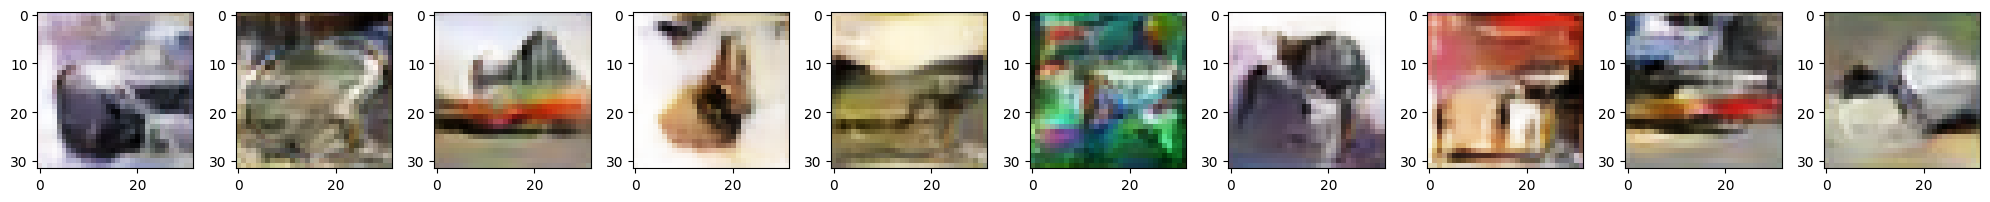

211/211 - 23s - loss: 2.1453 - d_loss: 1.7022 - g_loss: 0.4431 - 23s/epoch - 109ms/step
Epoch 42/100


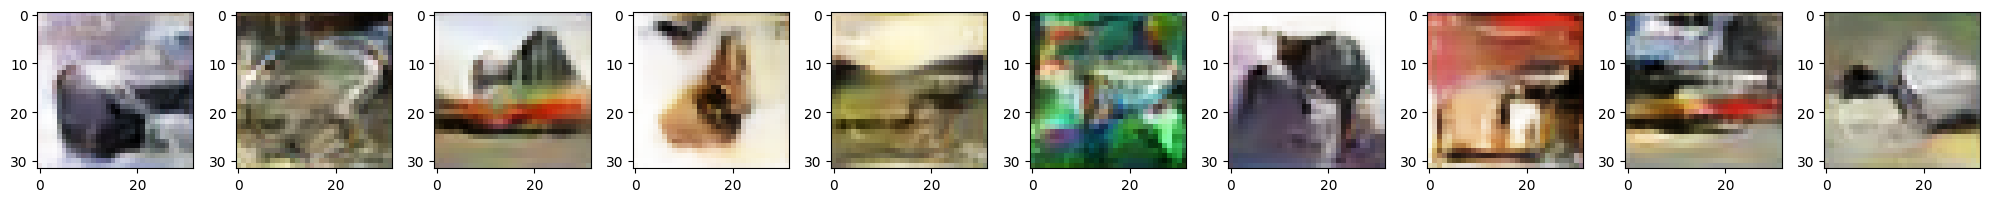

211/211 - 23s - loss: 2.1320 - d_loss: 1.6957 - g_loss: 0.4362 - 23s/epoch - 109ms/step
Epoch 43/100


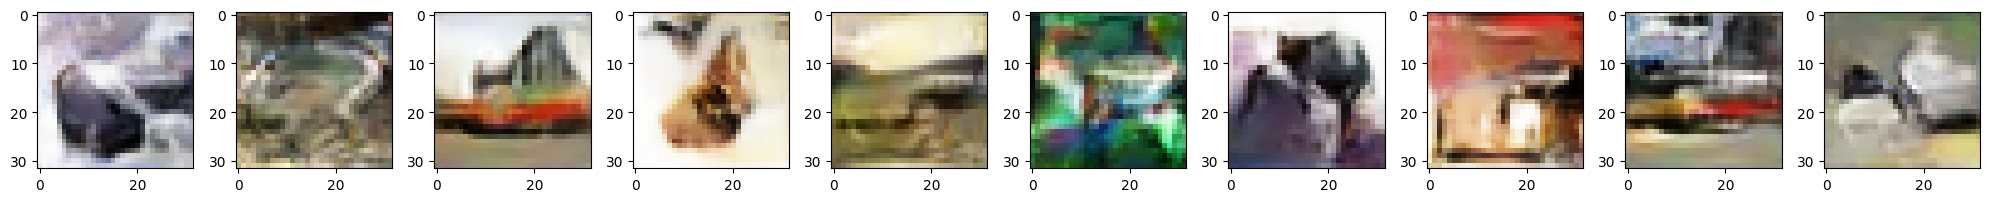

211/211 - 23s - loss: 2.1023 - d_loss: 1.6923 - g_loss: 0.4100 - 23s/epoch - 109ms/step
Epoch 44/100


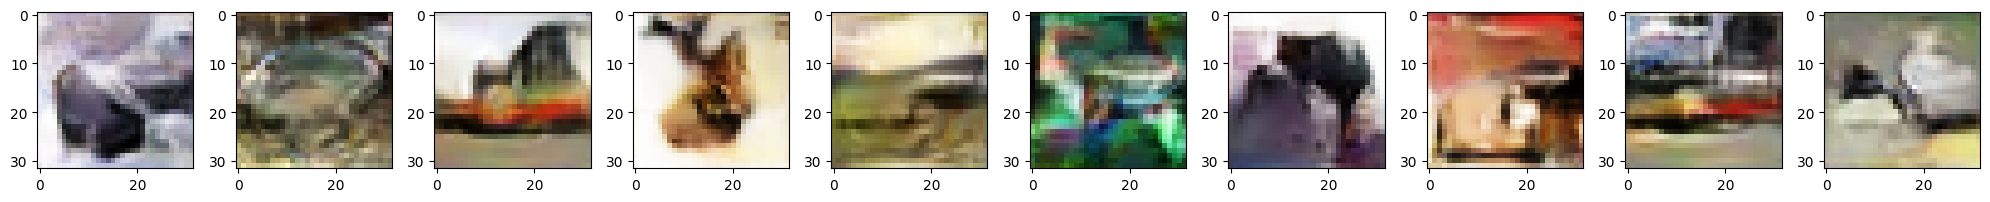

211/211 - 23s - loss: 2.1112 - d_loss: 1.6800 - g_loss: 0.4313 - 23s/epoch - 108ms/step
Epoch 45/100


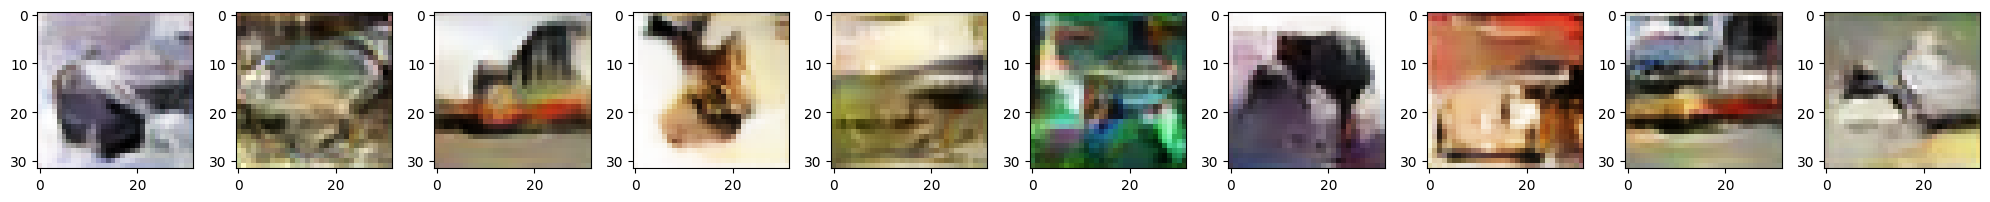

211/211 - 23s - loss: 2.1040 - d_loss: 1.6786 - g_loss: 0.4254 - 23s/epoch - 109ms/step
Epoch 46/100


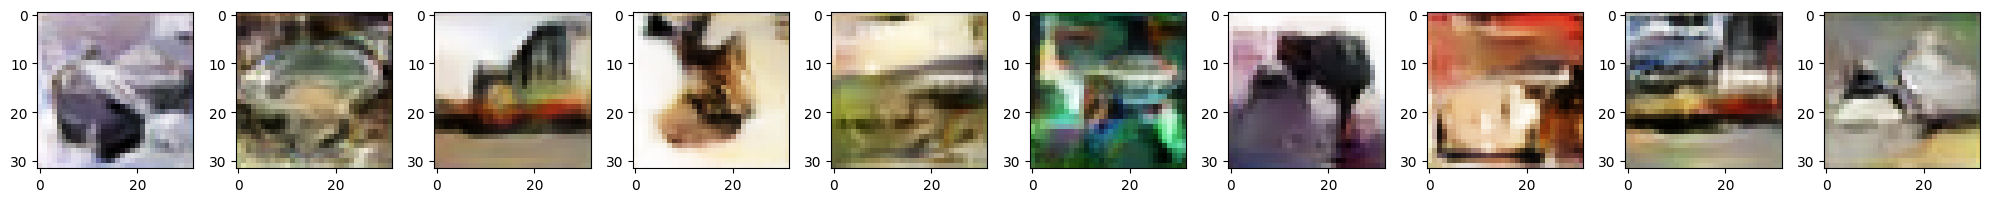

211/211 - 20s - loss: 2.1160 - d_loss: 1.6814 - g_loss: 0.4346 - 20s/epoch - 96ms/step
Epoch 47/100


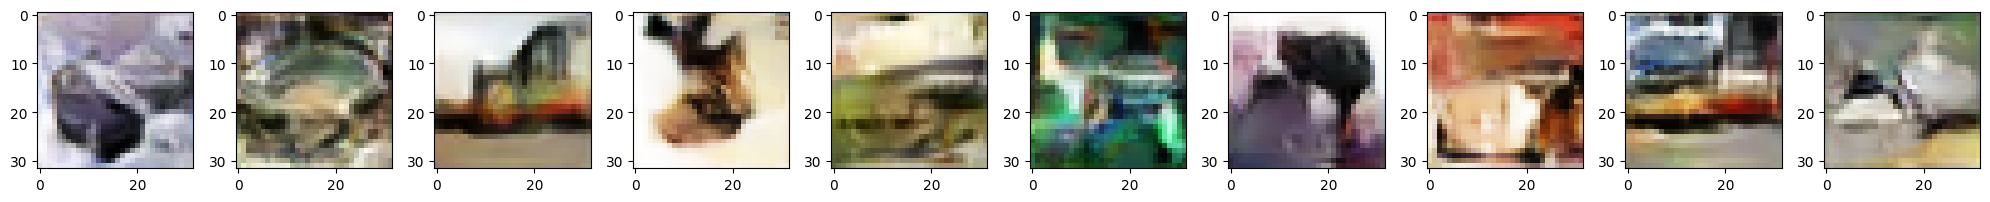

211/211 - 23s - loss: 2.1809 - d_loss: 1.6905 - g_loss: 0.4905 - 23s/epoch - 111ms/step
Epoch 48/100


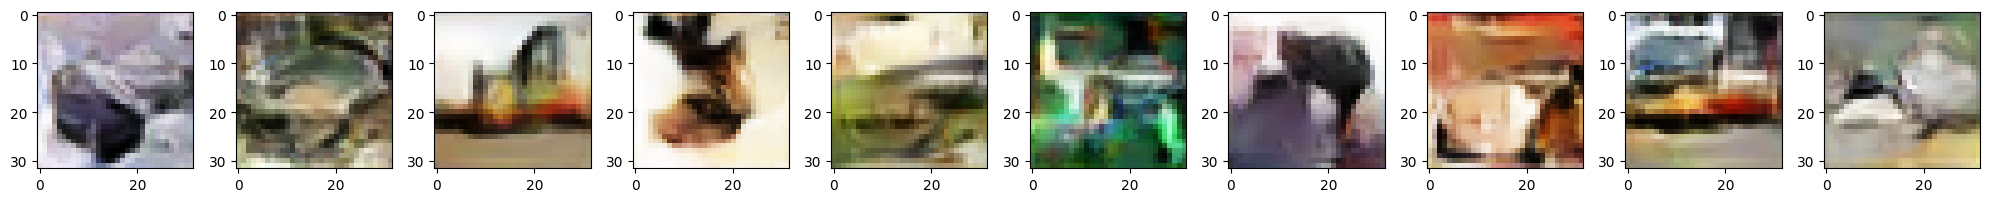

211/211 - 23s - loss: 2.1874 - d_loss: 1.6914 - g_loss: 0.4960 - 23s/epoch - 109ms/step
Epoch 49/100


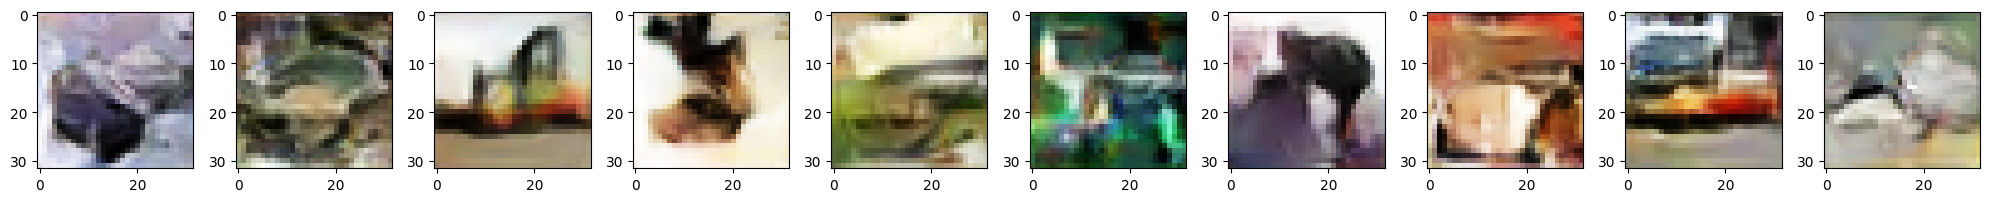

211/211 - 23s - loss: 2.1083 - d_loss: 1.6978 - g_loss: 0.4105 - 23s/epoch - 111ms/step
Epoch 50/100


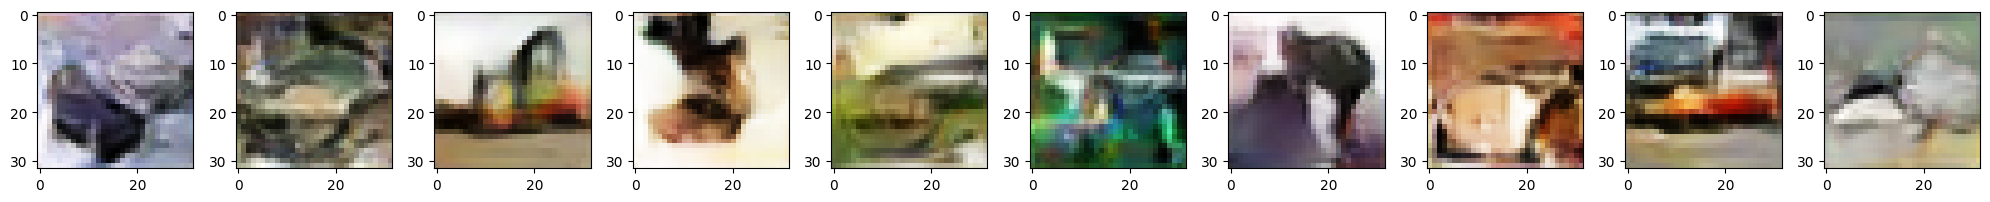

211/211 - 23s - loss: 2.0991 - d_loss: 1.6943 - g_loss: 0.4048 - 23s/epoch - 110ms/step
Epoch 51/100


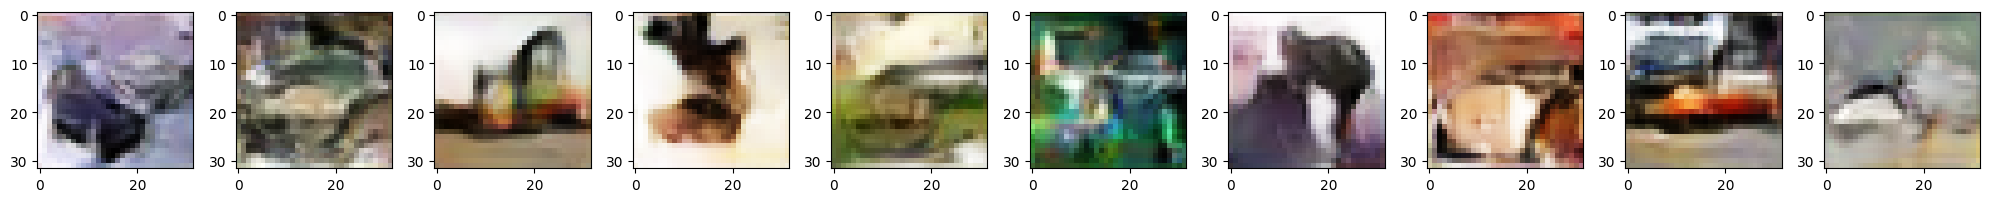

211/211 - 23s - loss: 2.1664 - d_loss: 1.6957 - g_loss: 0.4706 - 23s/epoch - 108ms/step
Epoch 52/100


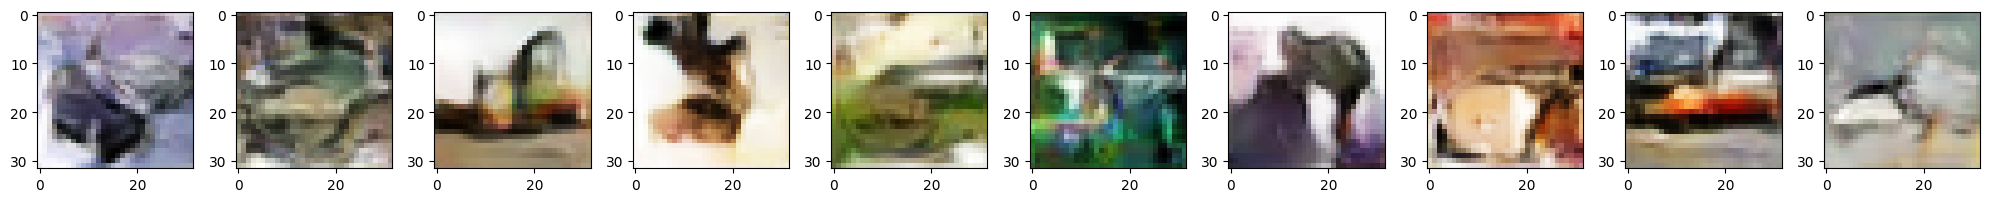

211/211 - 23s - loss: 2.1315 - d_loss: 1.6842 - g_loss: 0.4473 - 23s/epoch - 110ms/step
Epoch 53/100


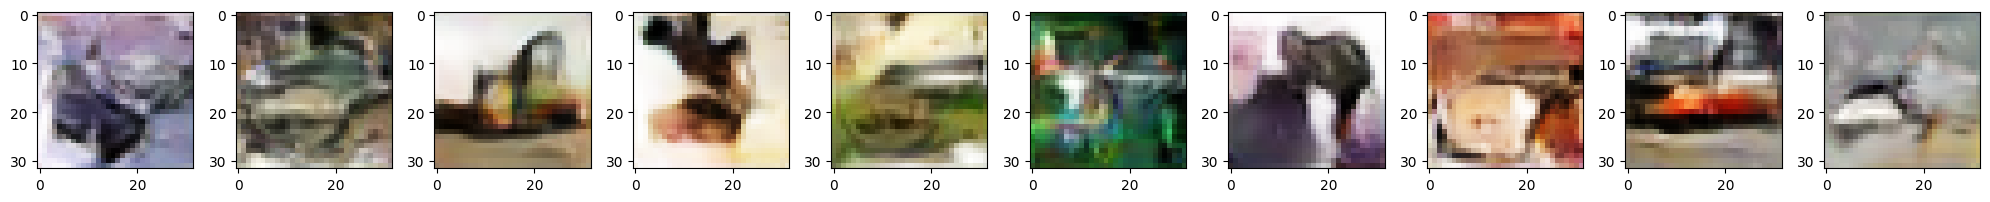

211/211 - 23s - loss: 2.1454 - d_loss: 1.6861 - g_loss: 0.4592 - 23s/epoch - 109ms/step
Epoch 54/100


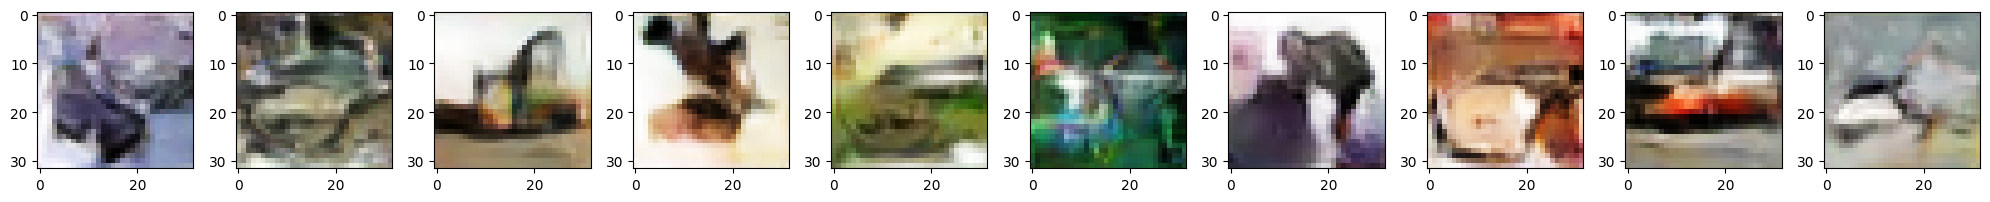

211/211 - 20s - loss: 2.0675 - d_loss: 1.6761 - g_loss: 0.3913 - 20s/epoch - 95ms/step
Epoch 55/100


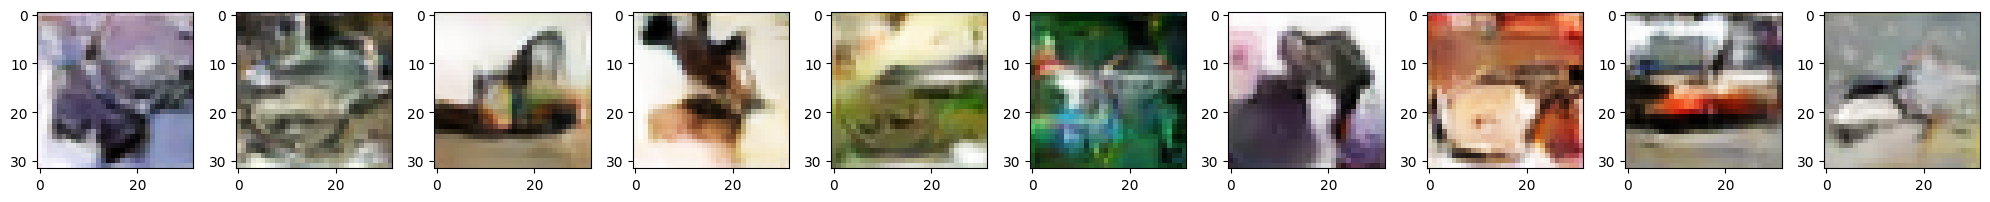

211/211 - 23s - loss: 2.1084 - d_loss: 1.6796 - g_loss: 0.4287 - 23s/epoch - 109ms/step
Epoch 56/100


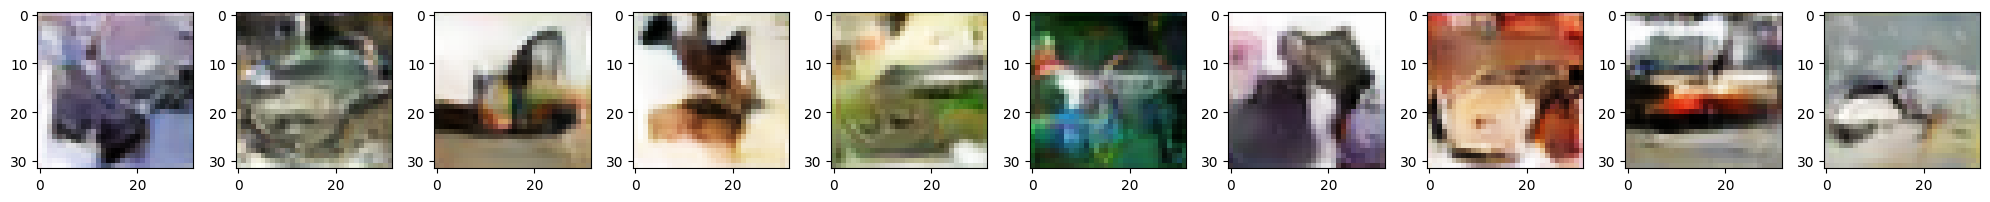

211/211 - 24s - loss: 2.1235 - d_loss: 1.6797 - g_loss: 0.4438 - 24s/epoch - 112ms/step
Epoch 57/100


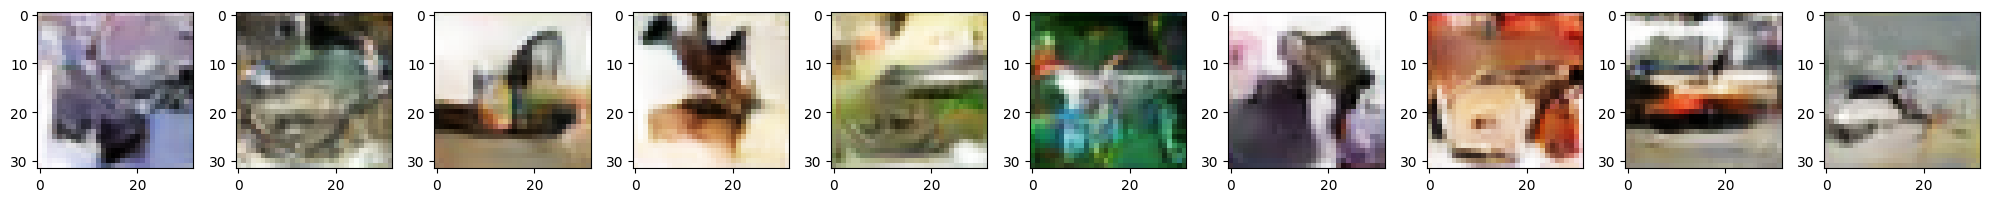

211/211 - 23s - loss: 2.1063 - d_loss: 1.6766 - g_loss: 0.4297 - 23s/epoch - 108ms/step
Epoch 58/100


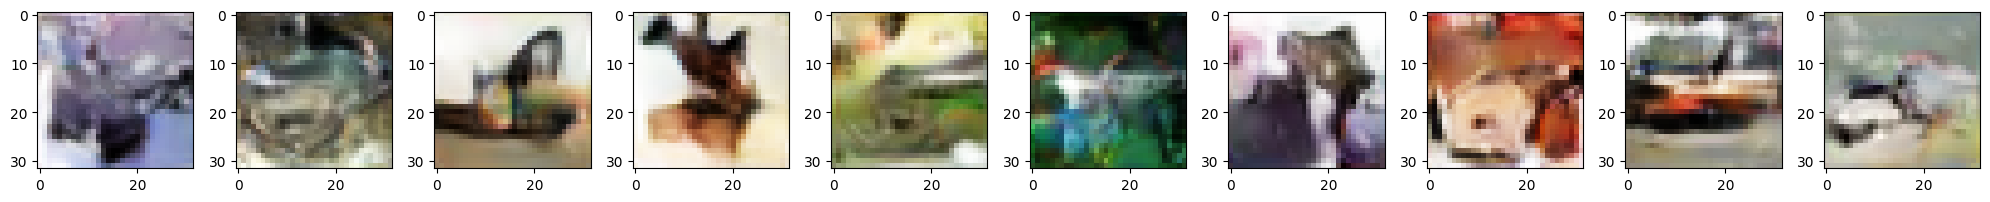

211/211 - 23s - loss: 2.1914 - d_loss: 1.6934 - g_loss: 0.4980 - 23s/epoch - 110ms/step
Epoch 59/100


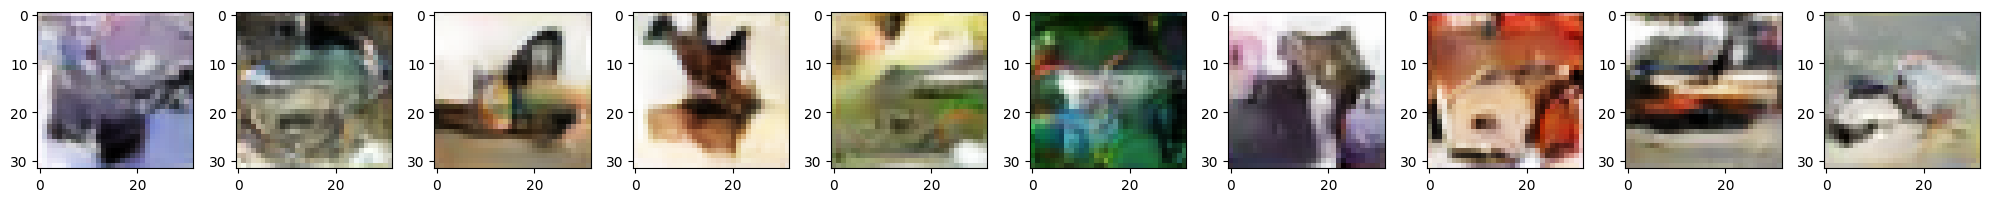

211/211 - 23s - loss: 2.1107 - d_loss: 1.6807 - g_loss: 0.4300 - 23s/epoch - 109ms/step
Epoch 60/100


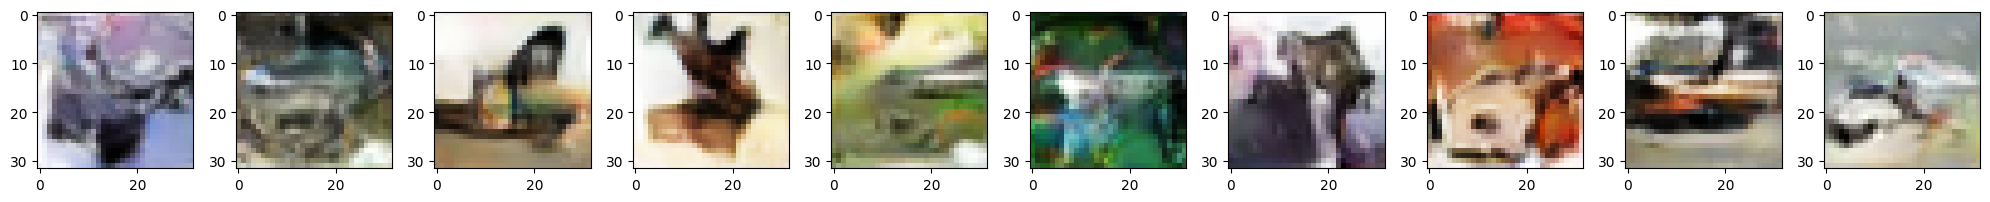

211/211 - 23s - loss: 2.1588 - d_loss: 1.6799 - g_loss: 0.4788 - 23s/epoch - 109ms/step
Epoch 61/100


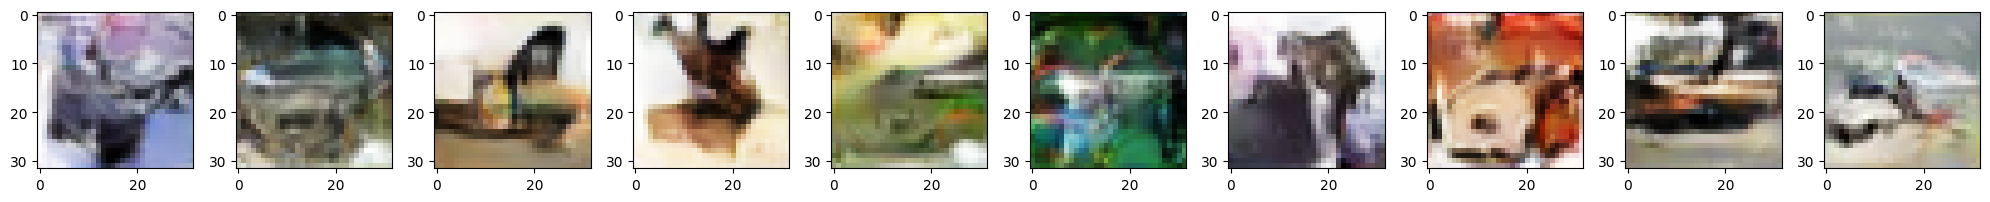

211/211 - 23s - loss: 2.1253 - d_loss: 1.6742 - g_loss: 0.4511 - 23s/epoch - 109ms/step
Epoch 62/100


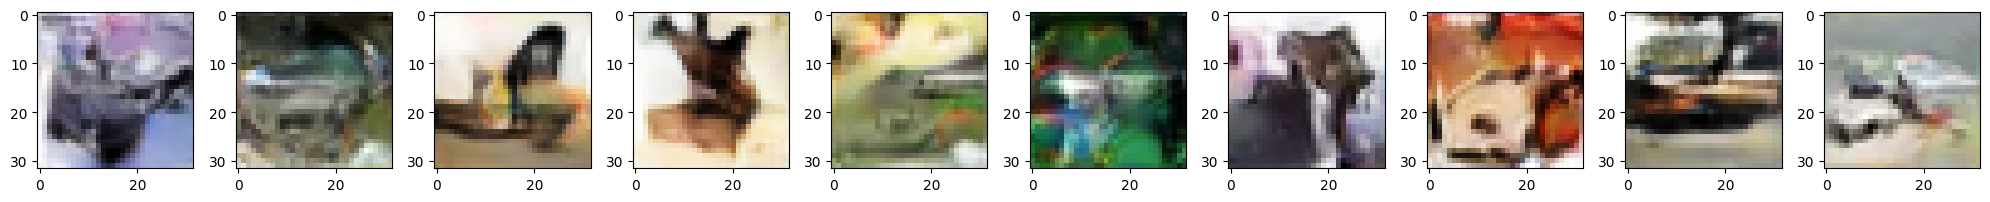

211/211 - 21s - loss: 2.1538 - d_loss: 1.6822 - g_loss: 0.4716 - 21s/epoch - 97ms/step
Epoch 63/100


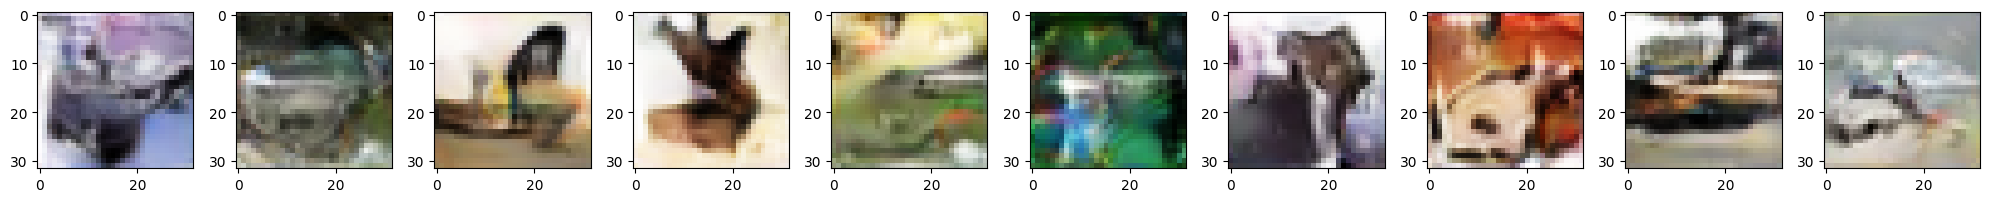

211/211 - 23s - loss: 2.1784 - d_loss: 1.6793 - g_loss: 0.4992 - 23s/epoch - 109ms/step
Epoch 64/100


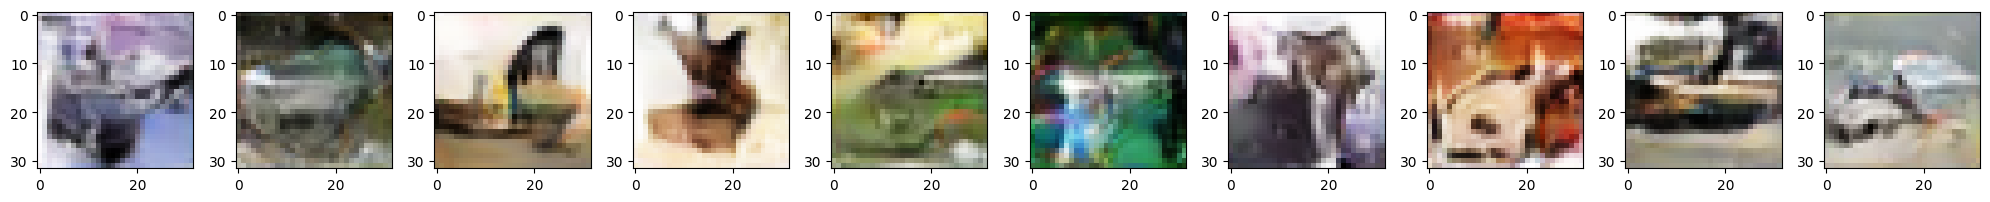

211/211 - 22s - loss: 2.1471 - d_loss: 1.6756 - g_loss: 0.4715 - 22s/epoch - 106ms/step
Epoch 65/100


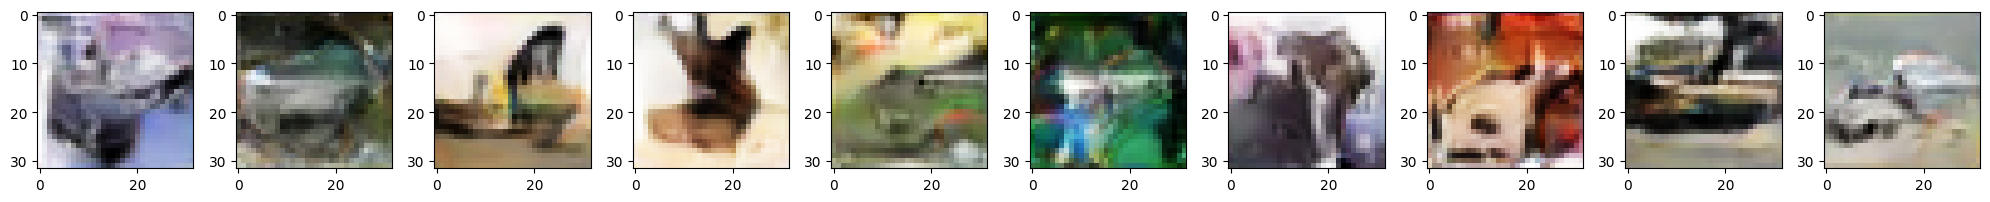

211/211 - 23s - loss: 2.1207 - d_loss: 1.6786 - g_loss: 0.4420 - 23s/epoch - 111ms/step
Epoch 66/100


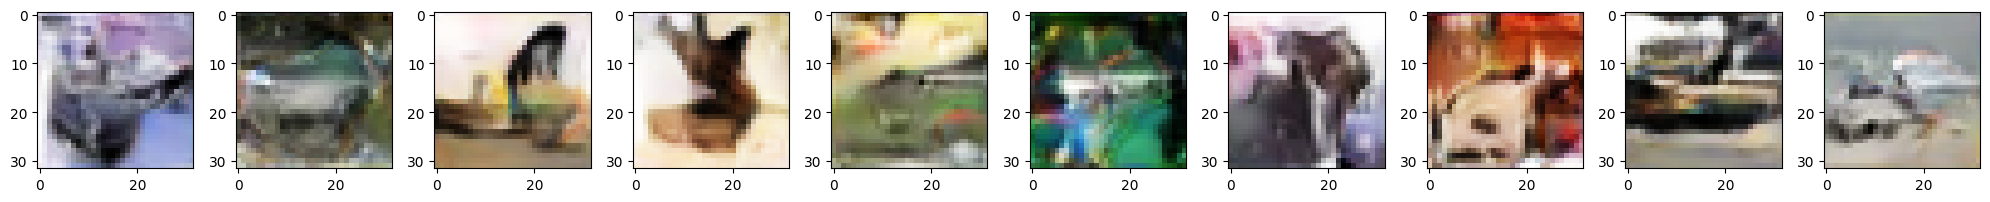

211/211 - 23s - loss: 2.1511 - d_loss: 1.6831 - g_loss: 0.4680 - 23s/epoch - 108ms/step
Epoch 67/100


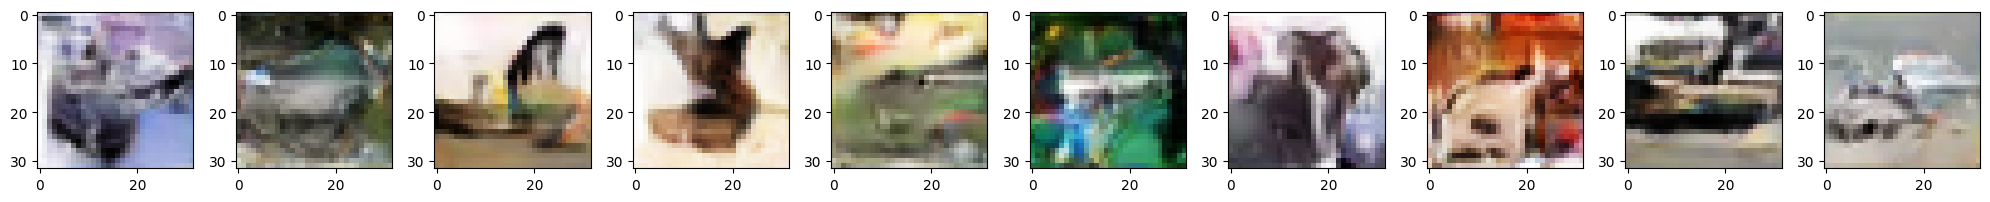

211/211 - 23s - loss: 2.1272 - d_loss: 1.6660 - g_loss: 0.4612 - 23s/epoch - 109ms/step
Epoch 68/100


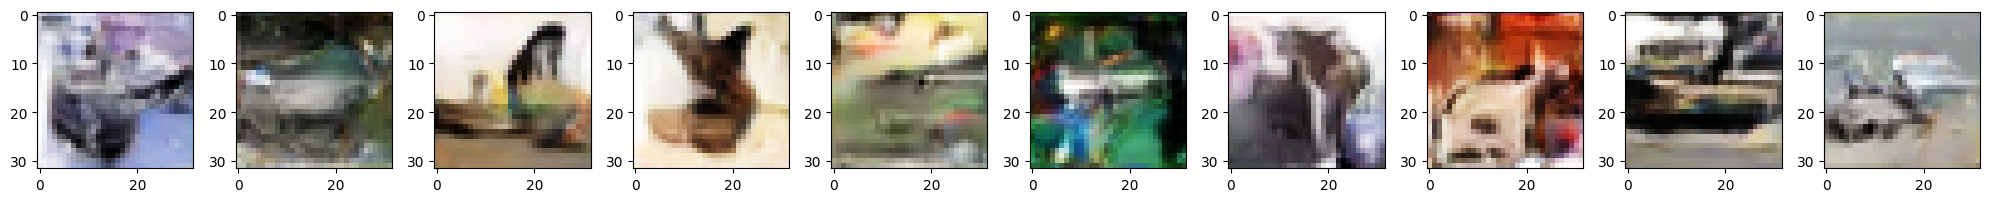

211/211 - 23s - loss: 2.1197 - d_loss: 1.6667 - g_loss: 0.4530 - 23s/epoch - 109ms/step
Epoch 69/100


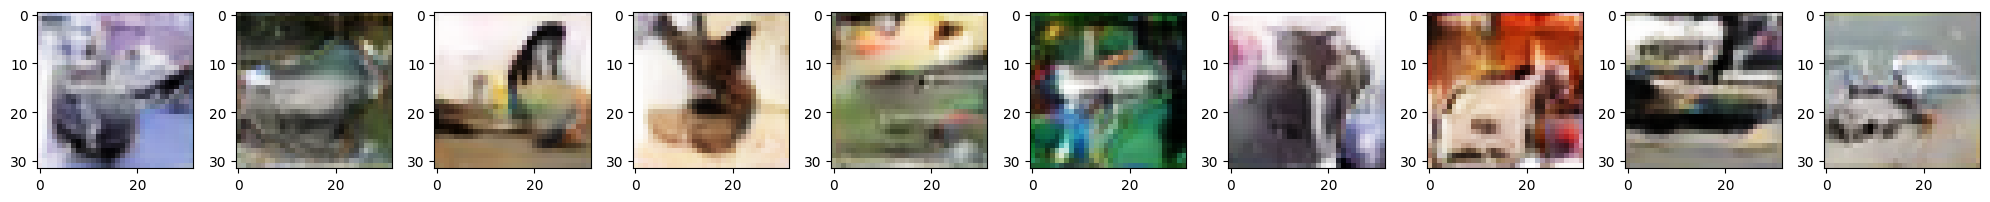

211/211 - 23s - loss: 2.1007 - d_loss: 1.6622 - g_loss: 0.4385 - 23s/epoch - 108ms/step
Epoch 70/100


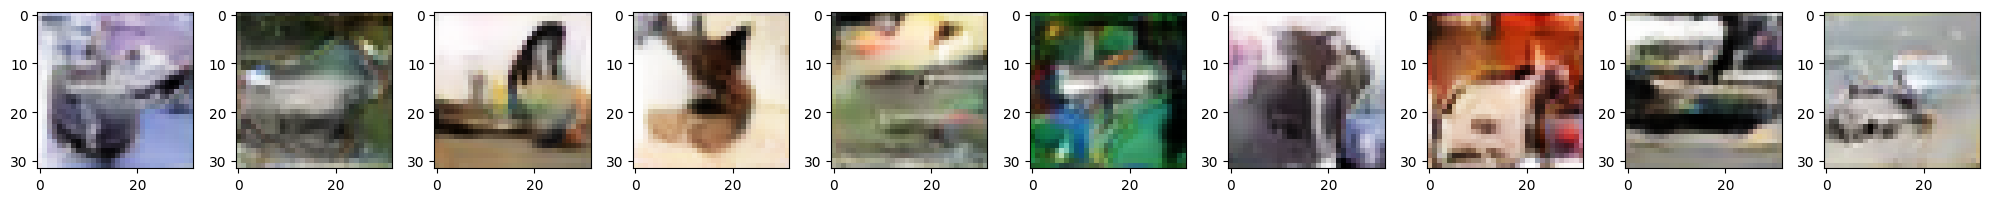

211/211 - 21s - loss: 2.0546 - d_loss: 1.6605 - g_loss: 0.3942 - 21s/epoch - 98ms/step
Epoch 71/100


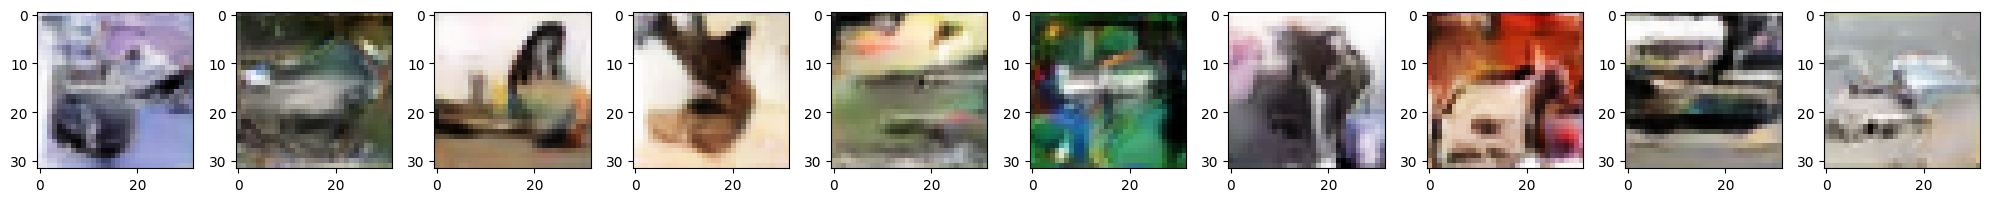

211/211 - 23s - loss: 2.1146 - d_loss: 1.6528 - g_loss: 0.4618 - 23s/epoch - 109ms/step
Epoch 72/100


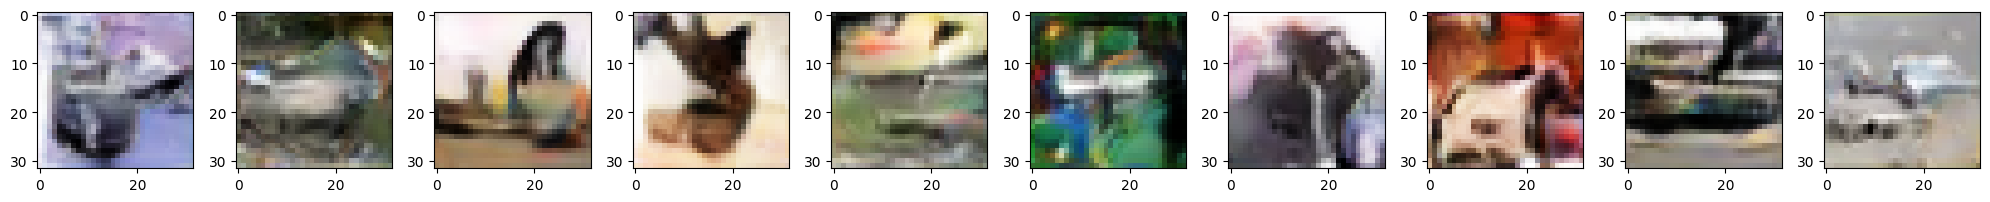

211/211 - 23s - loss: 2.0902 - d_loss: 1.6521 - g_loss: 0.4382 - 23s/epoch - 109ms/step
Epoch 73/100


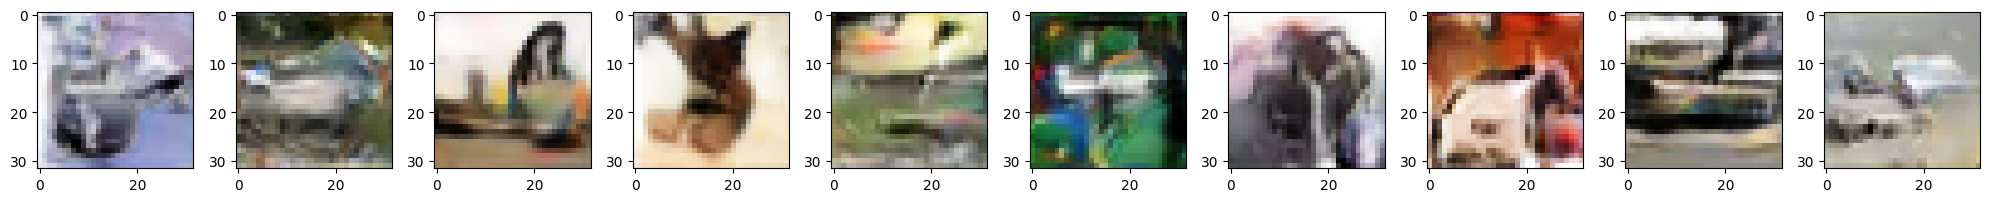

211/211 - 23s - loss: 2.1374 - d_loss: 1.6568 - g_loss: 0.4807 - 23s/epoch - 109ms/step
Epoch 74/100


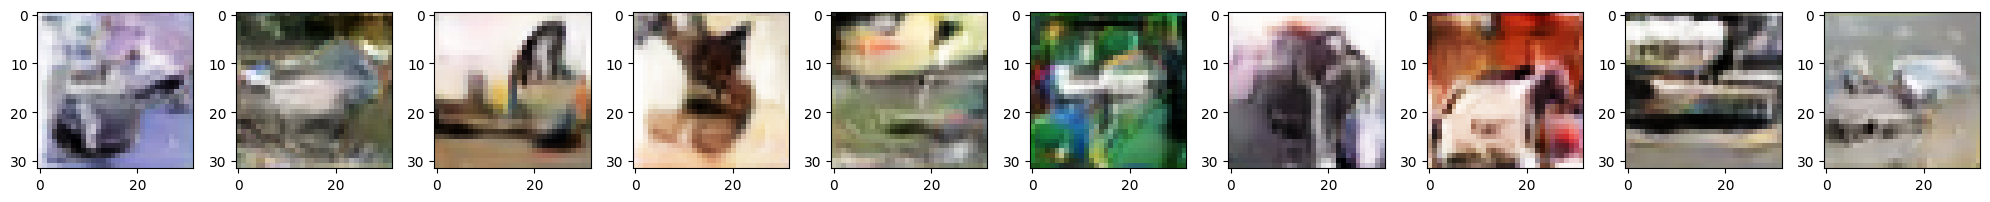

211/211 - 23s - loss: 2.1373 - d_loss: 1.6556 - g_loss: 0.4817 - 23s/epoch - 110ms/step
Epoch 75/100


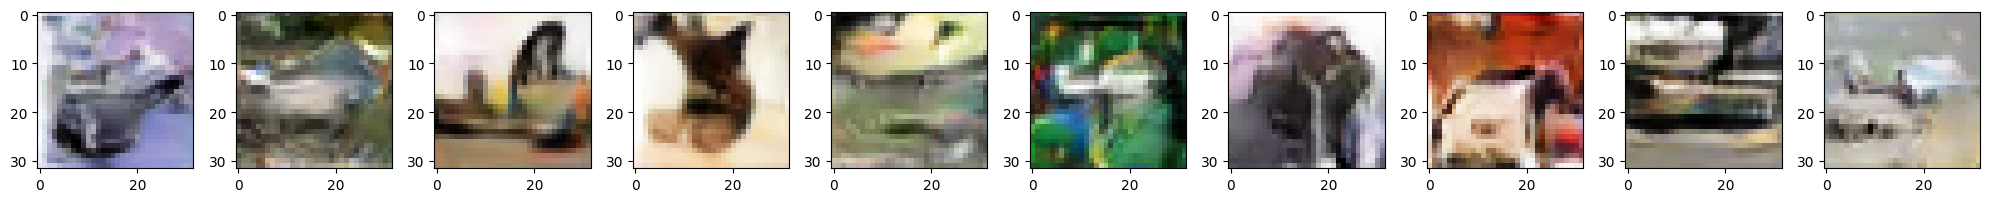

211/211 - 23s - loss: 2.0825 - d_loss: 1.6433 - g_loss: 0.4393 - 23s/epoch - 111ms/step
Epoch 76/100


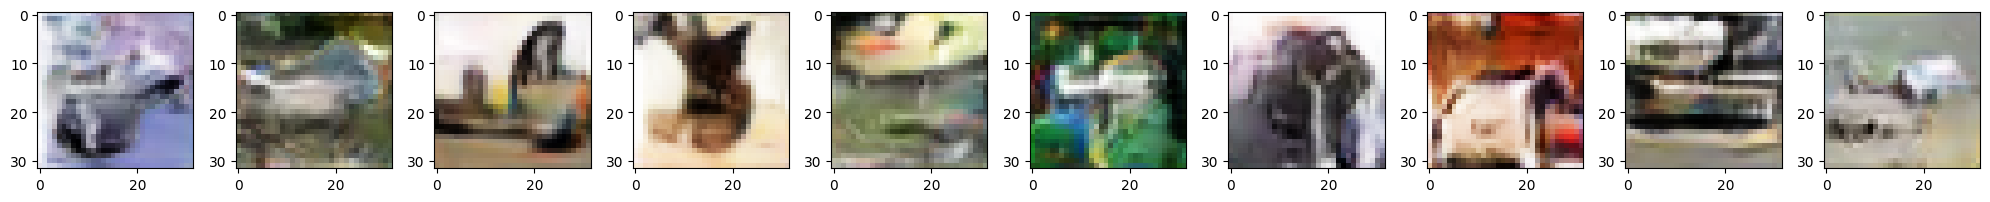

211/211 - 23s - loss: 2.0915 - d_loss: 1.6442 - g_loss: 0.4472 - 23s/epoch - 108ms/step
Epoch 77/100


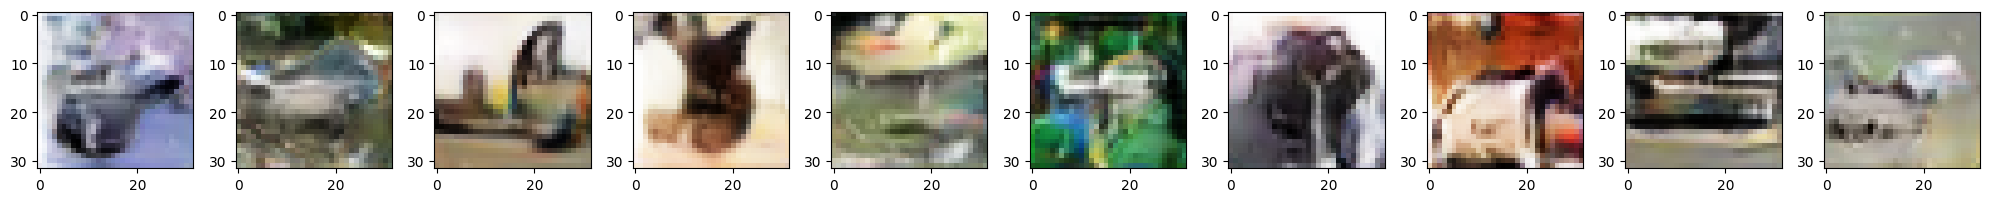

211/211 - 21s - loss: 2.1137 - d_loss: 1.6384 - g_loss: 0.4753 - 21s/epoch - 98ms/step
Epoch 78/100


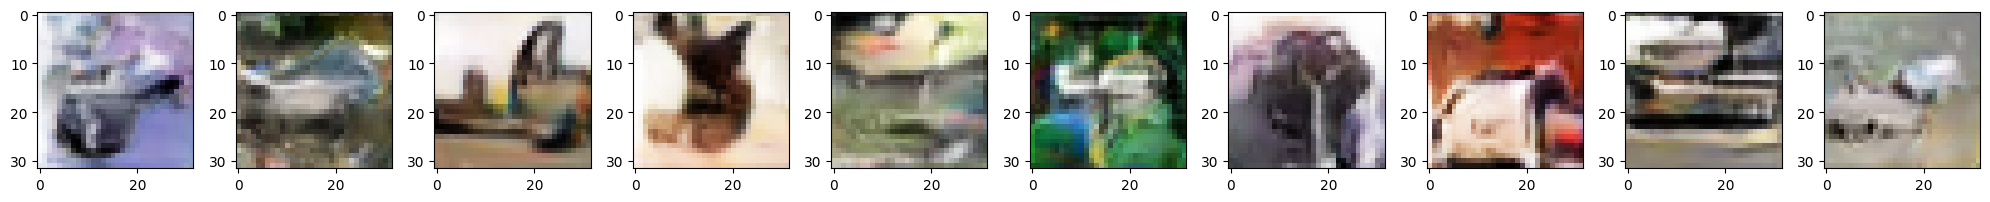

211/211 - 14s - loss: 2.0945 - d_loss: 1.6375 - g_loss: 0.4569 - 14s/epoch - 64ms/step
Epoch 79/100


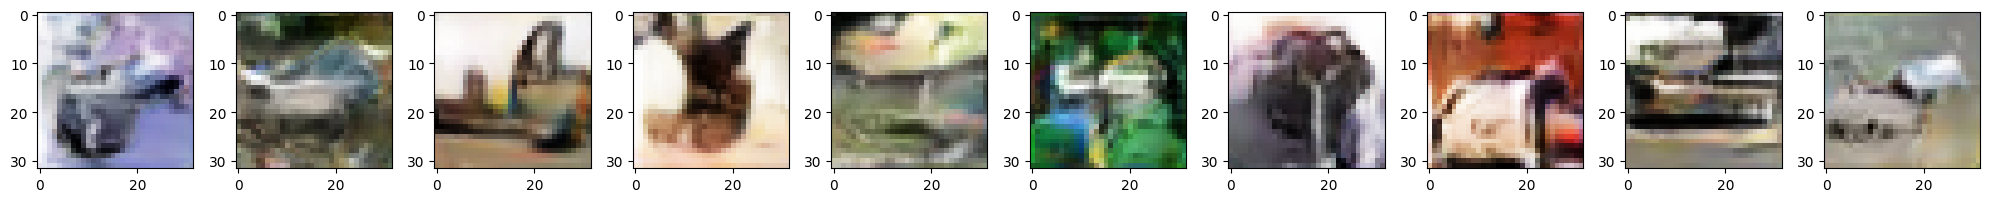

211/211 - 15s - loss: 2.1105 - d_loss: 1.6389 - g_loss: 0.4715 - 15s/epoch - 70ms/step
Epoch 80/100


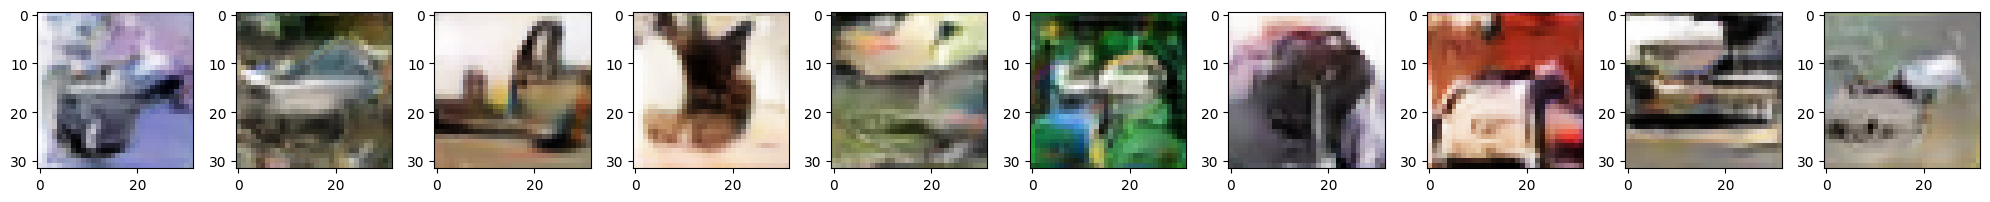

211/211 - 15s - loss: 2.0825 - d_loss: 1.6311 - g_loss: 0.4514 - 15s/epoch - 70ms/step
Epoch 81/100


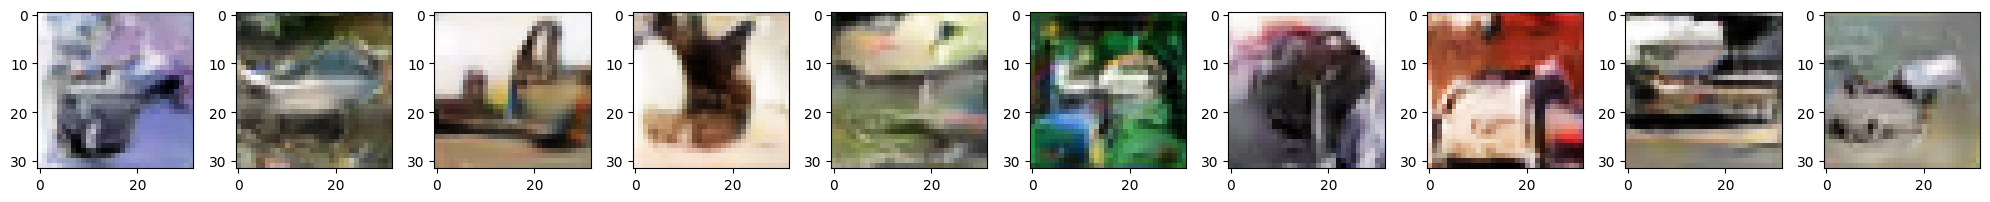

211/211 - 14s - loss: 2.0847 - d_loss: 1.6226 - g_loss: 0.4621 - 14s/epoch - 64ms/step
Epoch 82/100


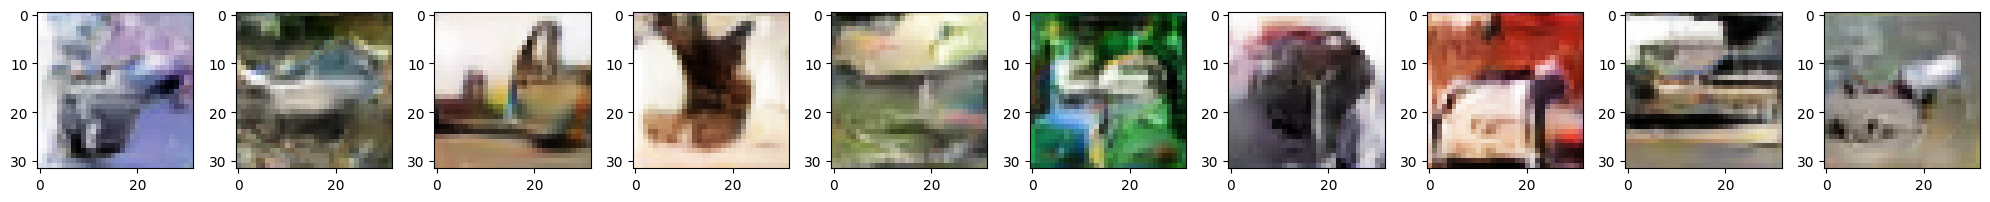

211/211 - 14s - loss: 2.1002 - d_loss: 1.6260 - g_loss: 0.4742 - 14s/epoch - 67ms/step
Epoch 83/100


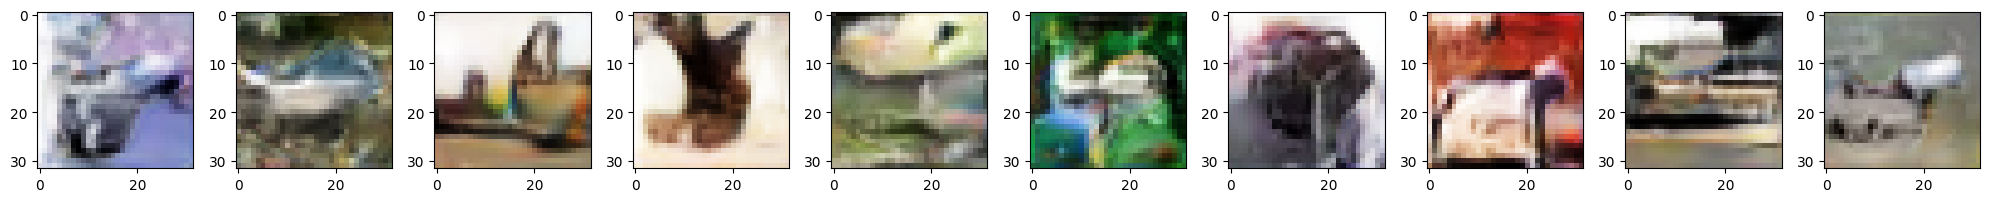

211/211 - 16s - loss: 2.1392 - d_loss: 1.6246 - g_loss: 0.5147 - 16s/epoch - 76ms/step
Epoch 84/100


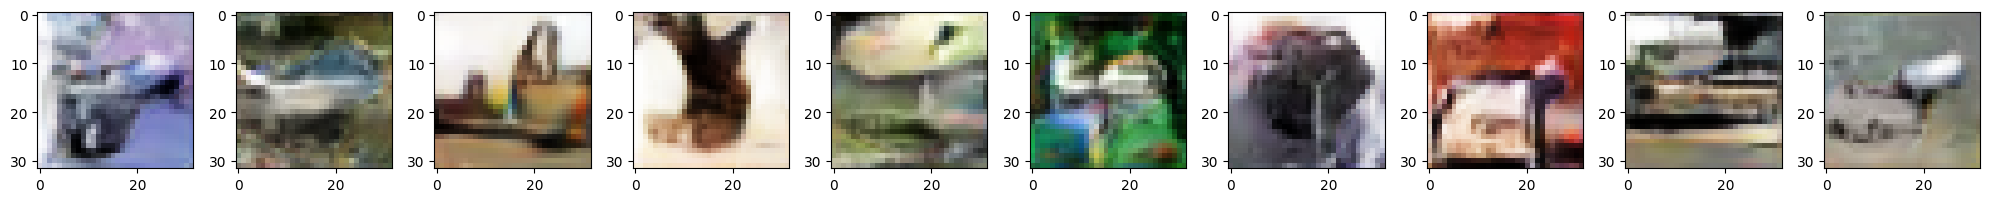

211/211 - 15s - loss: 2.0852 - d_loss: 1.6207 - g_loss: 0.4645 - 15s/epoch - 72ms/step
Epoch 85/100


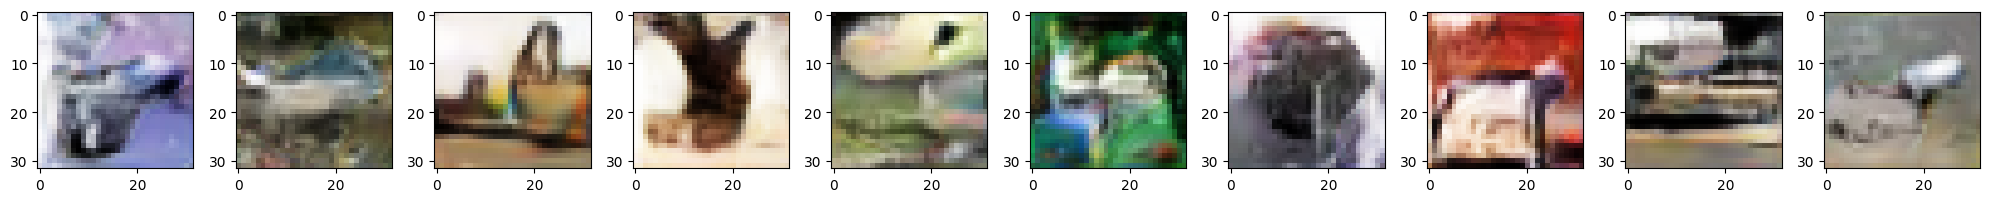

211/211 - 13s - loss: 2.0452 - d_loss: 1.6161 - g_loss: 0.4291 - 13s/epoch - 62ms/step
Epoch 86/100


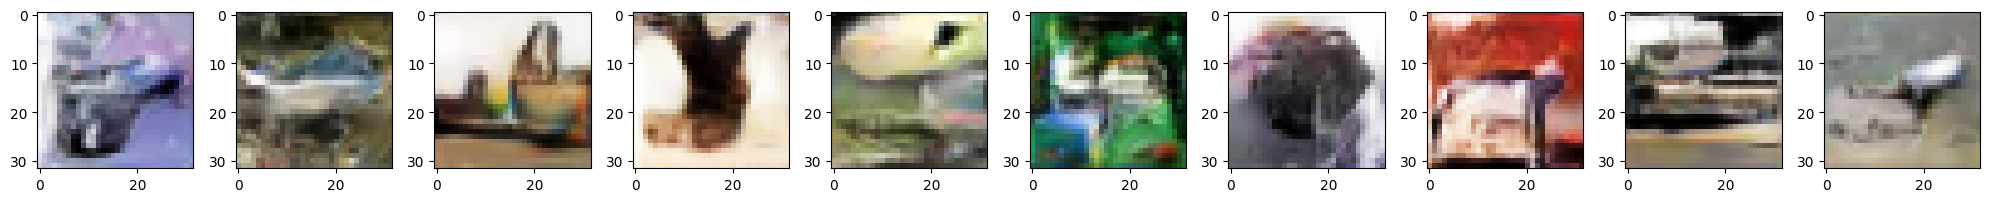

211/211 - 13s - loss: 2.0536 - d_loss: 1.6160 - g_loss: 0.4376 - 13s/epoch - 63ms/step
Epoch 87/100


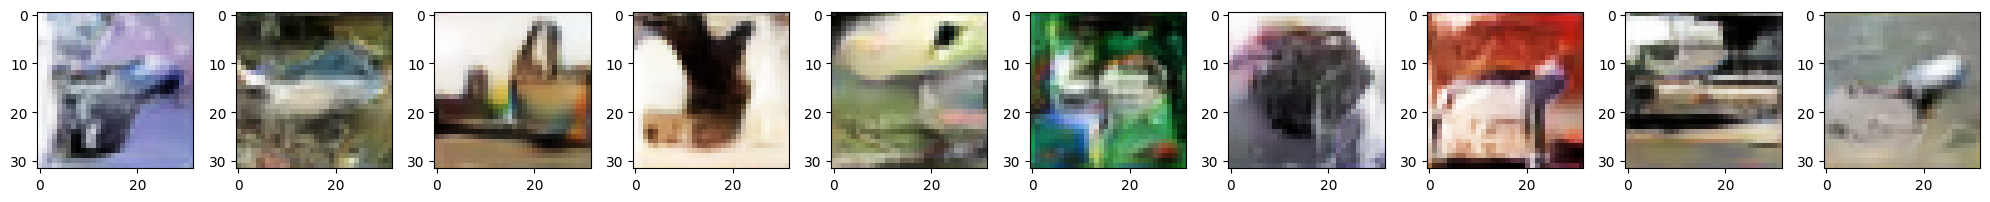

211/211 - 14s - loss: 2.0656 - d_loss: 1.6091 - g_loss: 0.4566 - 14s/epoch - 68ms/step
Epoch 88/100


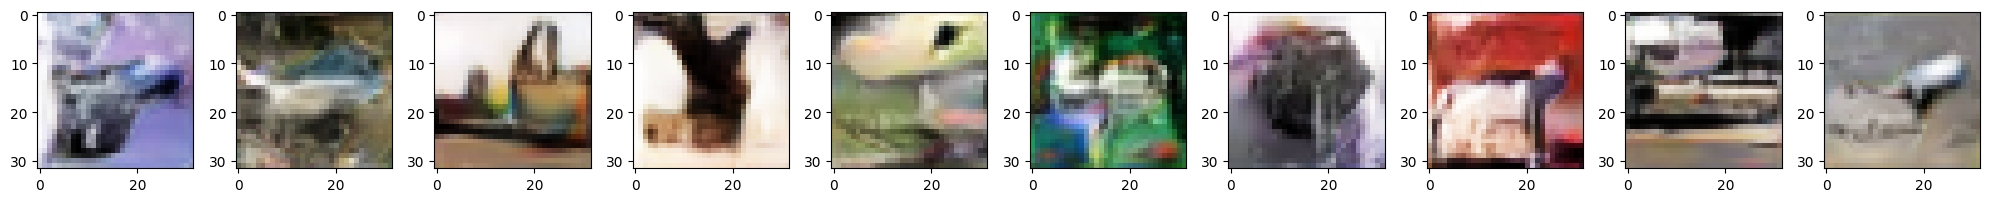

211/211 - 14s - loss: 2.0791 - d_loss: 1.6142 - g_loss: 0.4649 - 14s/epoch - 64ms/step
Epoch 89/100


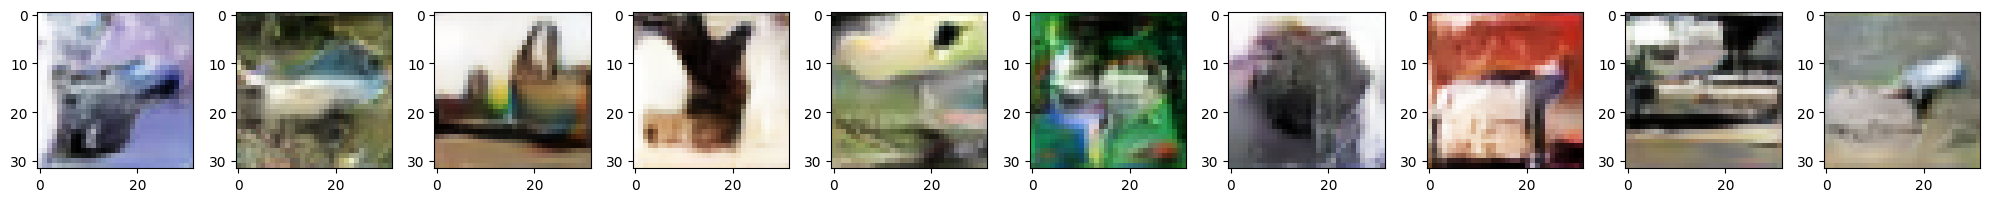

211/211 - 13s - loss: 2.1075 - d_loss: 1.6088 - g_loss: 0.4987 - 13s/epoch - 62ms/step
Epoch 90/100


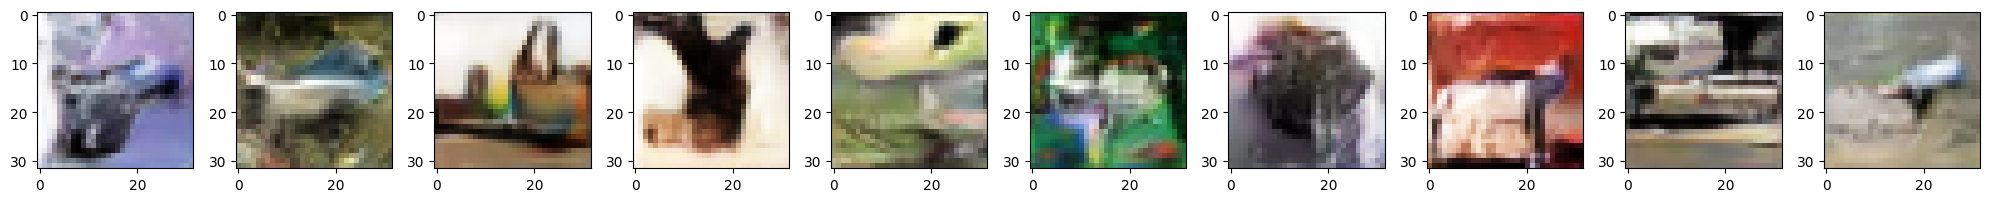

211/211 - 13s - loss: 2.0701 - d_loss: 1.6075 - g_loss: 0.4626 - 13s/epoch - 61ms/step
Epoch 91/100


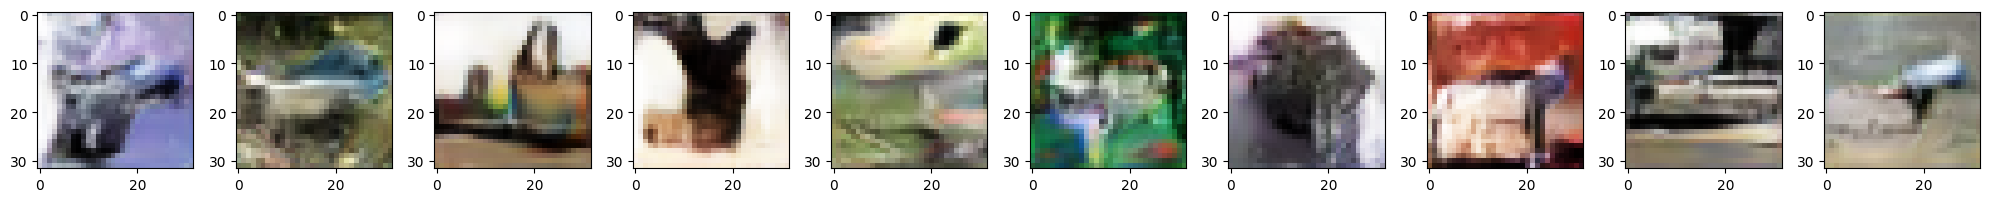

211/211 - 14s - loss: 2.0578 - d_loss: 1.6005 - g_loss: 0.4573 - 14s/epoch - 64ms/step
Epoch 92/100


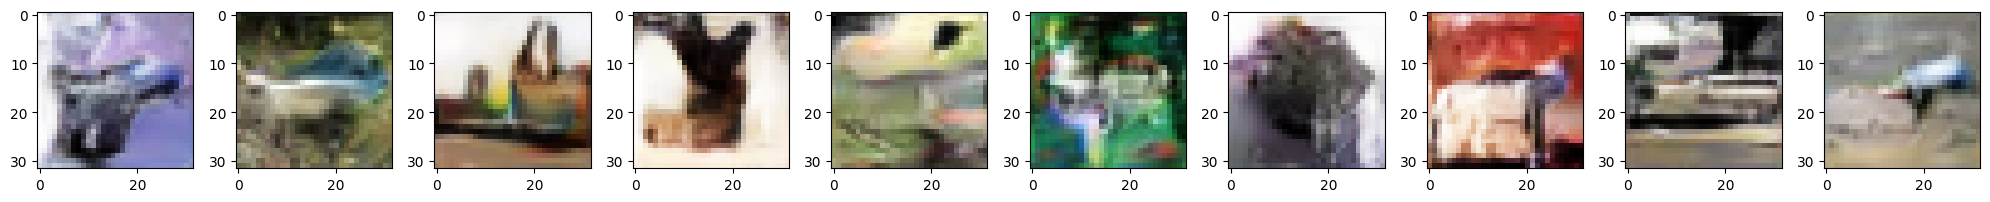

211/211 - 13s - loss: 2.1201 - d_loss: 1.6088 - g_loss: 0.5113 - 13s/epoch - 64ms/step
Epoch 93/100


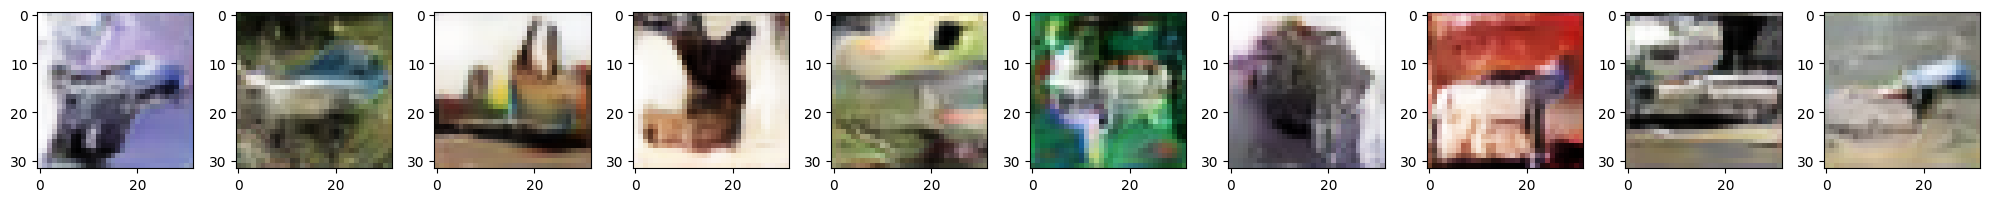

211/211 - 14s - loss: 2.0981 - d_loss: 1.6000 - g_loss: 0.4980 - 14s/epoch - 65ms/step
Epoch 94/100


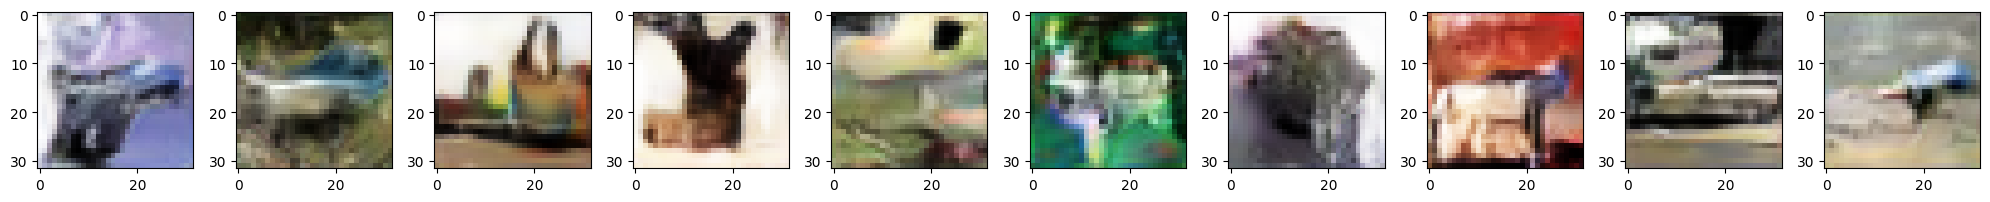

211/211 - 13s - loss: 2.0636 - d_loss: 1.5973 - g_loss: 0.4663 - 13s/epoch - 64ms/step
Epoch 95/100


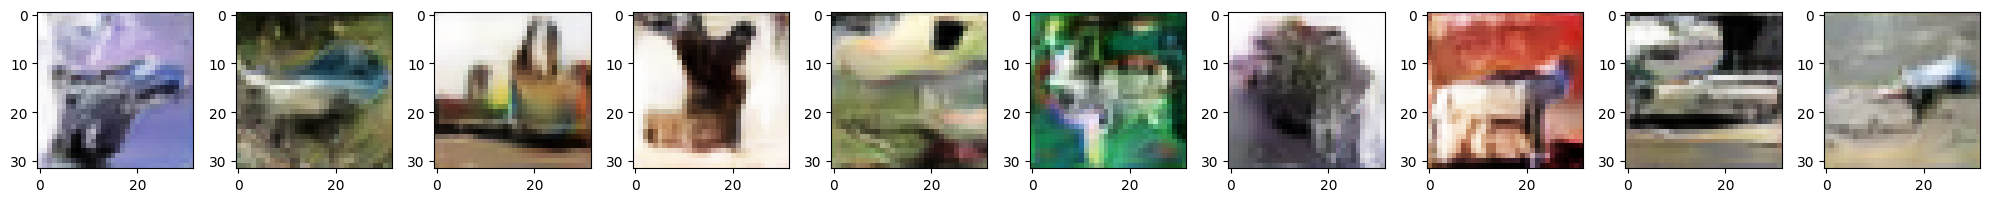

211/211 - 13s - loss: 2.0288 - d_loss: 1.5955 - g_loss: 0.4332 - 13s/epoch - 64ms/step
Epoch 96/100


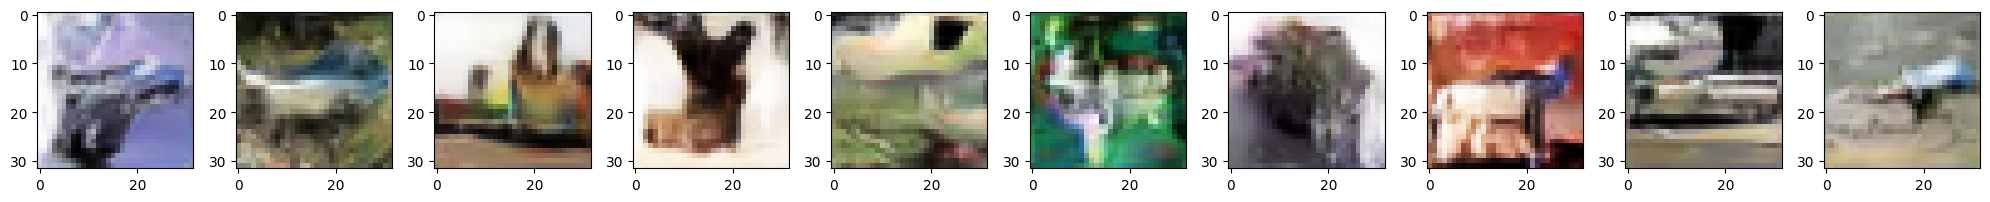

211/211 - 14s - loss: 2.0626 - d_loss: 1.5949 - g_loss: 0.4677 - 14s/epoch - 69ms/step
Epoch 97/100


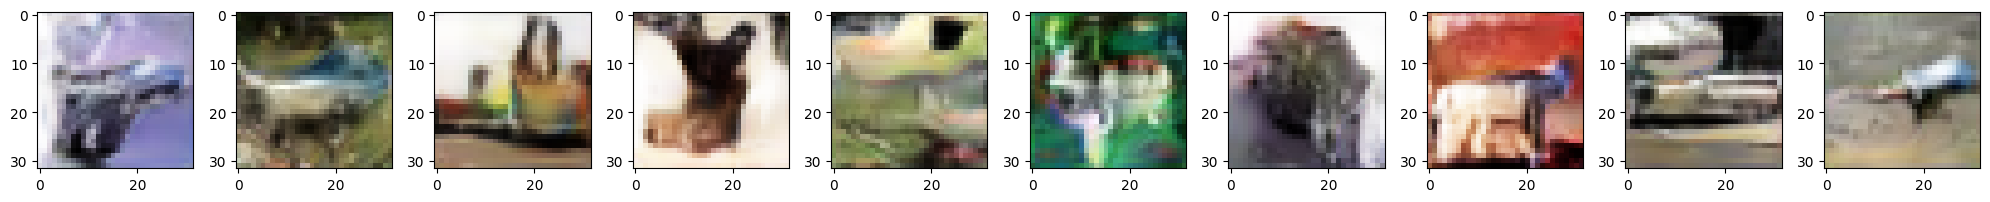

211/211 - 13s - loss: 1.9771 - d_loss: 1.5892 - g_loss: 0.3879 - 13s/epoch - 61ms/step
Epoch 98/100


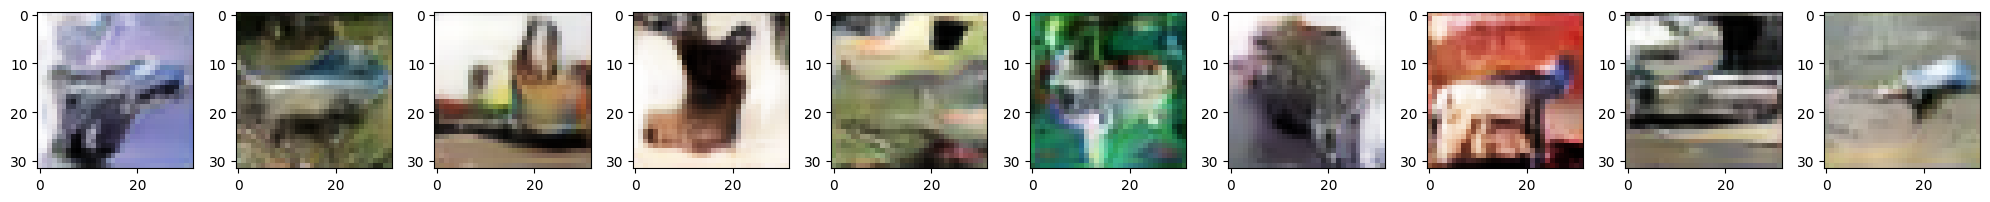

211/211 - 13s - loss: 2.0572 - d_loss: 1.5874 - g_loss: 0.4699 - 13s/epoch - 61ms/step
Epoch 99/100


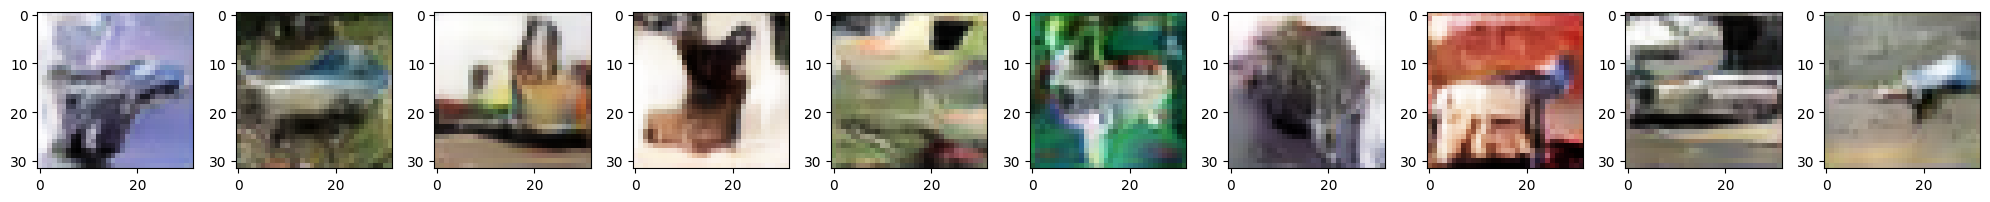

211/211 - 13s - loss: 2.0574 - d_loss: 1.5965 - g_loss: 0.4609 - 13s/epoch - 63ms/step
Epoch 100/100


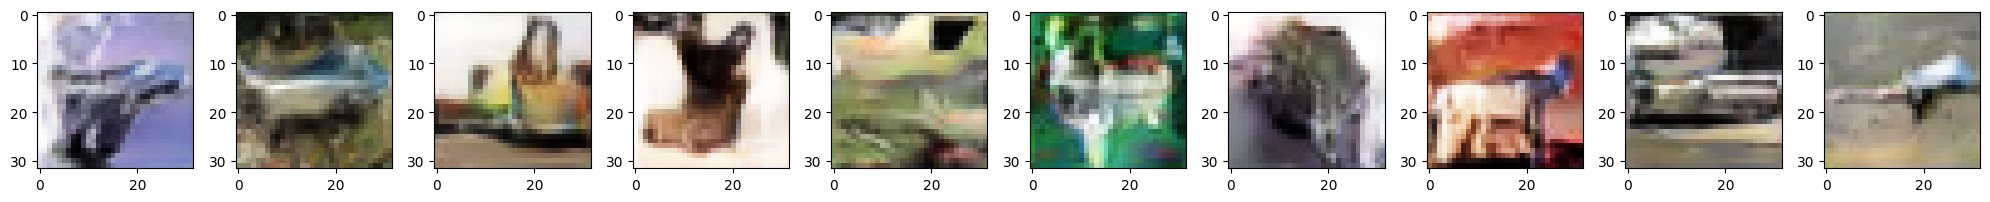

211/211 - 14s - loss: 2.0675 - d_loss: 1.5944 - g_loss: 0.4731 - 14s/epoch - 64ms/step
Generator training completed!
Generator saving started...


Generator saving completed!
Sampling started...
Sampling completed!
Similarity metrics computation started...
Similarity metrics computation completed!
Classifier training on generated data started...
Epoch 1/100
211/211 - 5s - loss: 1.7091 - accuracy: 0.3680 - val_loss: 1.6935 - val_accuracy: 0.3948 - lr: 0.1000 - 5s/epoch - 25ms/step
Epoch 2/100
211/211 - 3s - loss: 1.4312 - accuracy: 0.4757 - val_loss: 1.3996 - val_accuracy: 0.5070 - lr: 0.1000 - 3s/epoch - 14ms/step
Epoch 3/100
211/211 - 3s - loss: 1.2938 - accuracy: 0.5341 - val_loss: 1.3799 - val_accuracy: 0.5120 - lr: 0.1000 - 3s/epoch - 16ms/step
Epoch 4/100
211/211 - 3s - loss: 1.2128 - accuracy: 0.5649 - val_loss: 1.4068 - val_accuracy: 0.4967 - lr: 0.1000 - 3s/epoch - 14ms/step
Epoch 5/100
211/211 - 3s - loss: 1.1522 - accuracy: 0.5895 - val_loss: 1.2768 - val_accuracy: 0.5578 - lr: 0.1000 - 3s/epoch - 13ms/step
Epoch 6/100
211/211 - 3s - loss: 1.1122 - accuracy: 0.6043 - val_loss: 1.1787 - val_accuracy: 0.6073 - lr: 0.1000 

{'dataset_name': 'CIFAR10',
 'data_description': 'A toy balanced image dataset containing 10 different classes',
 'data_format': 'image',
 'raw_shape': (60000, 32, 32, 3),
 'shape': (60000, 32, 32, 3),
 'conditioned': True,
 'labels_shape': (60000, 1),
 'task': 'classification',
 'classes': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 'num_classes': 10,
 'sub_task': 'Toy image classification',
 'model_size': 'small',
 'epochs': 100,
 'batch_size': 256,
 'discriminator_rounds': 3,
 'blocks': 2,
 'filters': 32,
 'latent_dim': 64,
 'data_min': 0.0,
 'data_max': 255.0,
 'generator_input_shape': 74,
 'generator_output_shape': (60000, 32, 32, 3),
 'discriminator_input_shape': (60000, 32, 32, 13),
 'discriminator_output_shape': (1,),
 'classifier_real_history': {'loss': [1.7038317918777466,
   1.4386783838272095,
   1.3082444667816162,
   1.2216286659240723,
   1.1629371643066406,
   1.1206960678100586,
   1.0814553499221802,
   1.053978443145752,
   1.0222716331481934,
   1.003249406

In [120]:
# TODO:
# - aggiungere test sulla distribuzione campionata e quella reale
# - aggiungere test sulla distribuzione campionata rispetto a quelle esistenti


def metadata_extraction(
    X,
    y=np.array([]),
    epochs=500,
    batch_size=128,
    image_size=32,
    model_size="small",
    task="classification",
    sub_task="",
    data_description="",
    dataset_name="",
    data_format="image",
    verbose=1,
):
    metadata = {}

    # DATASET
    metadata["dataset_name"] = dataset_name
    metadata["data_description"] = data_description
    metadata["data_format"] = data_format
    metadata["raw_shape"] = X.shape

    if metadata["data_format"] == "image":
        if len(X.shape) > 4 or len(X.shape) < 3:
            print(f"ABORT: {data.shape} is not a proper shape for an image dataset")
            return -1
        elif len(X.shape) == 3:
            metadata["shape"] = (X.shape[0], image_size, image_size, 1)
        else:
            metadata["shape"] = (X.shape[0], image_size, image_size, X.shape[-1])
    else:
        return -1

    # LABELS
    if y.size != 0:
        assert len(X) == len(y)
        assert len(y.shape) == 1 or (len(y.shape) == 2 and y.shape[1] == 1)
        metadata["conditioned"] = True
        metadata["labels_shape"] = y.shape
        if task == "classification":
            metadata["task"] = task
            metadata["classes"] = np.unique(y)
            metadata["num_classes"] = len(np.unique(y))
        else:
            metadata["task"] = None

    else:
        metadata["conditioned"] = False
        metadata["task"] = None
    metadata["sub_task"] = sub_task

    # GENERATIVE MODEL
    metadata["model_size"] = model_size
    metadata["epochs"] = epochs
    metadata["batch_size"] = batch_size

    metadata["discriminator_rounds"] = 3

    if model_size == "small":
        metadata["blocks"] = 2
        metadata["filters"] = 32
        metadata["latent_dim"] = 64
    elif model_size == "large":
        metadata["blocks"] = 4
        metadata["filters"] = 64
        metadata["latent_dim"] = 128
    else:
        metadata["blocks"] = 3
        metadata["filters"] = 32
        metadata["latent_dim"] = 128

    # TASK
    metadata["task"] = task
    metadata["sub_task"] = sub_task

    return metadata


def data_processing(metadata, data, labels=np.array([])):
    # Make the image dataset with 4 dimensions
    if len(metadata["raw_shape"]) == 3 and metadata["data_format"] == "image":
        data = np.expand_dims(data, axis=-1)

    # Make the image dataset squared
    if verbose > 1:
        print("\t Dataset reshaping started...")
    dim = min(data.shape[1:-1])
    data = data[
        :,
        (data.shape[1] - dim) // 2 : (data.shape[1] + dim) // 2,
        (data.shape[2] - dim) // 2 : (data.shape[2] + dim) // 2,
        :,
    ]
    if verbose > 1:
        print("\t Dataset reshaping completed!")

    # Resize the image dataset
    if verbose > 1:
        print("\t Dataset resizing started...")
    resize = tfkl.Resizing(metadata["shape"][1], metadata["shape"][2])
    data = resize(data).numpy()
    if verbose > 1:
        print("\t Dataset resizing completed!")

    # Save data minimum and maximum
    metadata["data_min"] = data.min()
    metadata["data_max"] = data.max()

    # Normalize in range [-1,1]
    if verbose > 1:
        print("\t Dataset normalization started...")
    data = (
        (data - metadata["data_min"])
        / (metadata["data_max"] - metadata["data_min"])
        * 2
        - 1
    ).astype(np.float32)
    if verbose > 1:
        print("\t Dataset normalization completed!")
    """
    da verificare, perché ci mette tanto tempo...
    """

    if labels.size != 0:
        labels = tfk.utils.to_categorical(labels)
        if metadata["conditioned"]:
            metadata["generator_input_shape"] = (
                metadata["latent_dim"] + metadata["num_classes"]
            )
            metadata["generator_output_shape"] = metadata["shape"]
            metadata["discriminator_input_shape"] = list(metadata["shape"])
            metadata["discriminator_input_shape"][-1] += metadata["num_classes"]
            metadata["discriminator_input_shape"] = tuple(
                metadata["discriminator_input_shape"]
            )
            metadata["discriminator_output_shape"] = (1,)
    return data, labels


def train_image_generator(
    X,
    y=np.array([]),
    epochs=500,
    batch_size=128,
    image_size=32,
    model_size="",
    task="",
    sub_task="",
    data_description="",
    dataset_name="",
    verbose=2,
):
    # Extract metadata
    if verbose > 0:
        print("Metadata extraction started...")
    metadata = metadata_extraction(
        X=X,
        y=y,
        epochs=epochs,
        batch_size=batch_size,
        image_size=image_size,
        model_size=model_size,
        task=task,
        sub_task=sub_task,
        data_description=data_description,
        dataset_name=dataset_name,
        data_format="image",
        verbose=verbose,
    )
    if verbose > 0:
        print("Metadata extraction completed!")

    # Process data
    if verbose > 0:
        print("Data processing started...")
    X, y = data_processing(metadata, X, y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, test_size=0.1, stratify=np.argmax(y, axis=1)
    )

    dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset_train = dataset_train.shuffle(buffer_size=1024).batch(
        metadata["batch_size"]
    )

    dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    dataset_test = dataset_test.shuffle(buffer_size=1024).batch(metadata["batch_size"])
    if verbose > 0:
        print("Data processing completed!")

    # Train a classifier on real data
    if verbose > 0:
        print("Classifier training on real data started...")
    real_classifier = build_resnet18(
        metadata["generator_output_shape"][1:], metadata["num_classes"]
    )
    metadata["classifier_real_history"] = real_classifier.fit(
        dataset_train,
        validation_data=dataset_test,
        batch_size=128,
        epochs=100,
        verbose=2,
        callbacks=[tfk.callbacks.LearningRateScheduler(scheduler)],
    ).history

    metadata["classifier_real_best_accuracy"] = max(
        metadata["classifier_real_history"]["val_accuracy"]
    )
    if verbose > 0:
        print("Classifier training on real data completed!")

    # Build the generator
    if verbose > 0:
        print("Generator building started...")
    gan = ConditionalHingeGAN(
        generator=build_generator(
            output_shape=metadata["generator_output_shape"][1:],
            latent_dim=metadata["generator_input_shape"],
            num_classes=metadata["num_classes"],
            filters=metadata["filters"],
            blocks=metadata["blocks"],
        ),
        discriminator=build_discriminator(
            input_shape=metadata["discriminator_input_shape"][1:],
            filters=metadata["filters"],
            blocks=metadata["blocks"],
        ),
        latent_dim=metadata["latent_dim"],
        discriminator_rounds=metadata["discriminator_rounds"],
        num_classes=metadata["num_classes"],
    )
    gan.compile(
        d_optimizer=tfk.optimizers.Adam(
            learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-6
        ),
        g_optimizer=tfk.optimizers.Adam(
            learning_rate=5e-5,
            beta_1=0.5,
            beta_2=0.999,
            epsilon=1e-6,
        ),
    )
    cb = [
        ConditionalGANMonitor(
            10, metadata["num_classes"], metadata["latent_dim"], gray=True
        )
    ]
    if verbose > 0:
        print("Generator building completed!")

    # Train the generator
    if verbose > 0:
        print("Generator training started...")
    metadata["history"] = gan.fit(
        dataset_train,
        batch_size=metadata["batch_size"],
        epochs=metadata["epochs"],
        verbose=2,
        callbacks=cb,
    ).history
    if verbose > 0:
        print("Generator training completed!")

    # Save the generator
    if verbose > 0:
        print("Generator saving started...")
    gan.generator.save("gan_gen_prova")
    gan.discriminator.save("gan_disc_prova")
    metadata["model"] = gan
    if verbose > 0:
        print("Generator saving completed!")

    # Generate a dataset
    if verbose > 0:
        print("Sampling started...")
    noise = tf.random.normal(shape=(len(X_train), metadata["latent_dim"]))
    labels = tfk.utils.to_categorical(
        tf.cast(
            tf.math.floormod(tf.range(0, len(X_train)), metadata["num_classes"]),
            "float32",
        )
    )
    generator_input = tf.concat([noise, labels], axis=-1)
    generated_samples = gan.generator.predict(
        generator_input, batch_size=metadata["batch_size"], verbose=0
    )
    dataset_gen = tf.data.Dataset.from_tensor_slices((generated_samples, labels))
    dataset_gen = dataset_gen.shuffle(buffer_size=1024).batch(metadata["batch_size"])
    if verbose > 0:
        print("Sampling completed!")

    # Compute similarity metrics
    if verbose > 0:
        print("Similarity metrics computation started...")
    temp_generated_samples = ((generated_samples + 1) / 2 * 255).astype(np.int32)
    generated_mean = np.expand_dims(np.mean(temp_generated_samples, axis=0), axis=0)
    temp_real_samples = ((X_train + 1) / 2 * 255).astype(np.int32)
    real_mean = np.expand_dims(np.mean(temp_real_samples, axis=0), axis=0)
    metadata["SSIM"] = tf.image.ssim(generated_mean, real_mean, max_val=255)
    if verbose > 0:
        print("Similarity metrics computation completed!")

    # Train a classifier on generated data
    if verbose > 0:
        print("Classifier training on generated data started...")
    gen_classifier = build_resnet18(
        metadata["generator_output_shape"][1:], metadata["num_classes"]
    )
    metadata["classifier_gen_history"] = gen_classifier.fit(
        dataset_train,
        validation_data=dataset_test,
        batch_size=128,
        epochs=100,
        verbose=2,
        callbacks=[tfk.callbacks.LearningRateScheduler(scheduler)],
    ).history

    metadata["classifier_gen_best_accuracy"] = max(
        metadata["classifier_gen_history"]["val_accuracy"]
    )
    if verbose > 0:
        print("Classifier training on generated data completed!")

    return metadata


meta = train_image_generator(
    X=X,
    y=y,
    epochs=100,
    batch_size=batch_size,
    image_size=image_size,
    model_size=model_size,
    task=task,
    sub_task=sub_task,
    data_description=data_description,
    dataset_name=dataset_name,
    verbose=verbose,
)

meta

In [43]:
# aggiungere calcolo della JS
# aggiungere performance

In [116]:
noise = tf.random.normal(shape=(len(X_train), 54))
labels = tfk.utils.to_categorical(
    tf.cast(tf.math.floormod(tf.range(0, len(X_train)), 10), "float32")
)
generator_input = tf.concat([noise, labels], axis=-1)
generated_samples = (
    (gen.predict(generator_input, batch_size=128, verbose=0) + 1) / 2 * 255
).astype(np.int32)

generated_mean = np.expand_dims(np.mean(generated_samples, axis=0), axis=0)
real_mean = np.expand_dims(np.mean(X_train, axis=0), axis=0)

In [119]:
"""
SSIM has a better sensitivity to detect distortions that occur due to embedding messages on steganographic color images when compared with PSNR, this is due to the way SSIM works that are designed based on the human visual system
"""
# Structural Similarity Index Measure (SSIM) is between 0 and 1, the higher the better
print(tf.image.ssim(generated_mean, real_mean, max_val=255))

# PSNR is between 0 and 1, the higher the better
print(tf.image.psnr(generated_mean, real_mean, max_val=255))

tf.Tensor([0.93654996], shape=(1,), dtype=float32)
tf.Tensor([24.598412], shape=(1,), dtype=float32)


In [99]:
generated_samples.min()

0.37928587

In [101]:
generated_samples = np.reshape(
    generated_samples * 255, (len(generated_samples), -1)
).astype(np.int32)
X_train_f = np.reshape(X_train, (len(X_train), -1)).astype(np.int32)

In [68]:
somma = (generated_samples + X_train_f) / 2

In [108]:
X_train[0].shape, generated_samples[0].shape

((32, 32, 3), (3072,))

2.05680964917472

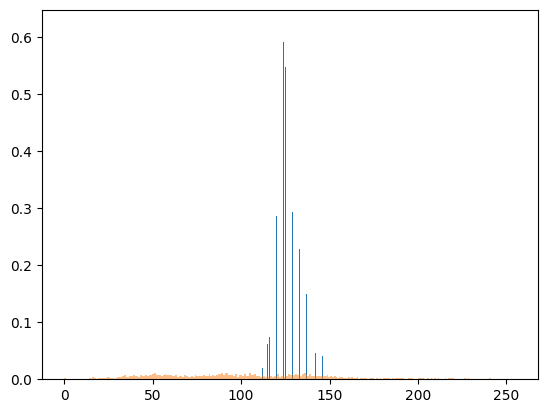

In [109]:
prob1, _, _ = plt.hist(generated_samples[0], bins=256, density=True, label="image one")
prob2, _, _ = plt.hist(
    X_train_f[0], bins=256, density=True, alpha=0.5, label="image two"
)
from scipy.stats import entropy

entropy(prob1, prob2)

In [100]:
def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i] / q[i]) for i in range(len(p)))


def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


# kld = tfk.losses.KLDivergence()
# print(kld(generated_samples,somma))
# print(kld(X_train_f,somma))
# jsd = kld(generated_samples,somma)/2 + kld(X_train_f,somma)/2
# jsd

In [102]:
kl_divergence(generated_samples, X_train_f)

array([inf, inf, inf, ..., inf, inf, inf])

In [75]:
X_train_f

array([[0.23137255, 0.24313726, 0.24705882, ..., 0.48235294, 0.36078432,
        0.28235295],
       [0.6039216 , 0.69411767, 0.73333335, ..., 0.56078434, 0.52156866,
        0.5647059 ],
       [1.        , 1.        , 1.        , ..., 0.3137255 , 0.3372549 ,
        0.32941177],
       ...,
       [0.13725491, 0.69803923, 0.92156863, ..., 0.04705882, 0.12156863,
        0.19607843],
       [0.7411765 , 0.827451  , 0.9411765 , ..., 0.7647059 , 0.74509805,
        0.67058825],
       [0.8980392 , 0.8980392 , 0.9372549 , ..., 0.6392157 , 0.6392157 ,
        0.6313726 ]], dtype=float32)

In [69]:
def train_image_generator(
    X,
    y=None,
    epochs=500,
    batch_size=256,
    conditioned=True,
    data_format="image",
    model_size="medium",
    task="classification",
    padding=False,
    verbose=1,
):
    # TODO: Implementare controlli sulle epoche e sul batch size

    # Extract metadata
    metadata = metadata_extraction(
        data=X,
        labels=y,
        epochs=epochs,
        batch_size=batch_size,
        conditioned=conditioned,
        data_format=data_format,
        model_size=model_size,
        task=task,
    )

    # Process data
    X, y = data_processing(metadata, X, y)

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=1024).batch(metadata["batch_size"])

    gan = ConditionalHingeGAN(
        generator=build_generator(
            output_shape=metadata["shape"][1:],
            latent_dim=metadata["latent_dim"],
            num_classes=metadata["num_classes"],
            filters=metadata["filters"],
            blocks=3,
        ),
        discriminator=build_discriminator(
            input_shape=metadata["shape"][1:],
            num_classes=metadata["num_classes"],
            filters=metadata["filters"],
            blocks=3,
        ),
        latent_dim=metadata["latent_dim"],
        discriminator_rounds=metadata["discriminator_rounds"],
        num_classes=metadata["num_classes"],
    )
    gan.compile(
        d_optimizer=tfk.optimizers.Adam(
            learning_rate=2e-4, beta_1=0.5, beta_2=0.999, epsilon=1e-6
        ),
        g_optimizer=tfk.optimizers.Adam(
            learning_rate=5e-5,
            beta_1=0.5,
            beta_2=0.999,
            epsilon=1e-6,
        ),
    )

    if verbose > 1:
        gan.generator.summary()
        gan.discriminator.summary()

    cb = [
        ConditionalGANMonitor(
            10, metadata["num_classes"], metadata["latent_dim"], gray=True
        )
    ]

    metadata["history"] = gan.fit(
        dataset,
        batch_size=metadata["batch_size"],
        epochs=metadata["epochs"],
        verbose=1,
        callbacks=cb,
    ).history

    gan.generator.save("gan_gen_prova")
    gan.discriminator.save("gan_disc_prova")

    metadata["model"] = gan

    return metadata

{'shape': (50000, 32, 32, 3), 'data_format': 'image', 'expand_shape': False, 'conditioned': True, 'labels_shape': (50000, 1), 'task': 'classification', 'classes': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 'num_classes': 10, 'model_size': 'default', 'epochs': 500, 'batch_size': 256, 'leraning_rate': 0.0001, 'discriminator_rounds': 2, 'blocks': 3, 'filters': 64, 'latent_dim': 64}


Epoch 1/500
196/196 [==============================] - ETA: 0s - loss: 1.9546 - d_loss: 1.3037 - g_loss: 0.6509

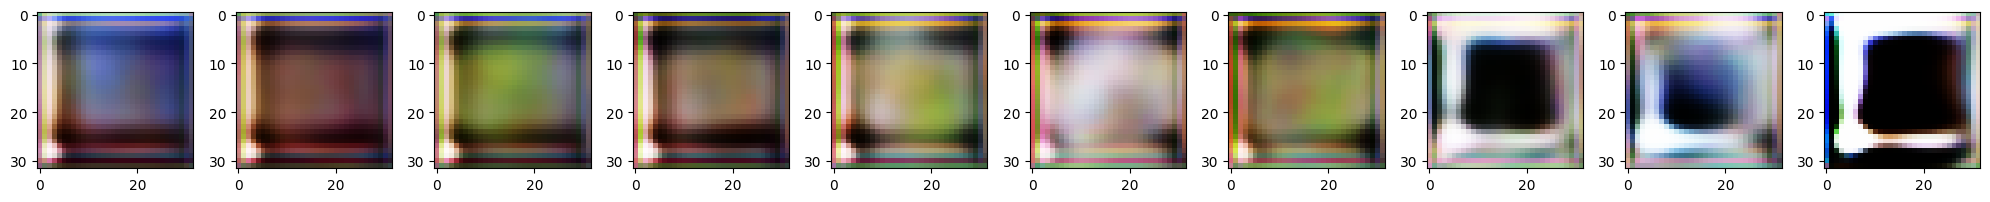

196/196 [==============================] - 270s 1s/step - loss: 1.9546 - d_loss: 1.3037 - g_loss: 0.6509
Epoch 2/500
108/196 [===============>..............] - ETA: 1:45 - loss: 2.0550 - d_loss: 1.4906 - g_loss: 0.5644

In [ ]:
_ = train_generator(X=X, y=y, model_size="default", verbose=1)

_

In [ ]:
# noise = tf.random.normal(shape=(10, latent_dim))
# labels = tfk.utils.to_categorical(tf.cast(tf.math.floormod(tf.range(0,num_samples), num_classes), 'float32'))

In [137]:
def generate_samples_keras(path, num_samples=10):
    noise = tf.random.normal(shape=(num_samples, 32))
    labels = tfk.utils.to_categorical(
        tf.cast(tf.math.floormod(tf.range(0, num_samples), 10), "float32")
    )
    gen_input = tf.concat([noise, labels], axis=-1)

    custom_objects = {
        "ConditionalBatchNorm": ConditionalBatchNorm,
        "SelfAttention": SelfAttention,
        "GlobalSumPooling2D": GlobalSumPooling2D,
    }
    generator = tfk.models.load_model(path, custom_objects=custom_objects)
    generated_images = generator(gen_input).numpy()
    fig, axes = plt.subplots(1, 10, figsize=(20, 2 * 10))
    for i in range(10):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i % 10]
        ax.imshow(np.squeeze(img), cmap="gray")
    plt.tight_layout()
    plt.show()

    return generated_images


path = "gan_gen_prova"
num_samples = 100
data = generate_samples_keras(path, num_samples)
print(f"Dataset shape: {data.shape}")

ValueError: Unable to find node root.layer_with_weights-2.layer.

2023-02-27 10:19:13.642964845 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 6518, index: 8, mask: {9, 65, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 10:19:13.643081575 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 6522, index: 12, mask: {13, 69, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 10:19:13.642993100 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 6519, index: 9, mask: {10, 66, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 10:19:13.654911766 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 6527, index: 17, mask: {18, 74, }, error code: 22 error msg: Invalid argument. Spec

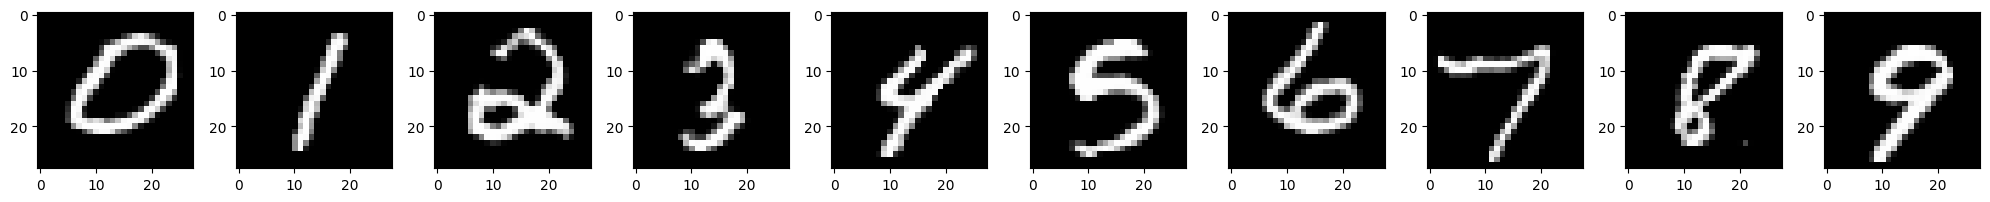

Dataset shape: (100, 28, 28, 1)


In [10]:
def generate_samples_onnx(path, num_samples):
    noise = tf.random.normal(shape=(num_samples, 128))
    labels = tfk.utils.to_categorical(
        tf.cast(tf.math.floormod(tf.range(0, num_samples), 10), "float32")
    )
    gen_input = np.array(tf.concat([noise, labels], axis=-1))

    session = rt.InferenceSession(path)
    generated_images = session.run(["act2"], {"input_37": gen_input})[0]
    fig, axes = plt.subplots(1, 10, figsize=(20, 2 * 10))
    for i in range(10):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i % 10]
        ax.imshow(np.squeeze(img), cmap="gray")
    plt.tight_layout()
    plt.show()

    return generated_images


path = "gan_gen_prova.onnx"
num_samples = 100
data = generate_samples_onnx(path, num_samples)
print(f"Dataset shape: {data.shape}")

In [ ]:
generator = tfk.models.load_model("gan_gen_prova")
generated_images = generator([noise, labels]).numpy()
fig, axes = plt.subplots(1, 10, figsize=(20, 2 * 10))
for i in range(10):
    img = tfk.preprocessing.image.array_to_img(generated_images[i])
    ax = axes[i % 10]
    ax.imshow(np.squeeze(img), cmap="gray")
plt.tight_layout()
plt.show()

NameError: name 'latent_dim' is not defined

In [71]:
generator = tfk.models.load_model("gan_gen_prova")

In [73]:
generator.layers[0].output_shape

[(None, 138)]

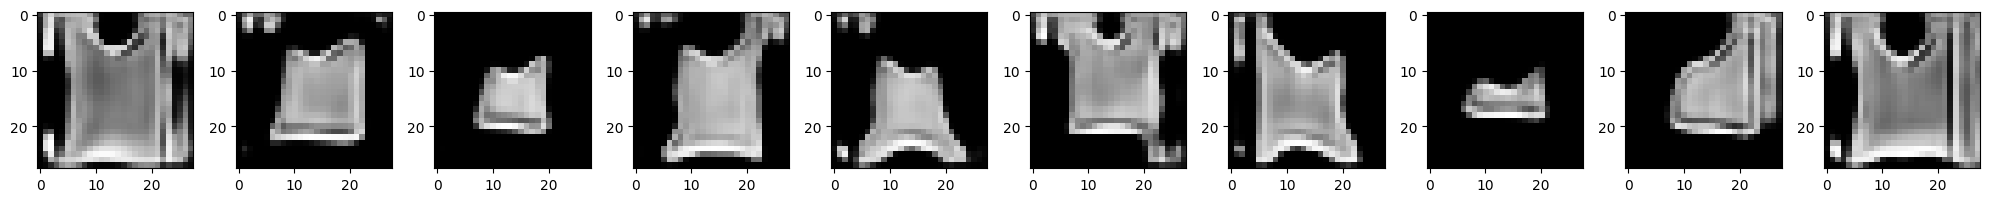

In [36]:
generator = tfk.models.load_model("gan_gen_prova")
generated_images = generator([noise, labels]).numpy()
fig, axes = plt.subplots(1, 10, figsize=(20, 2 * 10))
for i in range(10):
    img = tfk.preprocessing.image.array_to_img(generated_images[i])
    ax = axes[i % 10]
    ax.imshow(np.squeeze(img), cmap="gray")
plt.tight_layout()
plt.show()

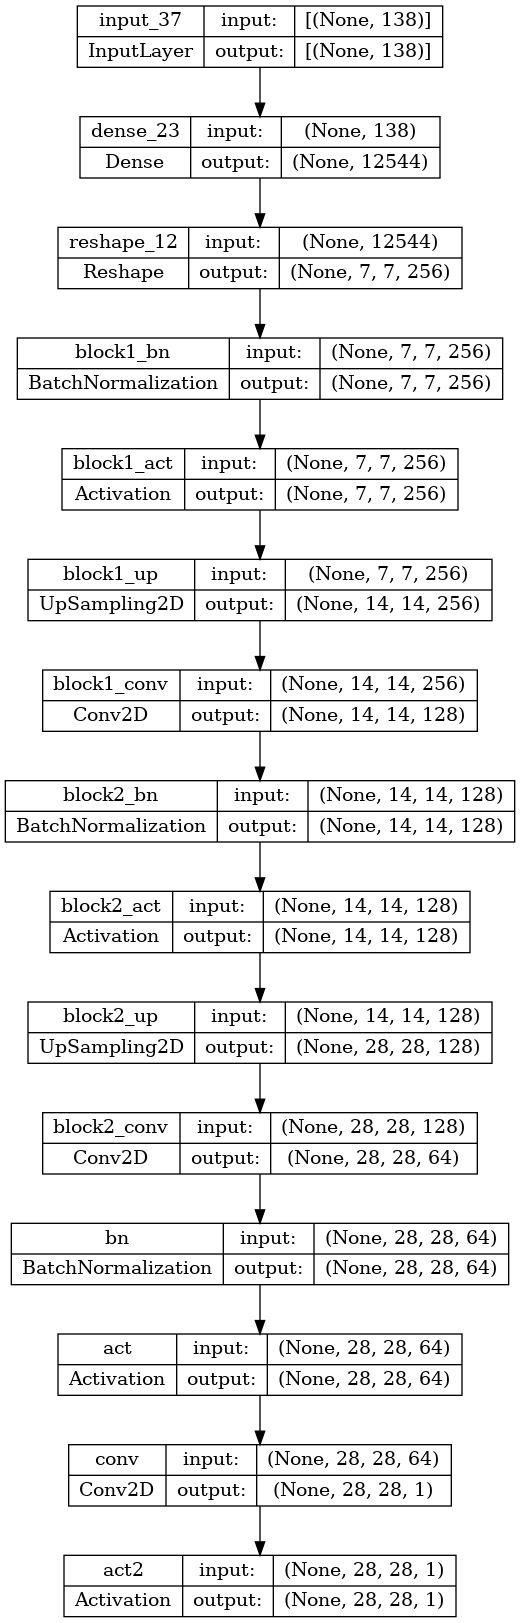

In [98]:
tfk.utils.plot_model(generator, show_shapes=True)

In [101]:
spec = (tf.TensorSpec((None, 128 + 10), tf.float32, name="input_37"),)
output_path = "gan_gen_prova.onnx"
model_proto, _ = tf2onnx.convert.from_keras(
    generator, input_signature=spec, opset=13, output_path=output_path
)
input_names = [n.name for n in model_proto.graph.input]
output_names = [n.name for n in model_proto.graph.output]

2023-02-27 00:08:12.054169: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-27 00:08:12.054397: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-02-27 00:08:12.058134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22783 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:28:00.0, compute capability: 7.5
2023-02-27 00:08:12.250943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22783 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:28:00.0, compute capability: 7.5
2023-02-27 00:08:12.275062: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-27 00:08:12.275195: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting ne

In [109]:
gen_input

<tf.Tensor: shape=(10, 138), dtype=float32, numpy=
array([[-0.31635553, -0.02059077, -1.8537605 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.37712795,  0.10734624, -0.51189256, ...,  0.        ,
         0.        ,  0.        ],
       [-1.8802301 , -0.23295262, -0.20204961, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.6140784 ,  2.3809931 , -0.9069605 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.22581156, -1.1047206 , -1.4012809 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.1028775 , -0.6896851 , -0.67302734, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)>

In [110]:
noise = tf.random.normal(shape=(10, 128))
labels = tfk.utils.to_categorical(
    tf.cast(tf.math.floormod(tf.range(0, num_samples), 10), "float32")
)
gen_input = np.array(tf.concat([noise, labels], axis=-1))
session = rt.InferenceSession("gan_gen_prova.onnx")
onnx_pred = session.run(output_names, {"input_37": gen_input})

2023-02-27 00:16:05.602194383 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 5289, index: 7, mask: {8, 64, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 00:16:05.611547927 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 5290, index: 8, mask: {9, 65, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 00:16:05.611552509 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 5292, index: 10, mask: {11, 67, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-27 00:16:05.611617538 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 5294, index: 12, mask: {13, 69, }, error code: 22 error msg: Invalid argument. Speci

In [111]:
onnx_pred

[array([[[[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]],
 
         [[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]],
 
         [[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]],
 
         ...,
 
         [[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]],
 
         [[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]],
 
         [[-1.       ],
          [-1.       ],
          [-1.       ],
          ...,
          [-1.       ],
          [-1.       ],
          [-1.       ]]],
 
 
        [

In [62]:
[n.name for n in model_proto.graph.input]

['input_14', 'input_13']

In [61]:
output_names

['act2']

In [64]:
noise.dtype

tf.float32

In [65]:
labels.dtype

tf.int32

In [69]:
a = {"input_14": noise, "input_13": tf.expand_dims(labels, axis=-1)}


# a = {"input_14": noise, "input_13": labels}
a

{'input_14': <tf.Tensor: shape=(10, 128), dtype=float32, numpy=
 array([[ 0.6221494 ,  0.39071774,  0.5728211 , ...,  0.7167322 ,
         -0.5511664 , -1.0641488 ],
        [-1.5657004 ,  0.07421897,  2.9614358 , ...,  0.01676579,
          0.16329654, -0.73383087],
        [-1.447201  , -1.6675326 ,  0.5504793 , ..., -0.01000746,
         -0.6912426 , -0.23076954],
        ...,
        [-1.1473866 , -0.04994768, -0.8671873 , ...,  1.6133465 ,
          1.3280439 ,  0.5758743 ],
        [-0.23210254,  0.49843383, -0.30794153, ..., -0.525052  ,
          1.2905878 , -1.8558377 ],
        [-0.2142031 , -1.6010133 , -2.5413163 , ...,  0.25480446,
          0.4304059 , -0.482241  ]], dtype=float32)>,
 'input_13': <tf.Tensor: shape=(10, 1), dtype=int32, numpy=
 array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]], dtype=int32)>}

In [68]:
noise.shape, labels.shape

(TensorShape([10, 128]), TensorShape([10]))

In [70]:
session = onnxruntime.InferenceSession("gan_gen_prova.onnx")
onnx_pred = session.run([output_names], a)

2023-02-26 20:39:26.185643831 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 1197, index: 7, mask: {8, 64, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-26 20:39:26.195466052 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 1200, index: 10, mask: {11, 67, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-26 20:39:26.195467629 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 1243, index: 53, mask: {54, 110, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2023-02-26 20:39:26.195467039 [E:onnxruntime:Default, env.cc:251 ThreadMain] pthread_setaffinity_np failed for thread: 1201, index: 11, mask: {12, 68, }, error code: 22 error msg: Invalid argument. Sp

TypeError: run(): incompatible function arguments. The following argument types are supported:
    1. (self: onnxruntime.capi.onnxruntime_pybind11_state.InferenceSession, arg0: List[str], arg1: Dict[str, object], arg2: onnxruntime.capi.onnxruntime_pybind11_state.RunOptions) -> List[object]

Invoked with: <onnxruntime.capi.onnxruntime_pybind11_state.InferenceSession object at 0x7fc56f5d5df0>, [['act2']], {'input_14': <tf.Tensor: shape=(10, 128), dtype=float32, numpy=
array([[ 0.6221494 ,  0.39071774,  0.5728211 , ...,  0.7167322 ,
        -0.5511664 , -1.0641488 ],
       [-1.5657004 ,  0.07421897,  2.9614358 , ...,  0.01676579,
         0.16329654, -0.73383087],
       [-1.447201  , -1.6675326 ,  0.5504793 , ..., -0.01000746,
        -0.6912426 , -0.23076954],
       ...,
       [-1.1473866 , -0.04994768, -0.8671873 , ...,  1.6133465 ,
         1.3280439 ,  0.5758743 ],
       [-0.23210254,  0.49843383, -0.30794153, ..., -0.525052  ,
         1.2905878 , -1.8558377 ],
       [-0.2142031 , -1.6010133 , -2.5413163 , ...,  0.25480446,
         0.4304059 , -0.482241  ]], dtype=float32)>, 'input_13': <tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]], dtype=int32)>}, None

In [28]:
noise = tf.random.normal(shape=(10, latent_dim))
labels = tf.cast(tf.math.floormod(tf.range(0, 10), 10), "int32")
generated_images = generator([noise, labels]).numpy()

In [12]:
import tf2onnx


spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = model.name + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(
    model, input_signature=spec, opset=13, output_path=output_path
)
output_names = [n.name for n in model_proto.graph.output]

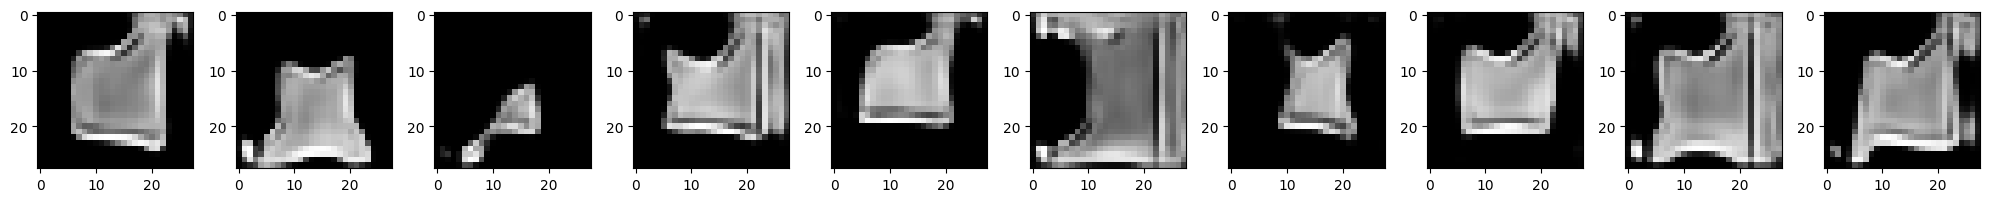

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 64)        704         ['input_22[0][0]']               
                                                                                                  
 input_21 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 64)           0           ['embedding_10[0][0]']           
                                                                                           

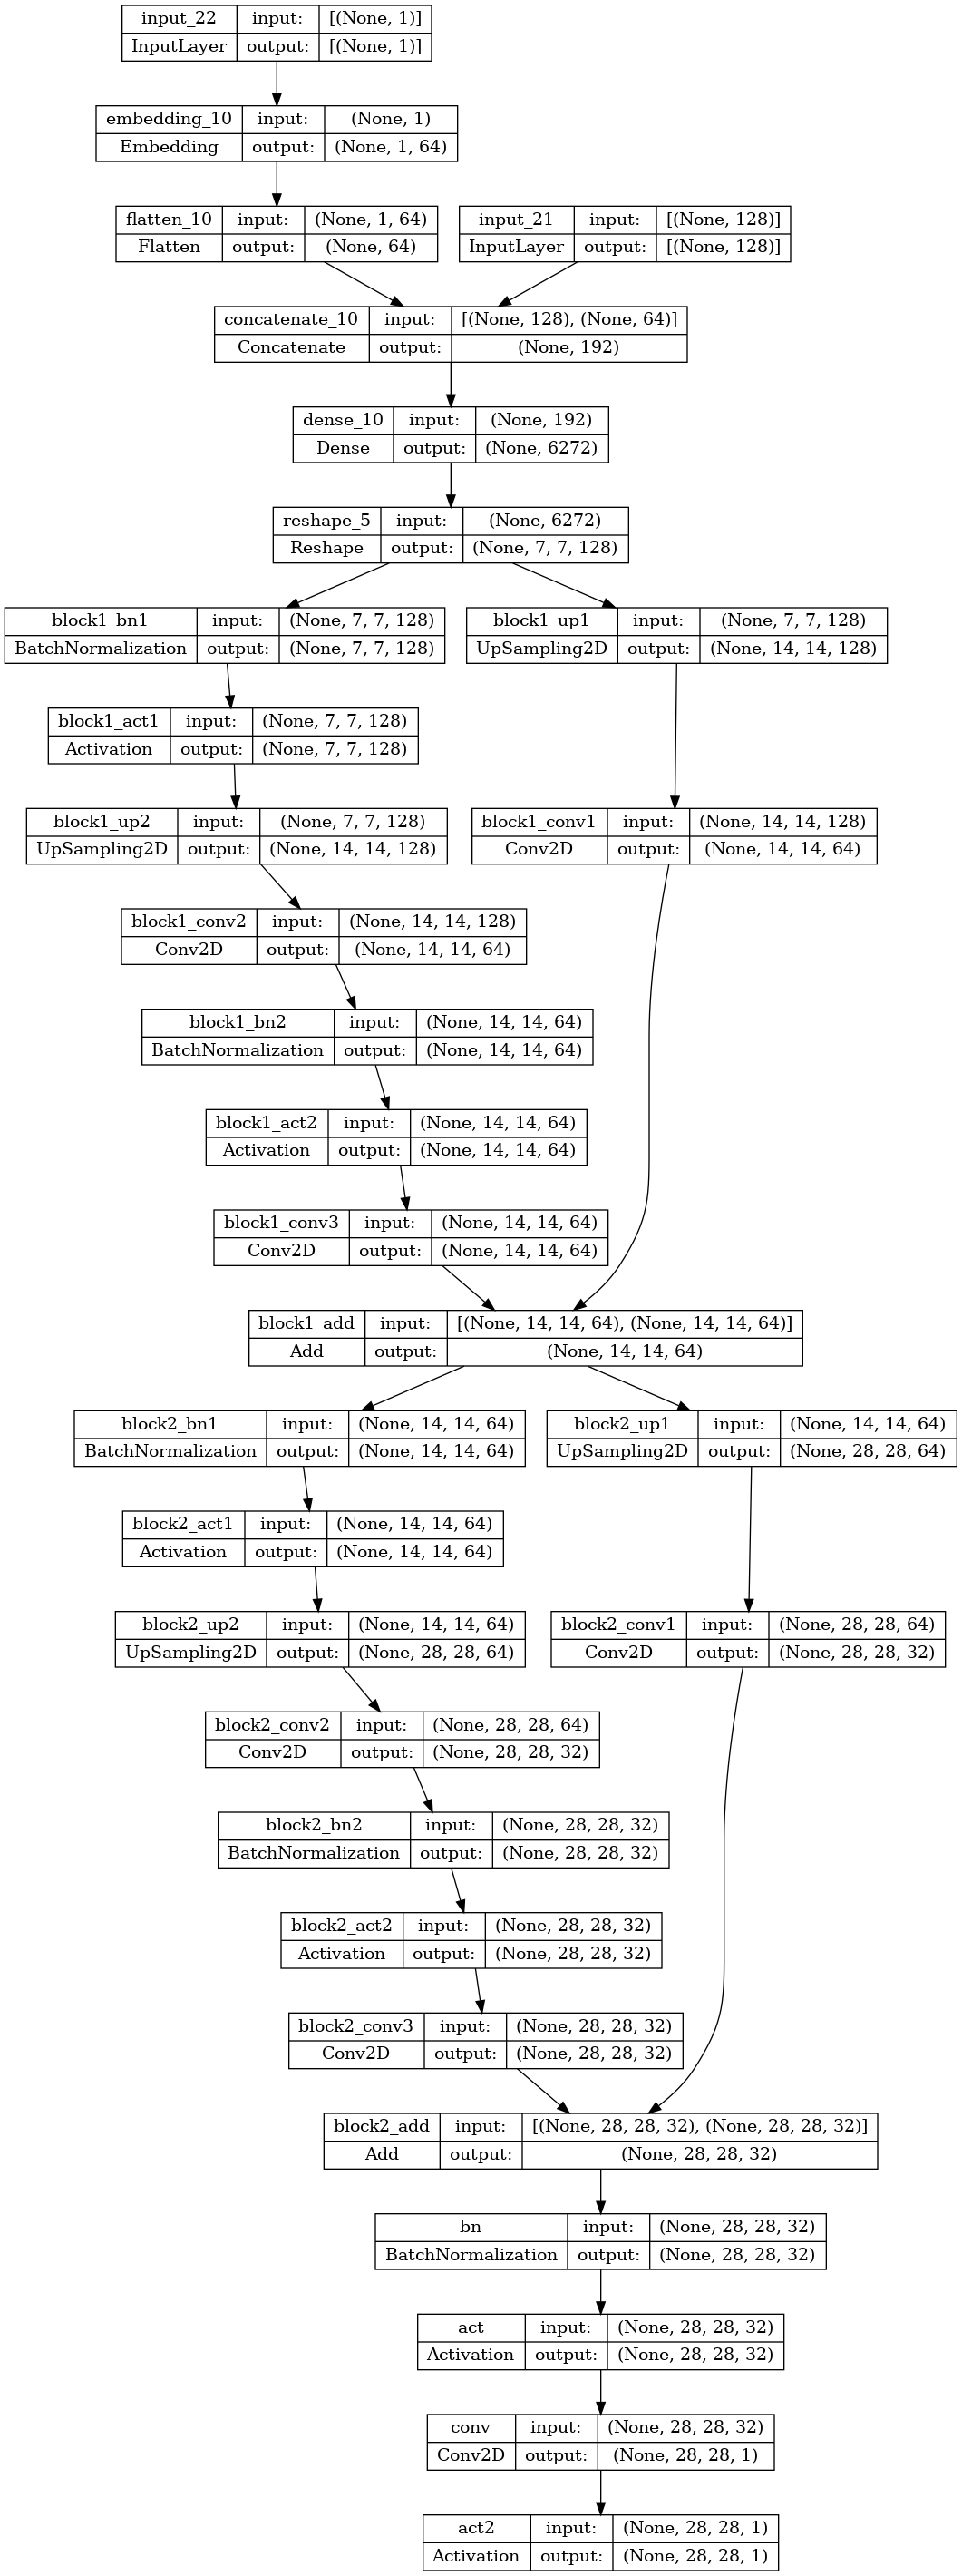

In [108]:
gen = build_generator(
    output_shape=metadata["shape"][1:],
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    num_classes=10,
    filters=32,
    blocks=2,
)
gen.summary()
tfk.utils.plot_model(gen, show_shapes=True, expand_nested=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv0 (Conv2D)                 (None, 28, 28, 32)   320         ['input_11[0][0]']               
                                                                                                  
 block1_act1 (Activation)       (None, 28, 28, 32)   0           ['conv0[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   2112        ['block1_act1[0][0]']            
                                                                                            

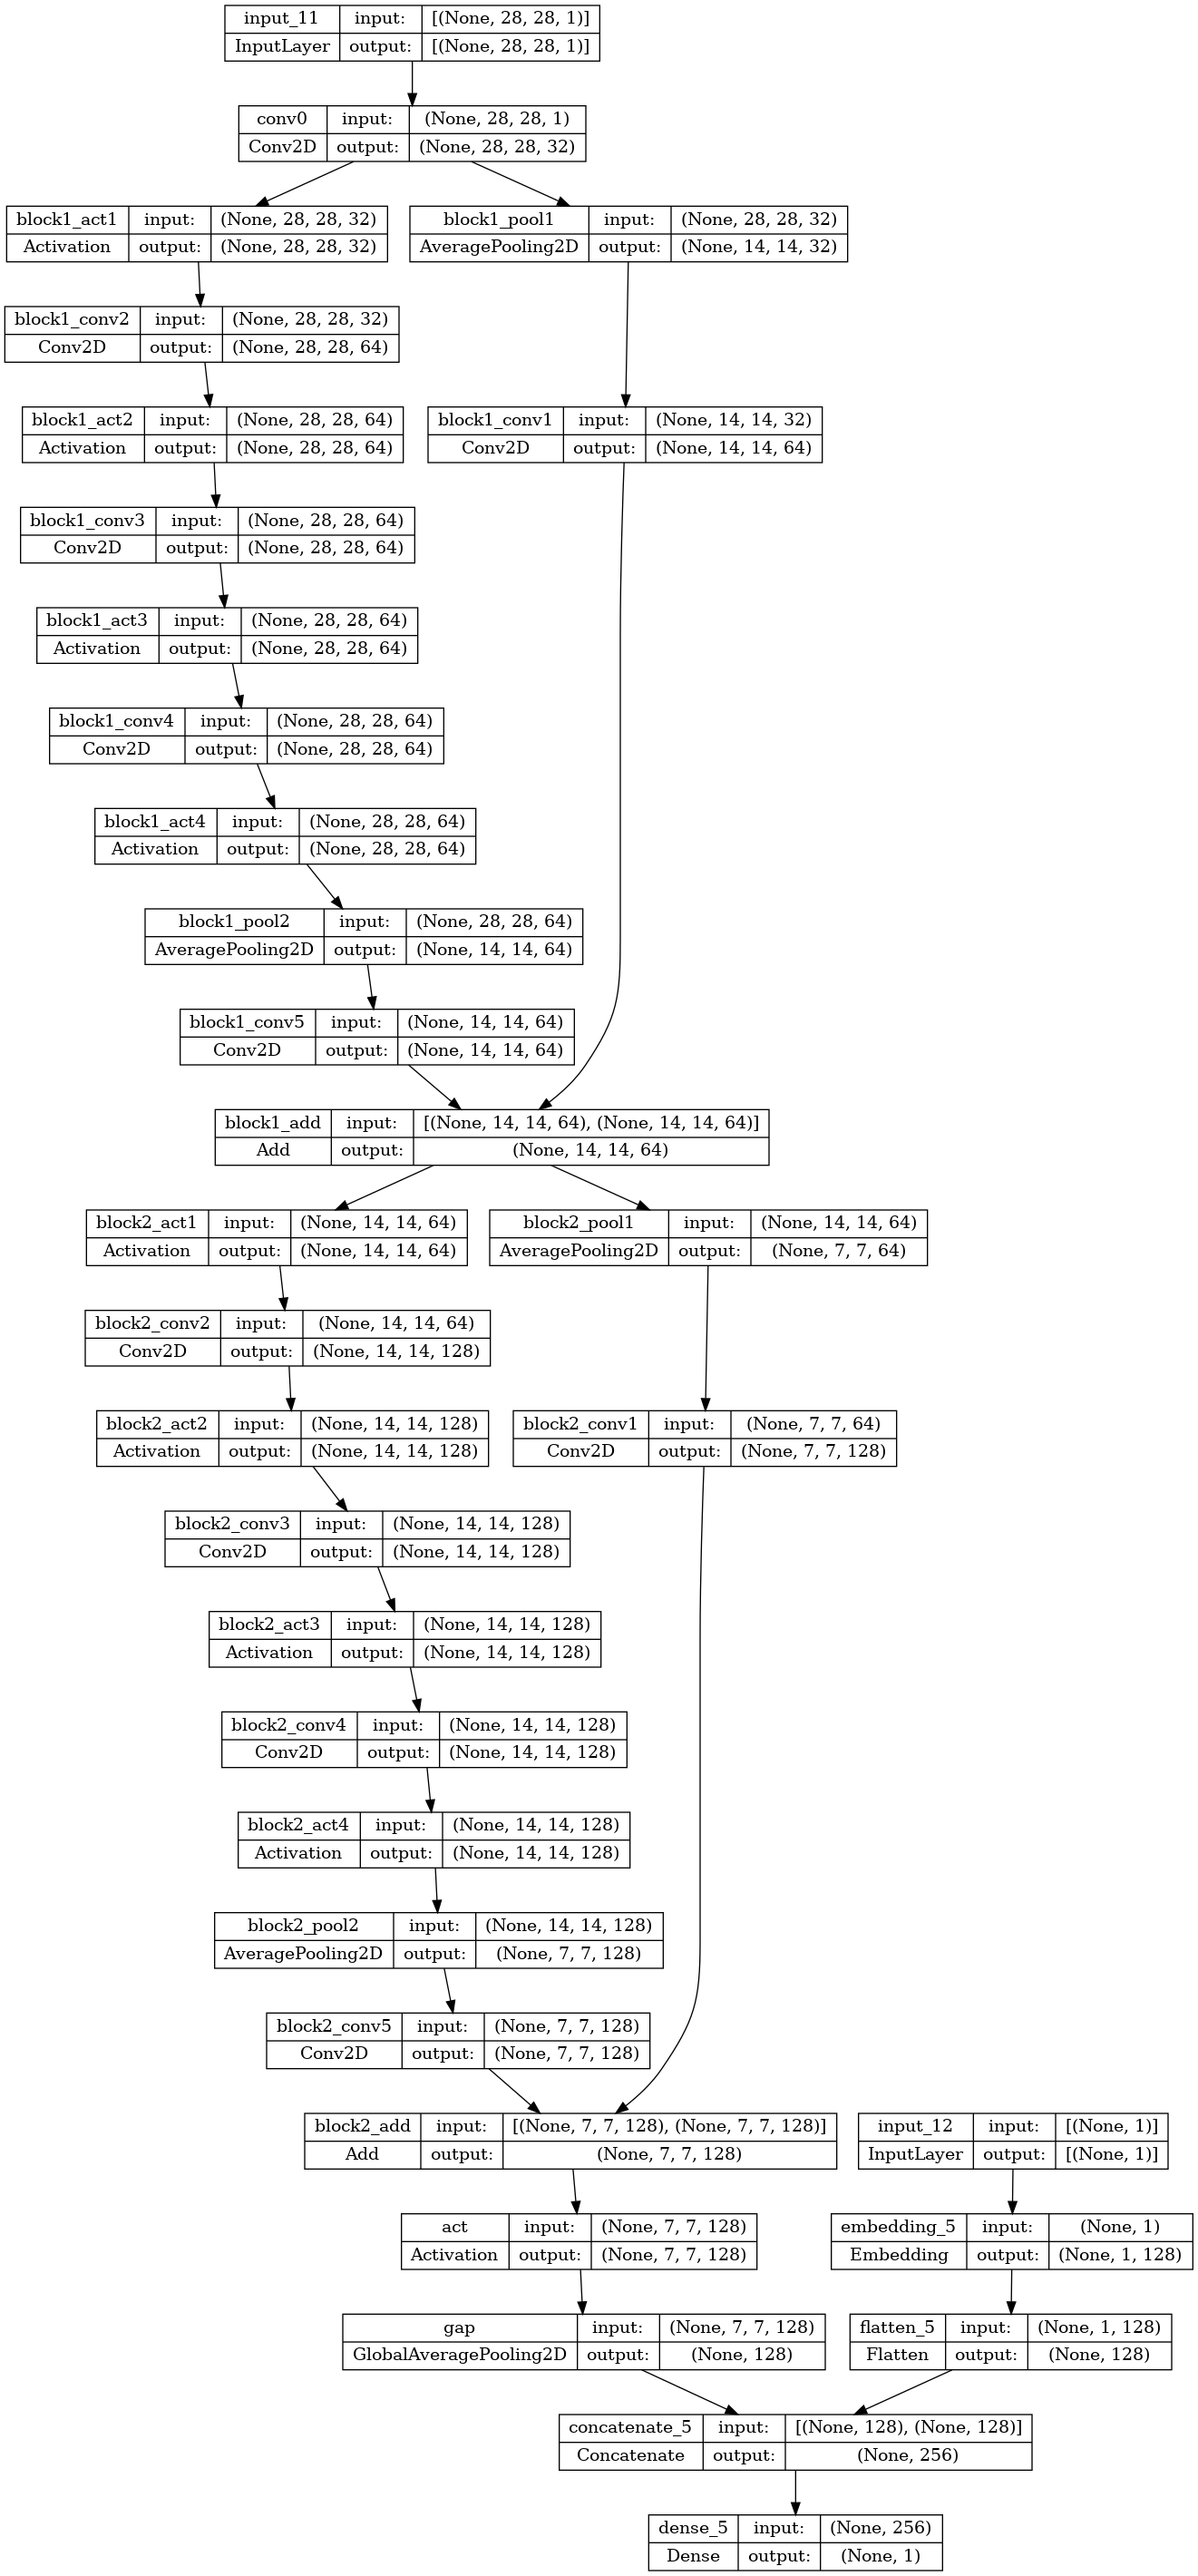

In [28]:
disc = build_discriminator(metadata["shape"][1:], 32, 10, latent_dim, 2)
disc.summary()
tfk.utils.plot_model(disc, show_shapes=True, expand_nested=True)

In [30]:
num_classes = 10

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [37]:
class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name="", gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray
        self.noise = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.labels = tf.cast(
            tf.math.floormod(tf.range(0, self.num_img), num_classes), "int32"
        )

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator([self.noise, self.labels]).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20, 2 * self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i % self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap="gray")
            else:
                ax.imshow(np.squeeze(img))
        plt.tight_layout()
        plt.show()


learning_rate = 1e-4

In [38]:
epochs = 100
cb = [ConditionalGANMonitor(gray=True)]

discriminator_rounds = 3

gan = ConditionalHingeGAN(
    discriminator=build_discriminator(metadata["shape"][1:], 32, 10, latent_dim, 2),
    generator=build_generator(metadata["shape"][1:], latent_dim, 10, 32, 2),
    latent_dim=latent_dim,
    discriminator_rounds=discriminator_rounds,
)
gan.compile(
    d_optimizer=tfk.optimizers.Adam(
        learning_rate=learning_rate, beta_1=0, epsilon=1e-8
    ),
    g_optimizer=tfk.optimizers.experimental.Adam(
        learning_rate=learning_rate, beta_1=0, epsilon=1e-8, use_ema=True
    ),
)

Epoch 1/100
468/469 [============================>.] - ETA: 0s - loss: 2.1529 - d_loss: 1.8088 - g_loss: 0.3441

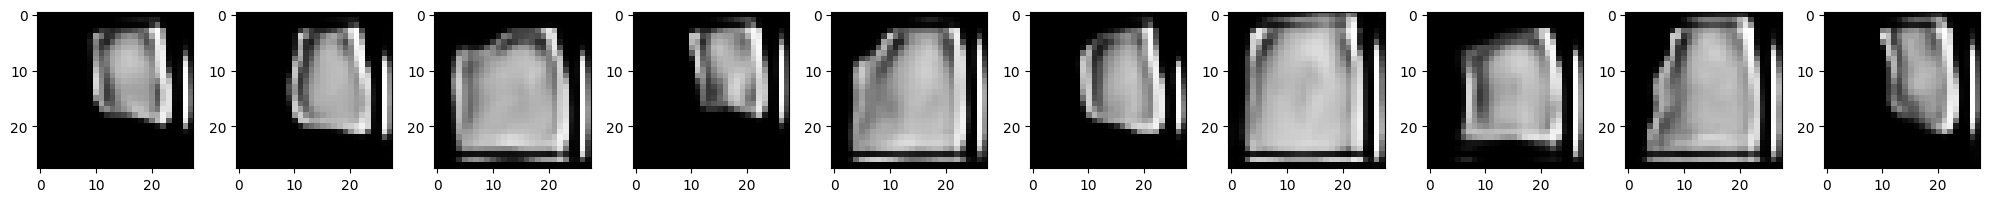

469/469 [==============================] - 30s 47ms/step - loss: 2.1519 - d_loss: 1.8092 - g_loss: 0.3427
Epoch 2/100
469/469 [==============================] - ETA: 0s - loss: 1.8747 - d_loss: 1.9407 - g_loss: -0.0661

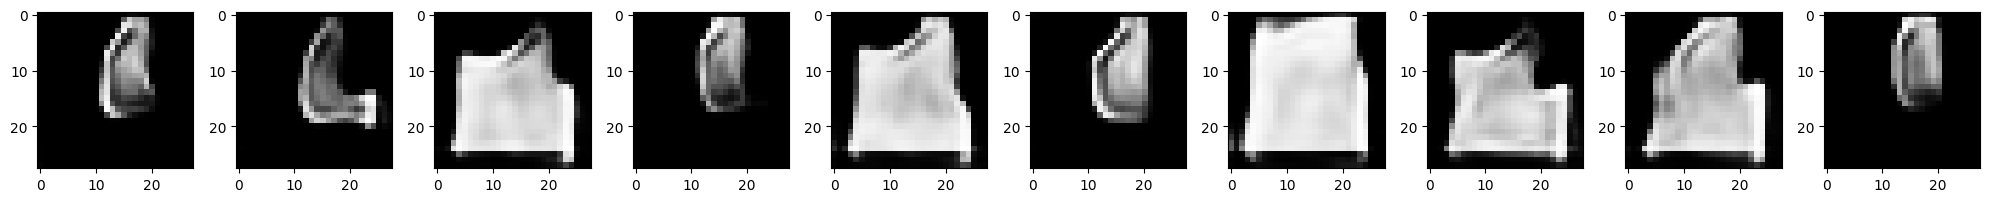

469/469 [==============================] - 22s 48ms/step - loss: 1.8747 - d_loss: 1.9407 - g_loss: -0.0661
Epoch 3/100
469/469 [==============================] - ETA: 0s - loss: 2.1531 - d_loss: 1.9573 - g_loss: 0.1958

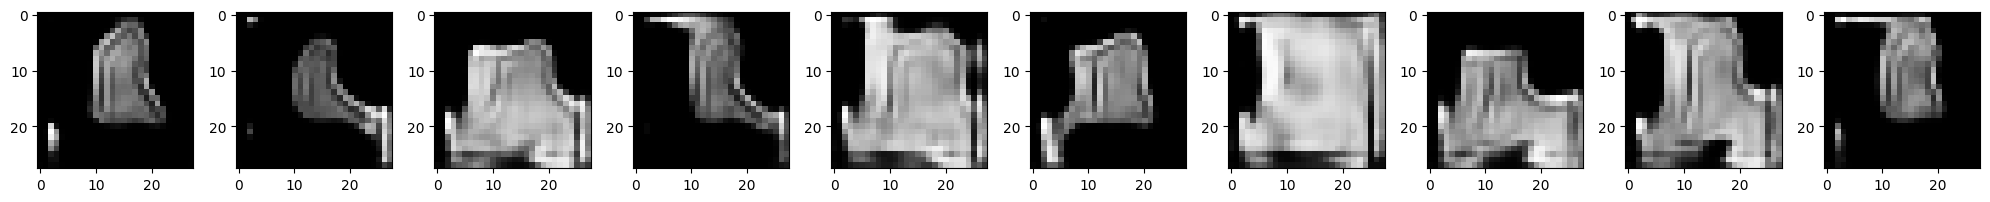

469/469 [==============================] - 22s 48ms/step - loss: 2.1531 - d_loss: 1.9573 - g_loss: 0.1958
Epoch 4/100
469/469 [==============================] - ETA: 0s - loss: 2.3451 - d_loss: 1.9741 - g_loss: 0.3710

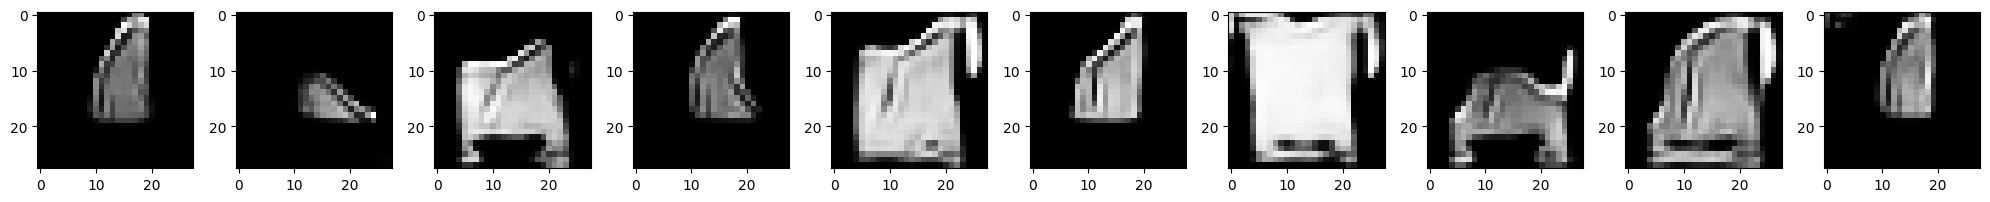

469/469 [==============================] - 22s 47ms/step - loss: 2.3451 - d_loss: 1.9741 - g_loss: 0.3710
Epoch 5/100
468/469 [============================>.] - ETA: 0s - loss: 2.1996 - d_loss: 1.9603 - g_loss: 0.2392

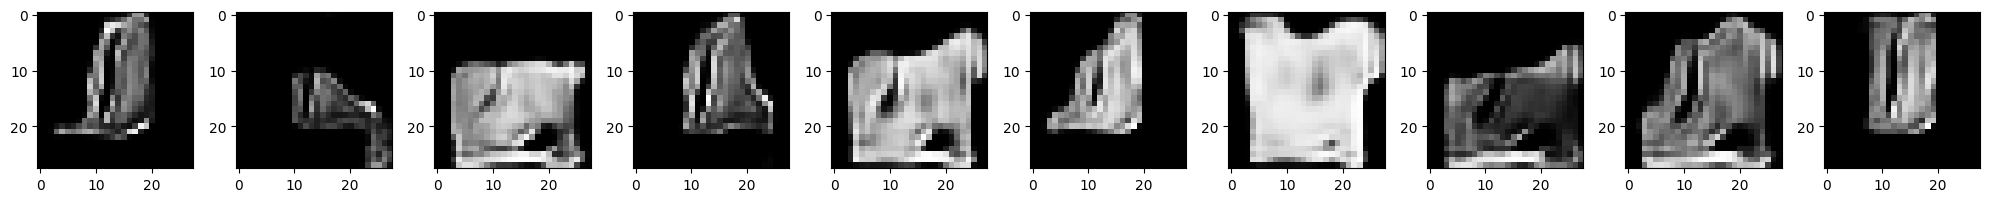

469/469 [==============================] - 22s 48ms/step - loss: 2.1998 - d_loss: 1.9604 - g_loss: 0.2394
Epoch 6/100
469/469 [==============================] - ETA: 0s - loss: 2.1044 - d_loss: 1.9289 - g_loss: 0.1755

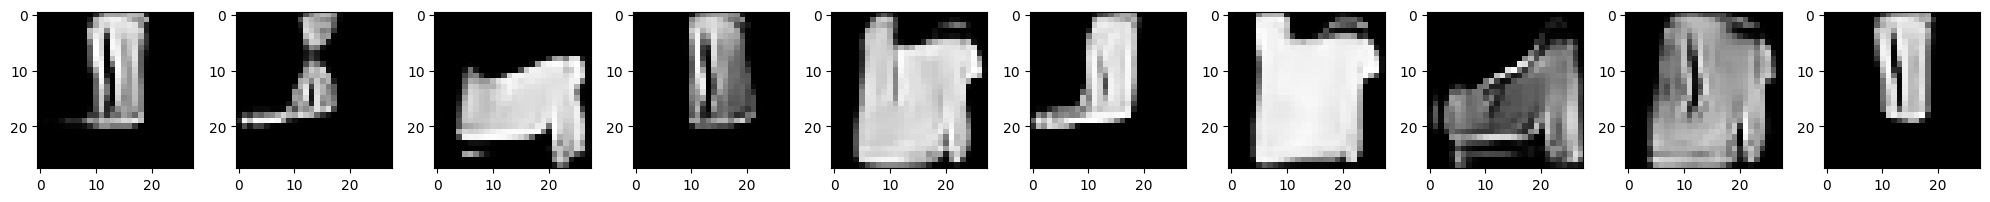

469/469 [==============================] - 22s 47ms/step - loss: 2.1044 - d_loss: 1.9289 - g_loss: 0.1755
Epoch 7/100
469/469 [==============================] - ETA: 0s - loss: 2.1392 - d_loss: 1.9429 - g_loss: 0.1963

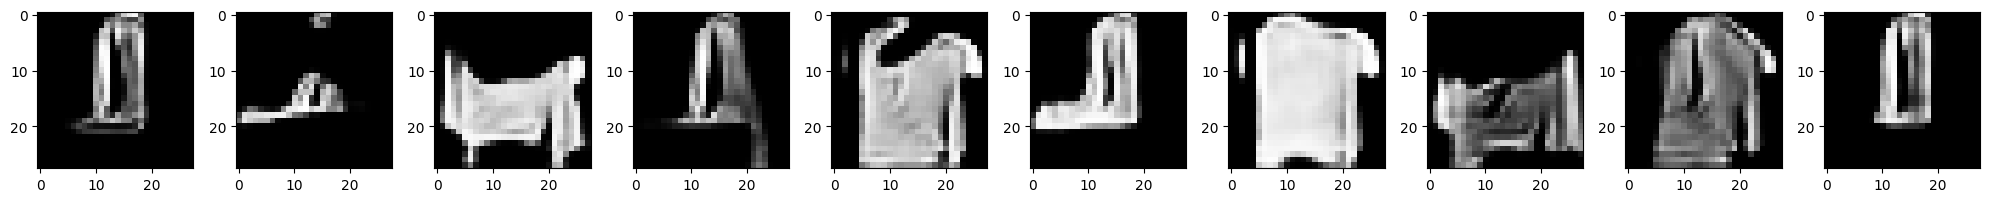

469/469 [==============================] - 22s 48ms/step - loss: 2.1392 - d_loss: 1.9429 - g_loss: 0.1963
Epoch 8/100
469/469 [==============================] - ETA: 0s - loss: 2.2648 - d_loss: 1.9597 - g_loss: 0.3051

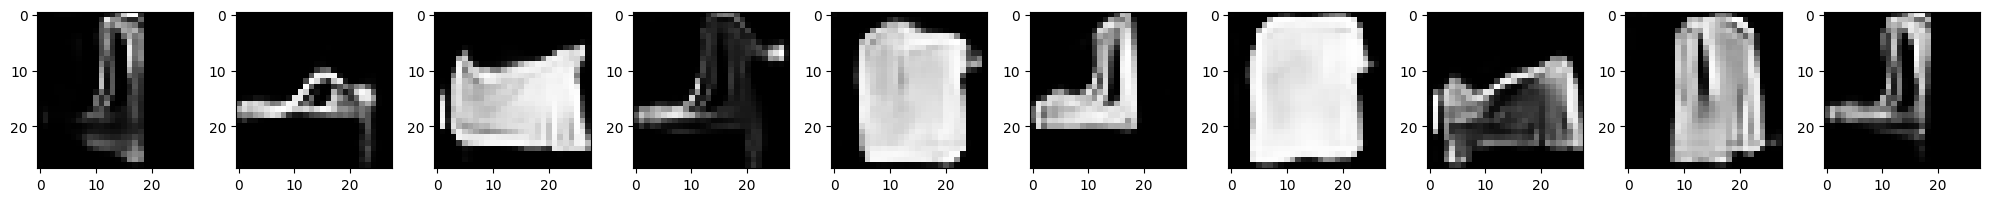

469/469 [==============================] - 22s 48ms/step - loss: 2.2648 - d_loss: 1.9597 - g_loss: 0.3051
Epoch 9/100
468/469 [============================>.] - ETA: 0s - loss: 2.0955 - d_loss: 1.9440 - g_loss: 0.1514

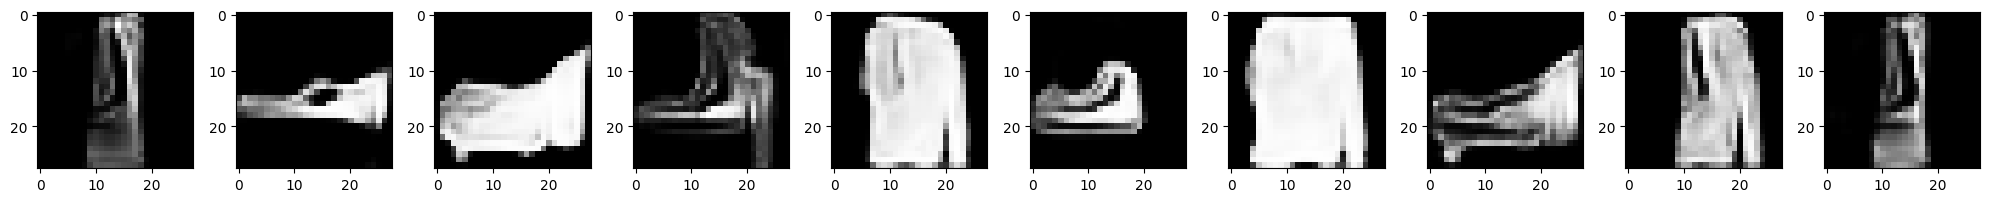

469/469 [==============================] - 22s 48ms/step - loss: 2.0954 - d_loss: 1.9441 - g_loss: 0.1513
Epoch 10/100
469/469 [==============================] - ETA: 0s - loss: 2.1297 - d_loss: 1.9518 - g_loss: 0.1779

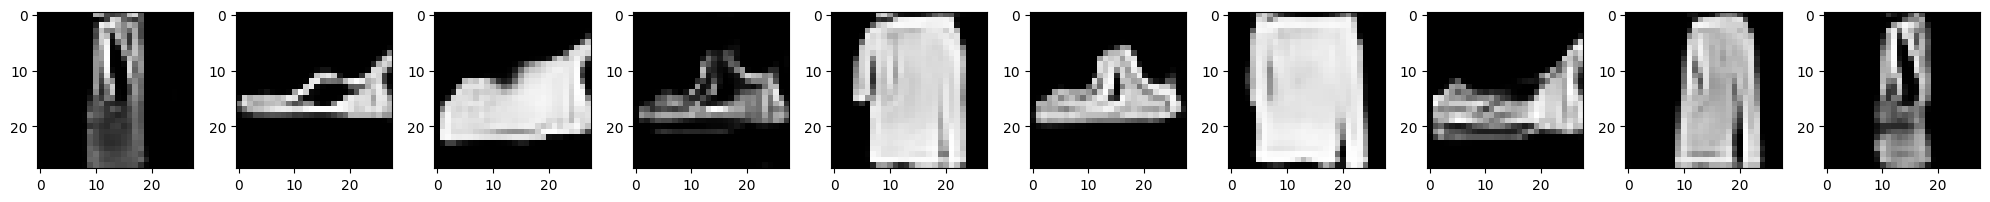

469/469 [==============================] - 22s 48ms/step - loss: 2.1297 - d_loss: 1.9518 - g_loss: 0.1779
Epoch 11/100
469/469 [==============================] - ETA: 0s - loss: 2.0769 - d_loss: 1.9530 - g_loss: 0.1239

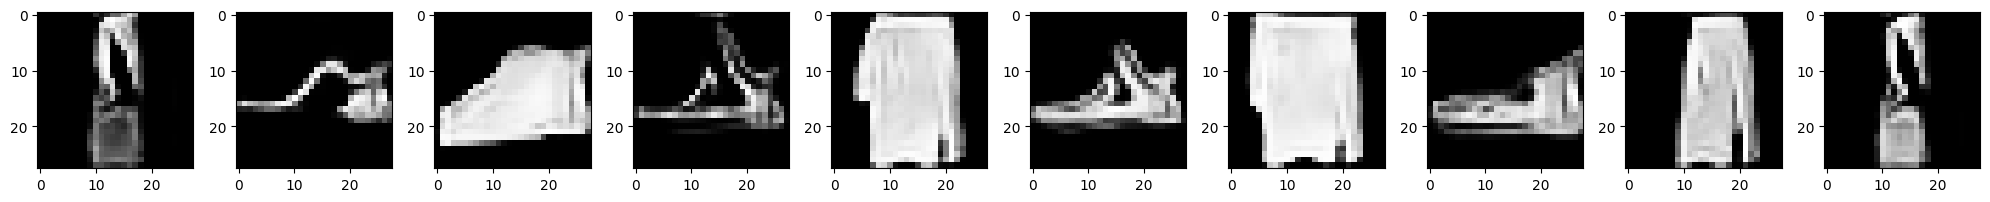

469/469 [==============================] - 22s 48ms/step - loss: 2.0769 - d_loss: 1.9530 - g_loss: 0.1239
Epoch 12/100
468/469 [============================>.] - ETA: 0s - loss: 2.1032 - d_loss: 1.9275 - g_loss: 0.1757

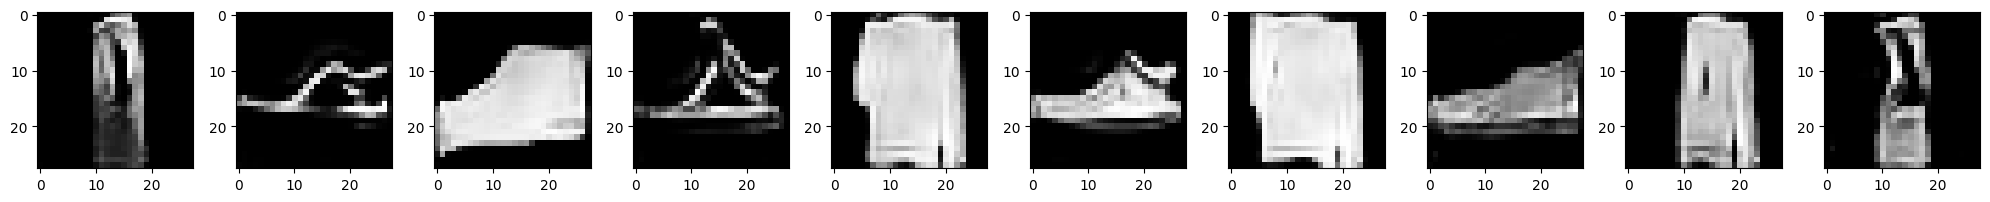

469/469 [==============================] - 22s 48ms/step - loss: 2.1035 - d_loss: 1.9277 - g_loss: 0.1758
Epoch 13/100
469/469 [==============================] - ETA: 0s - loss: 2.1923 - d_loss: 1.9615 - g_loss: 0.2308

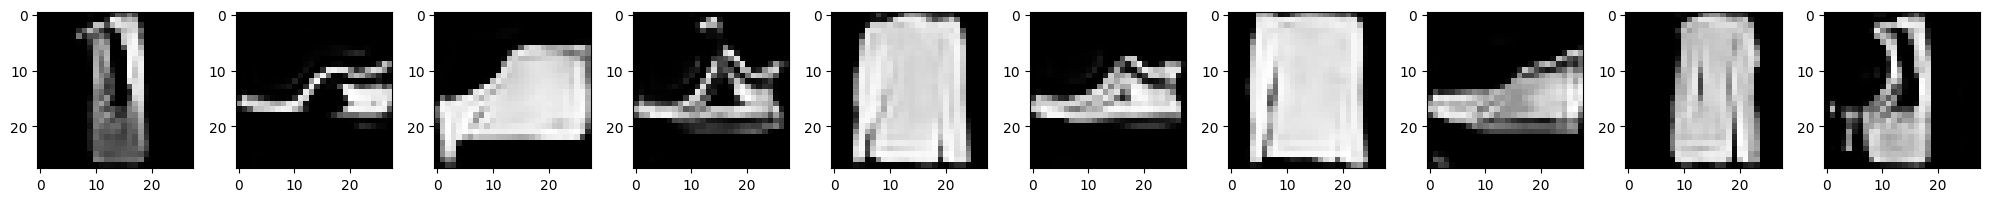

469/469 [==============================] - 22s 47ms/step - loss: 2.1923 - d_loss: 1.9615 - g_loss: 0.2308
Epoch 14/100
469/469 [==============================] - ETA: 0s - loss: 2.2606 - d_loss: 1.9670 - g_loss: 0.2936

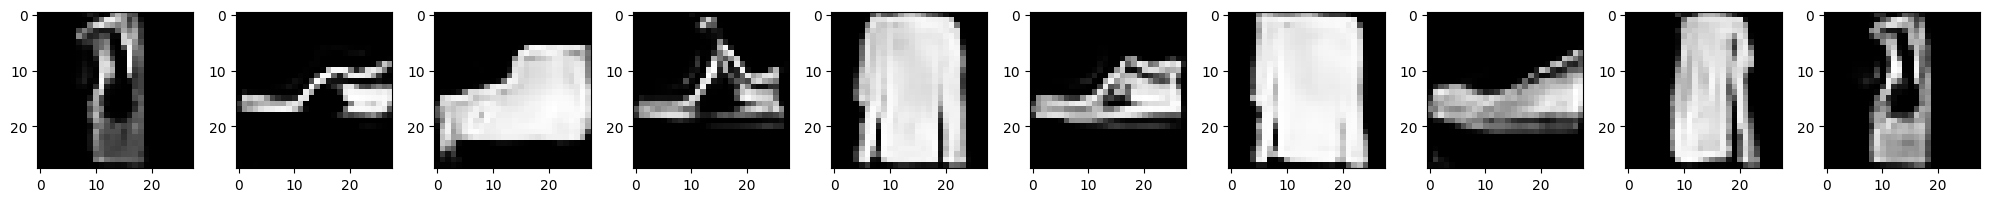

469/469 [==============================] - 23s 48ms/step - loss: 2.2606 - d_loss: 1.9670 - g_loss: 0.2936
Epoch 15/100
468/469 [============================>.] - ETA: 0s - loss: 2.1035 - d_loss: 1.9416 - g_loss: 0.1619

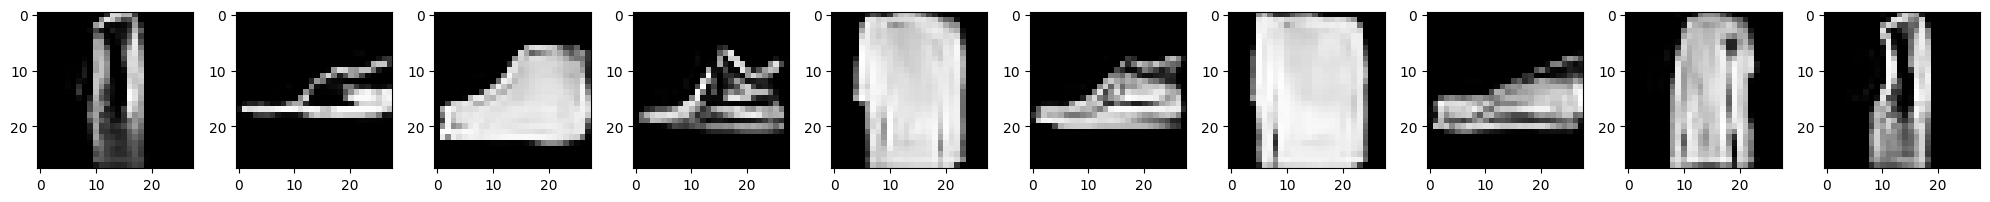

469/469 [==============================] - 22s 48ms/step - loss: 2.1039 - d_loss: 1.9416 - g_loss: 0.1622
Epoch 16/100
468/469 [============================>.] - ETA: 0s - loss: 2.2030 - d_loss: 1.9323 - g_loss: 0.2707

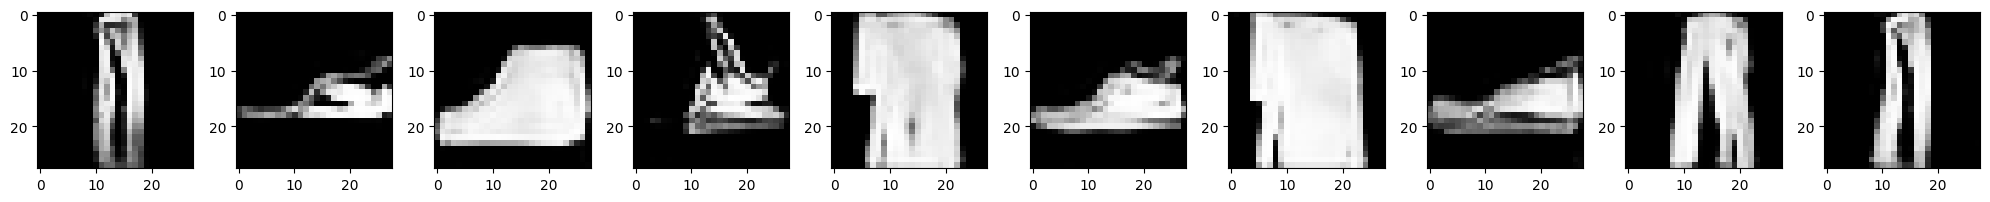

469/469 [==============================] - 22s 47ms/step - loss: 2.2022 - d_loss: 1.9321 - g_loss: 0.2700
Epoch 17/100
469/469 [==============================] - ETA: 0s - loss: 2.1538 - d_loss: 1.9189 - g_loss: 0.2350

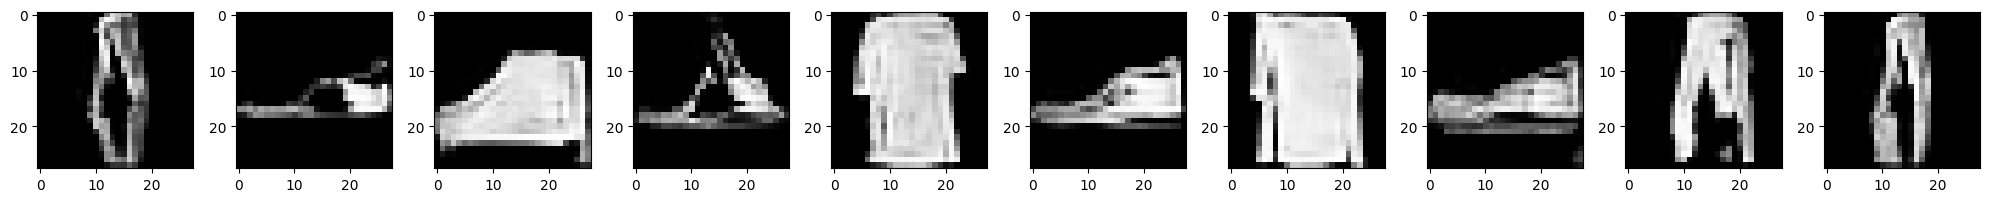

469/469 [==============================] - 22s 48ms/step - loss: 2.1538 - d_loss: 1.9189 - g_loss: 0.2350
Epoch 18/100
469/469 [==============================] - ETA: 0s - loss: 2.1592 - d_loss: 1.9033 - g_loss: 0.2559

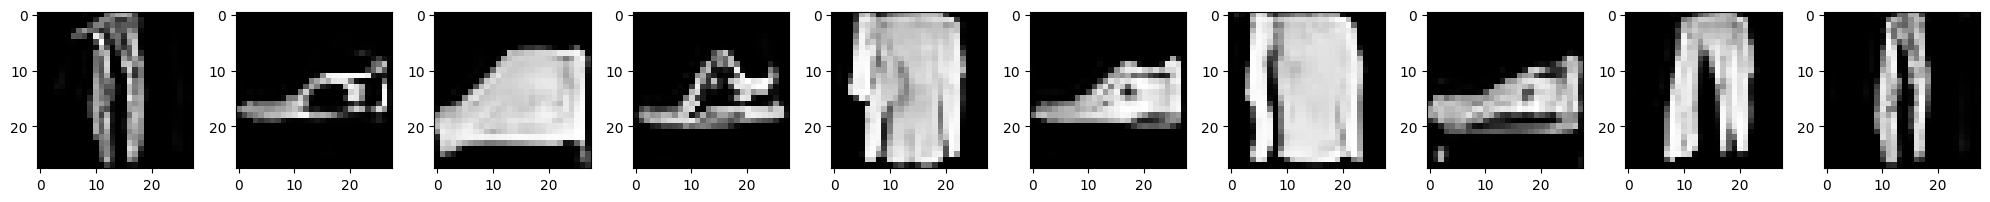

469/469 [==============================] - 22s 47ms/step - loss: 2.1592 - d_loss: 1.9033 - g_loss: 0.2559
Epoch 19/100
468/469 [============================>.] - ETA: 0s - loss: 2.1207 - d_loss: 1.9057 - g_loss: 0.2150

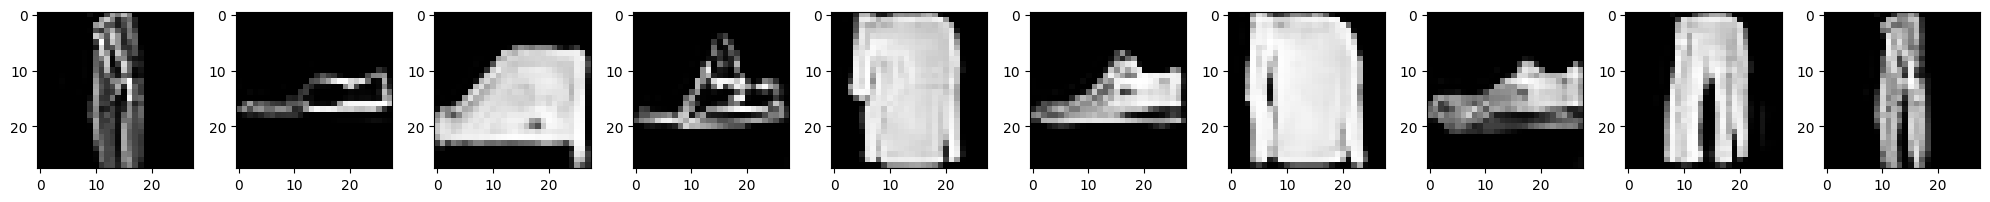

469/469 [==============================] - 22s 48ms/step - loss: 2.1197 - d_loss: 1.9055 - g_loss: 0.2142
Epoch 20/100
468/469 [============================>.] - ETA: 0s - loss: 2.1149 - d_loss: 1.8931 - g_loss: 0.2218

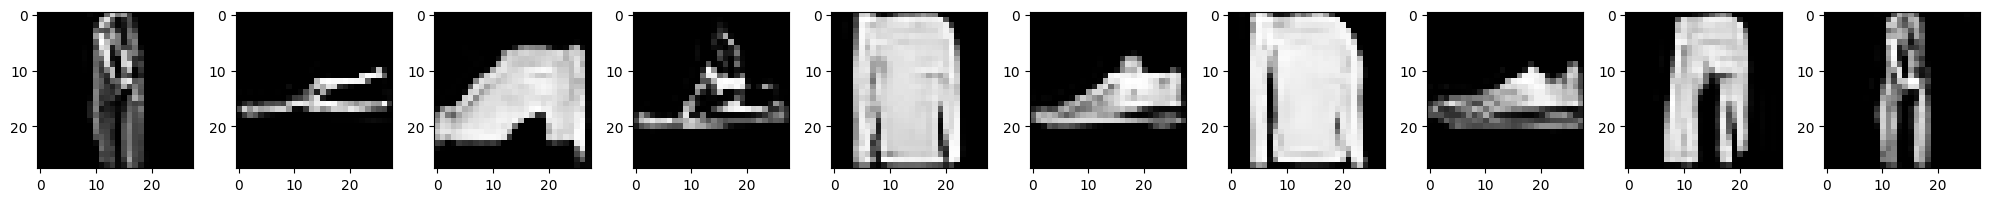

469/469 [==============================] - 23s 48ms/step - loss: 2.1139 - d_loss: 1.8930 - g_loss: 0.2209
Epoch 21/100
468/469 [============================>.] - ETA: 0s - loss: 2.0939 - d_loss: 1.8762 - g_loss: 0.2177

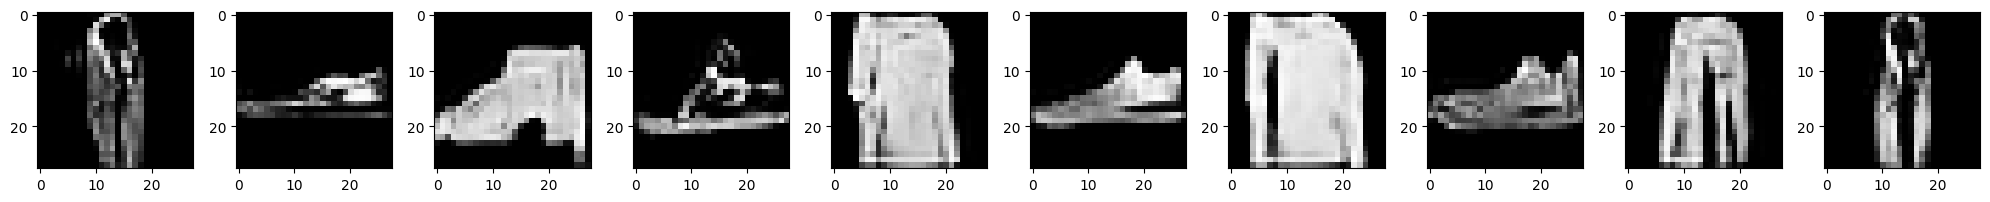

469/469 [==============================] - 22s 47ms/step - loss: 2.0910 - d_loss: 1.8758 - g_loss: 0.2152
Epoch 22/100
468/469 [============================>.] - ETA: 0s - loss: 2.2160 - d_loss: 1.9044 - g_loss: 0.3116

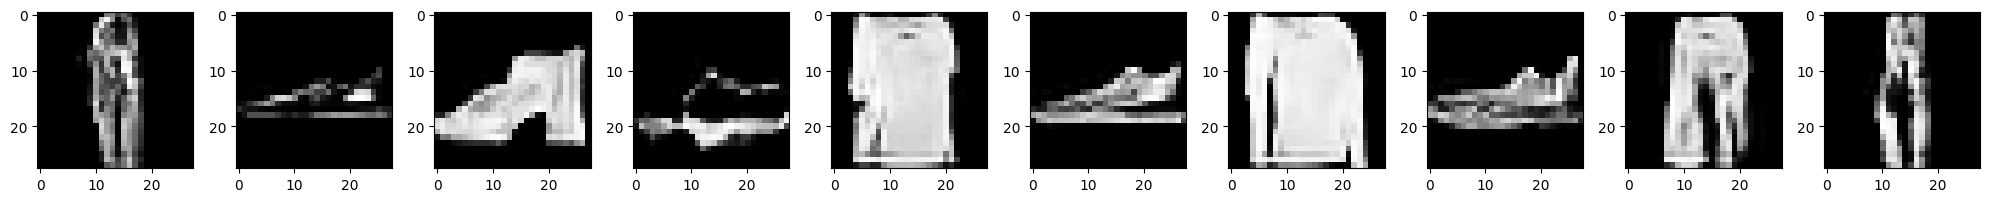

469/469 [==============================] - 22s 48ms/step - loss: 2.2162 - d_loss: 1.9045 - g_loss: 0.3117
Epoch 23/100
469/469 [==============================] - ETA: 0s - loss: 2.0807 - d_loss: 1.8534 - g_loss: 0.2273

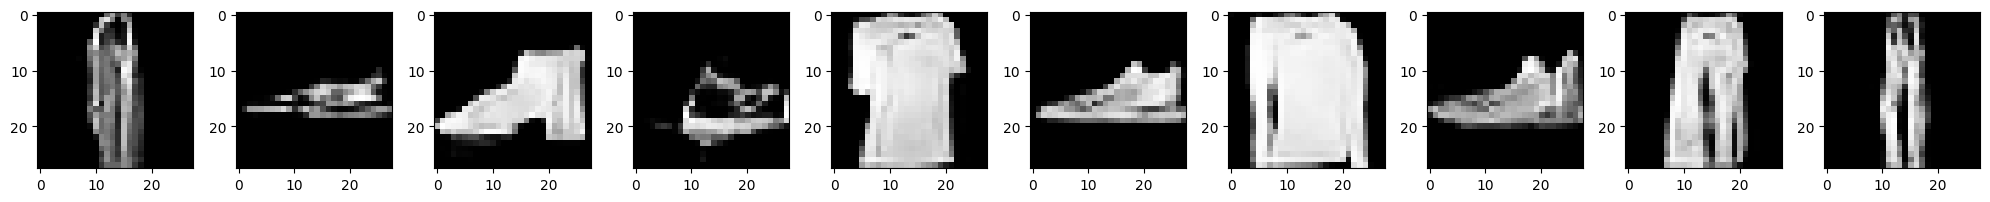

469/469 [==============================] - 22s 48ms/step - loss: 2.0807 - d_loss: 1.8534 - g_loss: 0.2273
Epoch 24/100
469/469 [==============================] - ETA: 0s - loss: 2.2672 - d_loss: 1.8906 - g_loss: 0.3766

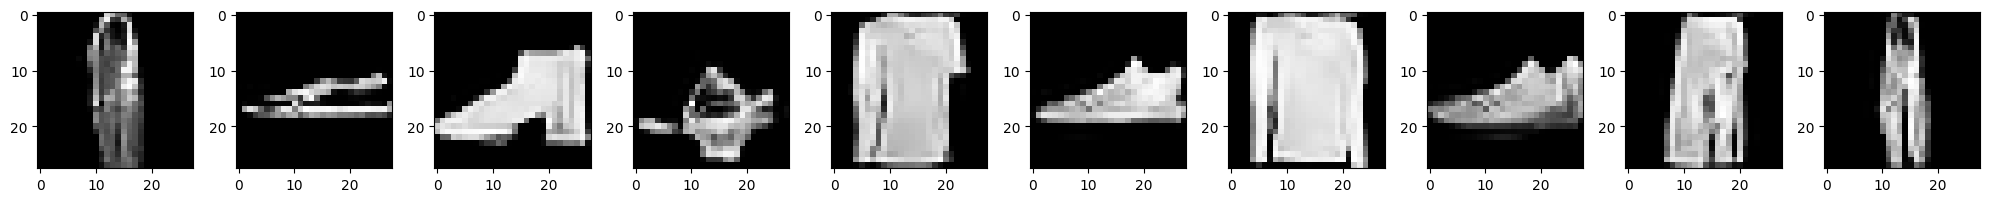

469/469 [==============================] - 22s 48ms/step - loss: 2.2672 - d_loss: 1.8906 - g_loss: 0.3766
Epoch 25/100
468/469 [============================>.] - ETA: 0s - loss: 2.2152 - d_loss: 1.8685 - g_loss: 0.3467

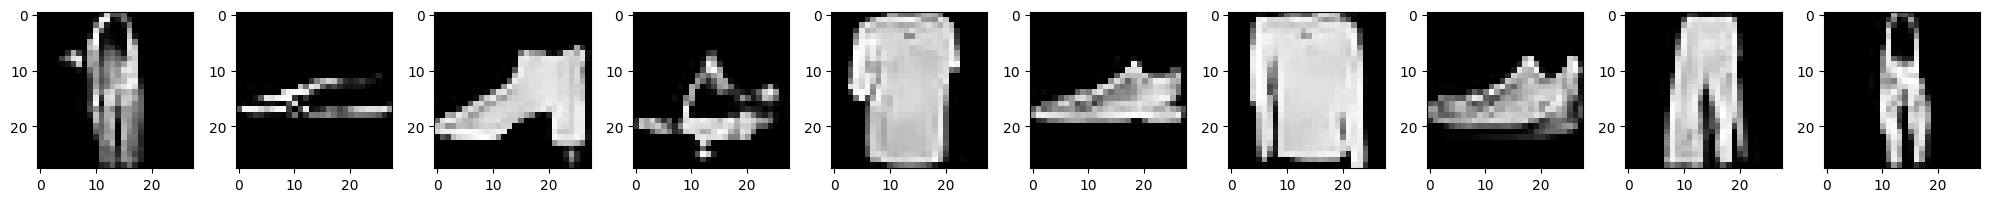

469/469 [==============================] - 23s 48ms/step - loss: 2.2144 - d_loss: 1.8684 - g_loss: 0.3460
Epoch 26/100
469/469 [==============================] - ETA: 0s - loss: 2.2292 - d_loss: 1.8634 - g_loss: 0.3657

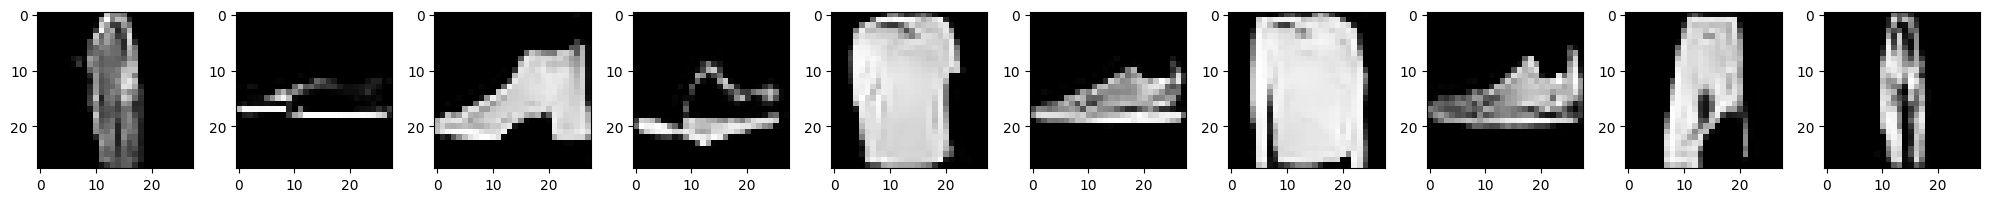

469/469 [==============================] - 23s 49ms/step - loss: 2.2292 - d_loss: 1.8634 - g_loss: 0.3657
Epoch 27/100
468/469 [============================>.] - ETA: 0s - loss: 2.1646 - d_loss: 1.8504 - g_loss: 0.3142

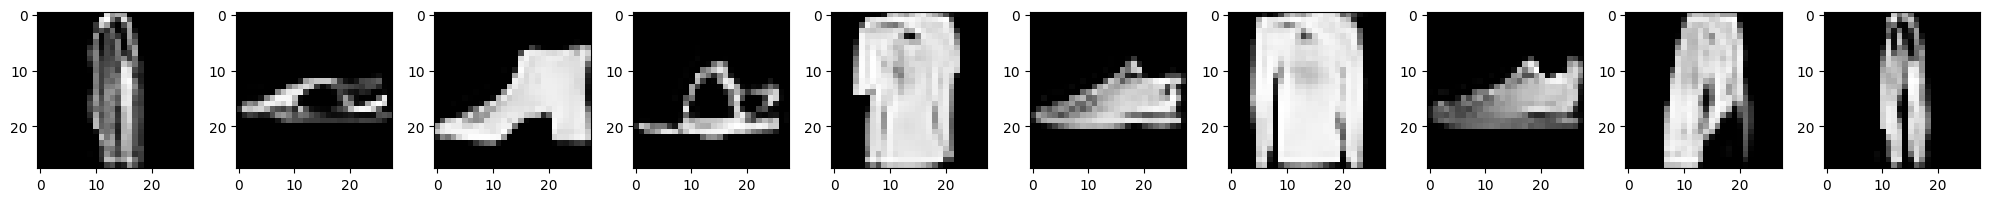

469/469 [==============================] - 22s 47ms/step - loss: 2.1640 - d_loss: 1.8505 - g_loss: 0.3135
Epoch 28/100
469/469 [==============================] - ETA: 0s - loss: 2.1228 - d_loss: 1.8253 - g_loss: 0.2975

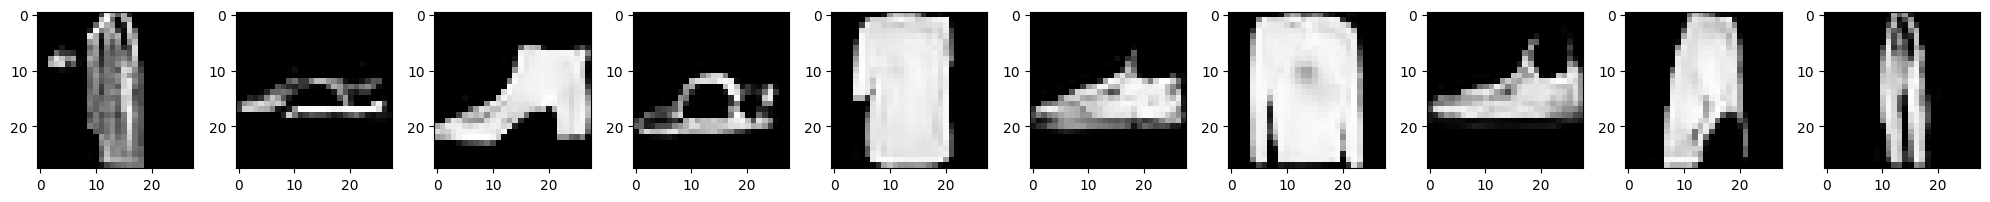

469/469 [==============================] - 22s 47ms/step - loss: 2.1228 - d_loss: 1.8253 - g_loss: 0.2975
Epoch 29/100
469/469 [==============================] - ETA: 0s - loss: 2.1065 - d_loss: 1.7950 - g_loss: 0.3114

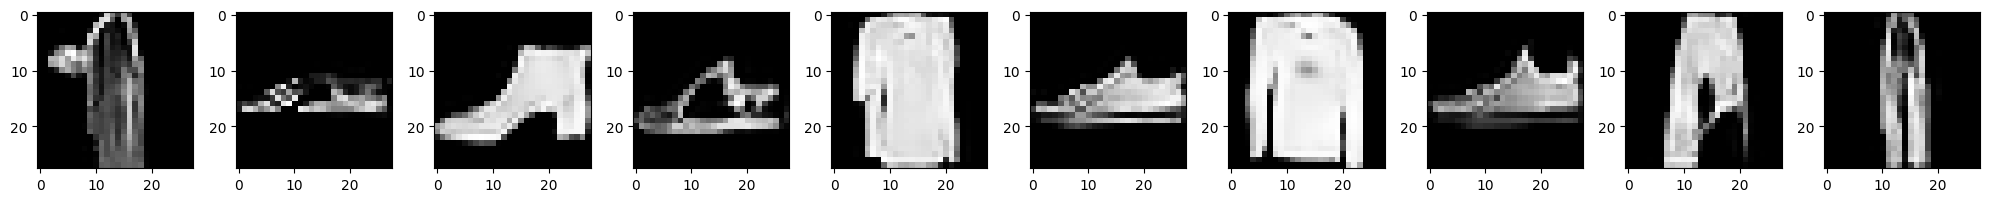

469/469 [==============================] - 22s 47ms/step - loss: 2.1065 - d_loss: 1.7950 - g_loss: 0.3114
Epoch 30/100
469/469 [==============================] - ETA: 0s - loss: 2.0711 - d_loss: 1.7774 - g_loss: 0.2937

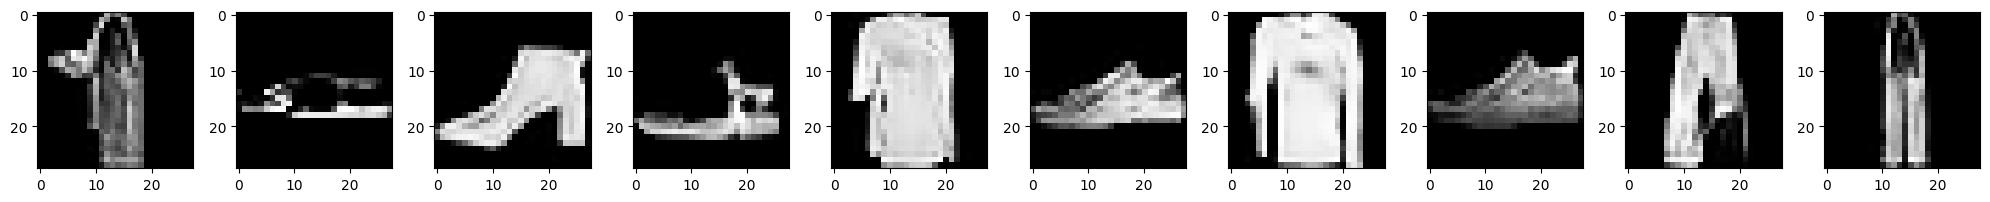

469/469 [==============================] - 22s 47ms/step - loss: 2.0711 - d_loss: 1.7774 - g_loss: 0.2937
Epoch 31/100
468/469 [============================>.] - ETA: 0s - loss: 2.0396 - d_loss: 1.7633 - g_loss: 0.2764

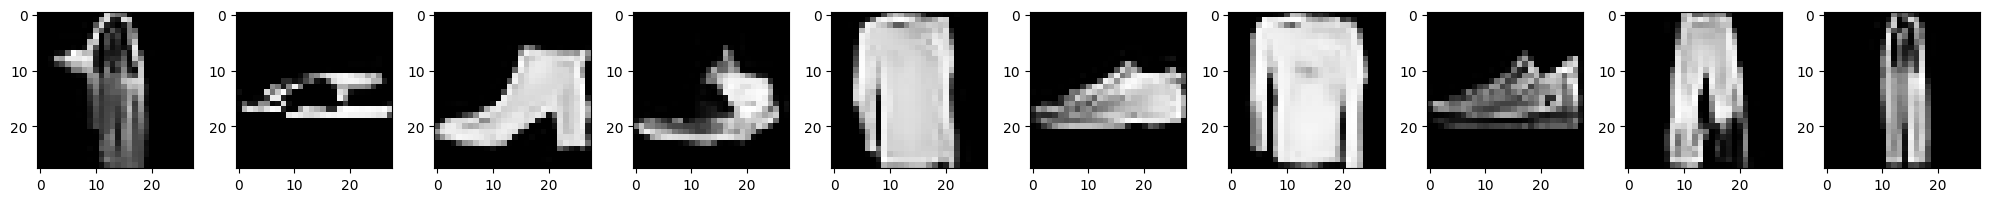

469/469 [==============================] - 23s 48ms/step - loss: 2.0382 - d_loss: 1.7627 - g_loss: 0.2755
Epoch 32/100
469/469 [==============================] - ETA: 0s - loss: 2.0673 - d_loss: 1.7722 - g_loss: 0.2951

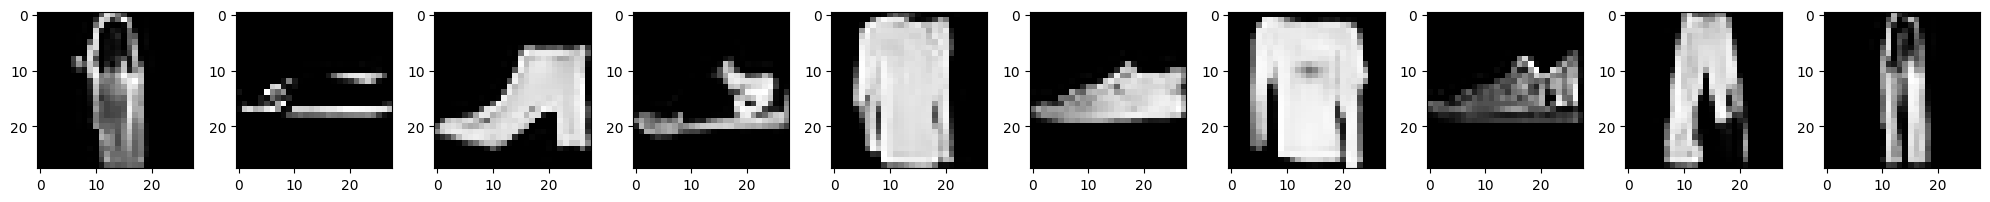

469/469 [==============================] - 23s 50ms/step - loss: 2.0673 - d_loss: 1.7722 - g_loss: 0.2951
Epoch 33/100
468/469 [============================>.] - ETA: 0s - loss: 2.0007 - d_loss: 1.7327 - g_loss: 0.2680

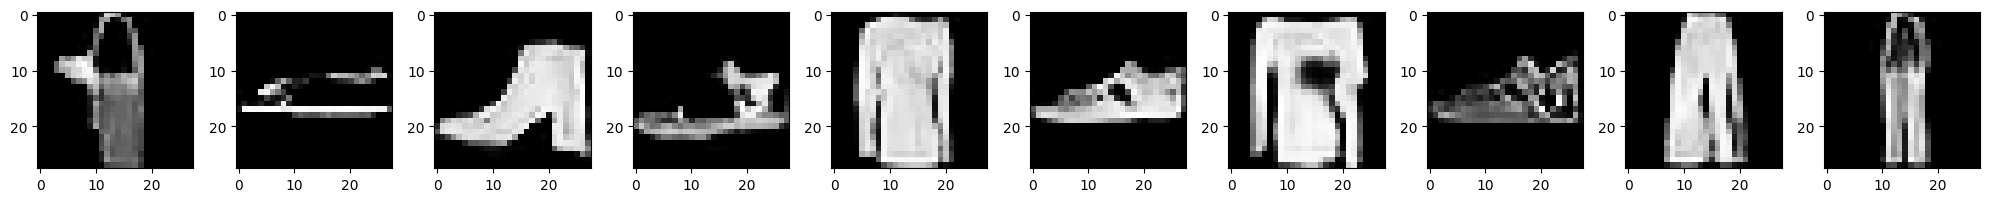

469/469 [==============================] - 22s 48ms/step - loss: 1.9999 - d_loss: 1.7325 - g_loss: 0.2674
Epoch 34/100
468/469 [============================>.] - ETA: 0s - loss: 2.0039 - d_loss: 1.7354 - g_loss: 0.2686

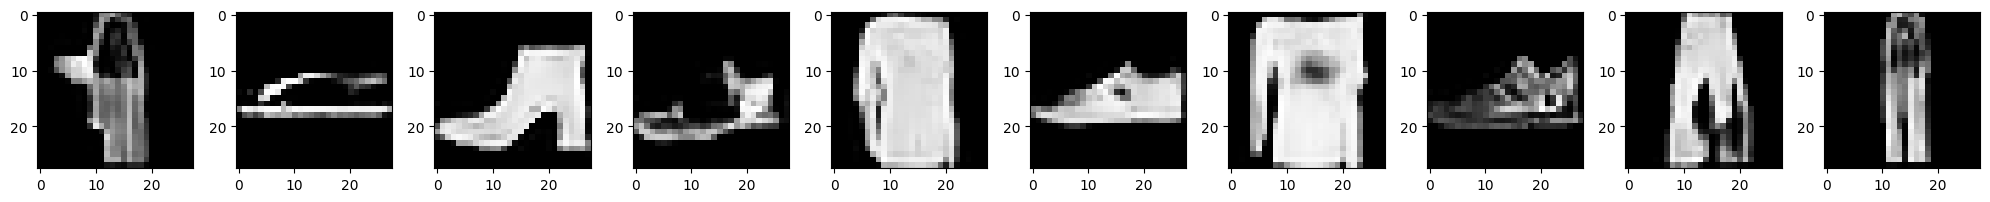

469/469 [==============================] - 22s 48ms/step - loss: 2.0036 - d_loss: 1.7352 - g_loss: 0.2684
Epoch 35/100
468/469 [============================>.] - ETA: 0s - loss: 2.0050 - d_loss: 1.7159 - g_loss: 0.2891

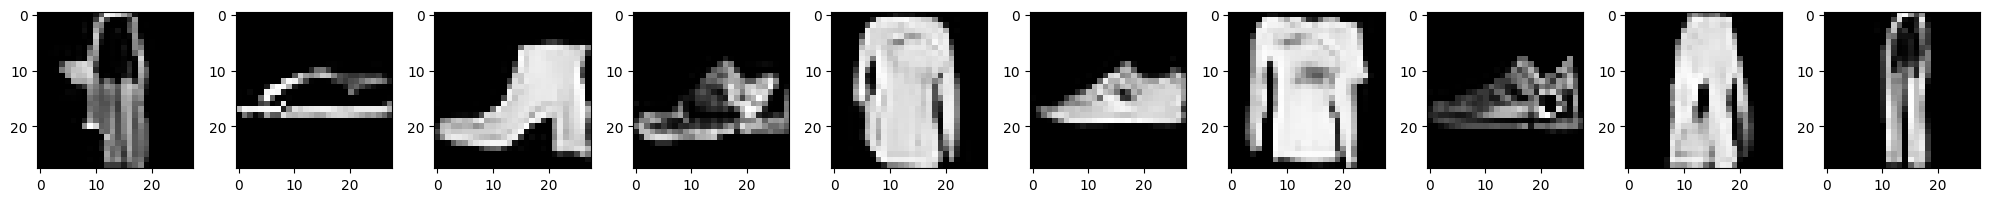

469/469 [==============================] - 22s 48ms/step - loss: 2.0046 - d_loss: 1.7155 - g_loss: 0.2892
Epoch 36/100
469/469 [==============================] - ETA: 0s - loss: 1.9944 - d_loss: 1.6959 - g_loss: 0.2985

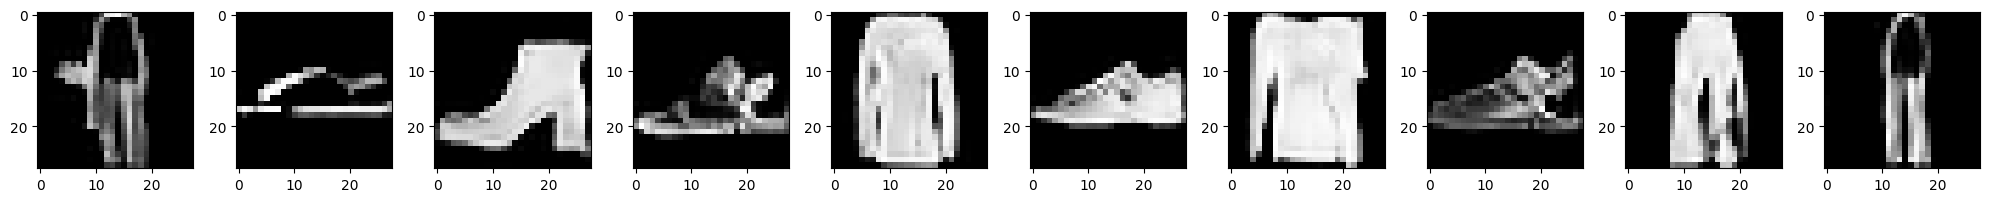

469/469 [==============================] - 22s 48ms/step - loss: 1.9944 - d_loss: 1.6959 - g_loss: 0.2985
Epoch 37/100
468/469 [============================>.] - ETA: 0s - loss: 1.9947 - d_loss: 1.6984 - g_loss: 0.2963

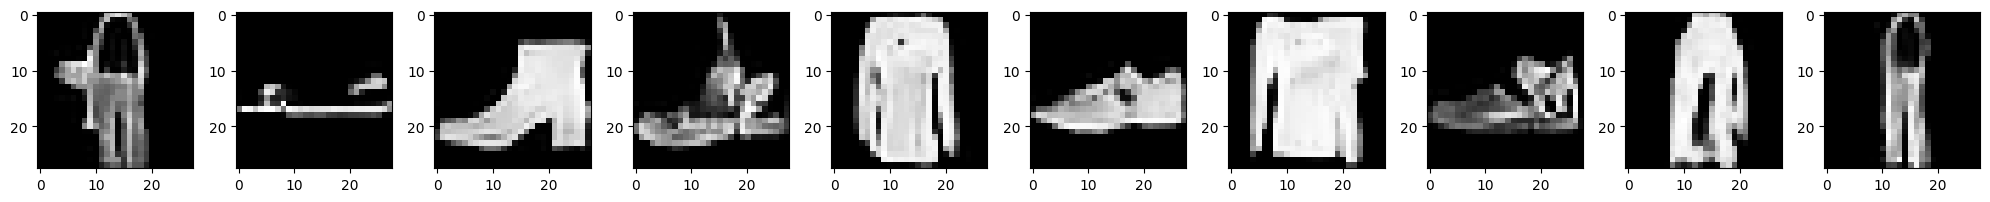

469/469 [==============================] - 23s 49ms/step - loss: 1.9941 - d_loss: 1.6983 - g_loss: 0.2958
Epoch 38/100
 43/469 [=>............................] - ETA: 19s - loss: 2.0912 - d_loss: 1.7796 - g_loss: 0.3116

KeyboardInterrupt: 

In [39]:
gan_history = gan.fit(
    dataset, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=cb
).history

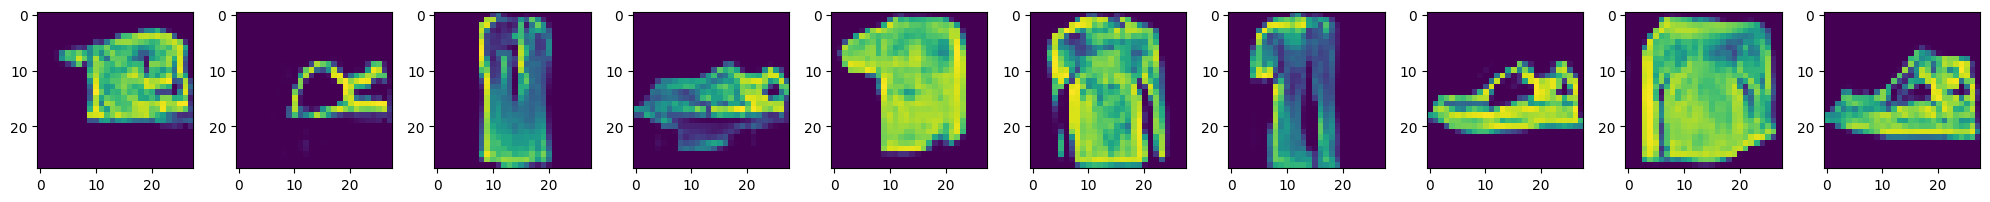

In [176]:
noise = tf.random.normal(shape=(10, latent_dim))
labels = tf.cast(tf.math.floormod(tf.range(0, 10), 10), "int32")
generated_images = gan.generator([noise, labels]).numpy()

fig, axes = plt.subplots(1, 10, figsize=(20, 2 * 10))
for i in range(10):
    img = tfk.preprocessing.image.array_to_img(generated_images[i])
    ax = axes[i % 10]
    ax.imshow(np.squeeze(img))
plt.tight_layout()
plt.show()

In [ ]:
def build_model()

"""
if small -> params...filers=8, depth=2
if medium
if big
"""

In [ ]:
def generate_data()